# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn import model_selection as ms
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as ss
#for ML
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import models as ml
from tensorflow.keras import layers as l
from tensorflow.keras.callbacks import EarlyStopping
# for feature selection
from boruta import BorutaPy
#for splitting data
from sklearn import model_selection as ms
#for metrics
from sklearn import metrics as m
from scikitplot import metrics as mt
#for fine tuning
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

C:\Users\marcellohro\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\marcellohro\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\marcellohro\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\marcellohro\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [2]:
SEED=42

In [3]:
data = pd.read_csv('ml_project1_data.csv')

In [4]:
# Since no test data was given I will split the data between train and test
x=data.drop(['Response'],axis=1)
y=data['Response']
xtrain, xtest, ytrain, ytest = ms.train_test_split(x,y,test_size=0.20,random_state=SEED)

In [5]:
train_set=pd.concat([xtrain,ytrain],axis=1)
test_set=pd.concat([xtest,ytest],axis=1)

## Helper functions

In [6]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [7]:
# make list of variables types
def variable_types(data):
    # numerical: discrete and continuous
    continuous = [var for var in data.columns if data[var].dtype != '<M8[ns]' and data[var].nunique() > 100 and var != 'ID']
    categorical = [var for var in data.columns if data[var].dtype == 'O' or data[var].nunique() < 3]
    date = [var for var in data.columns if data[var].dtype == '<M8[ns]']
    discrete = [var for var in list( set(data.columns)-set(data[continuous+categorical+date].columns) )]
    
#     discrete = [var for var in data.columns if data[var].dtype != 'O' and data[var].nunique() in range(2,101)]
#     categorical = [var for var in data.columns if data[var].dtype == 'O']
#     continuous = [var for var in list( set(data.columns)-set(data[discrete+categorical].columns) )]

    # categorical
#     categorical = [var for var in list( set(data.columns)-set(data[discrete+continuous].columns) )]
#     categorical = [var for var in data.columns if data[var].dtype == 'O']

    print('There are {} discrete variables'.format(len(discrete)))
    print('There are {} continuous variables'.format(len(continuous)))
    print('There are {} categorical variables'.format(len(categorical)))
    print('There are {} date_time variables'.format(len(date)))
    
    return discrete,continuous,categorical,date

In [8]:
def cross_validation( target, data2crossv, kfold, model_name, model, undersample=None):
    acc_list = []
    balanced_acc_list = []
    f1_list = []
    kappa_list = []
    
    kfold = ms.StratifiedKFold( n_splits=kfold, shuffle=True, random_state=SEED )
#     tscv = TimeSeriesSplit(n_splits=kfold)
    
    #data2crossv.set_index(['date'])
    X=data2crossv.drop(target,axis=1)
    Y=data2crossv[target]
    
    for train_index,test_index in kfold.split(X,Y):
        
        #splitting
        xtraining, xvalidation, ytraining, yvalidation = X.values[train_index], X.values[test_index], \
                                       Y.values[train_index], Y.values[test_index]
        
        if undersample:
            xtraining, ytraining = undersample.fit_sample(xtraining, ytraining)
                
        # model and prediction
        if model_name=='Neural Net':
            model.add( l.Dense( units=256, input_dim=xtraining.shape[1], activation='relu' ) )
            model.add( l.Dense( units=128, activation='relu') )
            model.add( l.Dense( units=32, activation='relu') )
            model.add( l.Dense( units=1, activation='sigmoid') )
            model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )
            early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
            model.fit( xtraining, ytraining, epochs=20, validation_data=(xvalidation, yvalidation), verbose=1, callbacks=[early_stop])
            yhat = model.predict_classes(xvalidation)
        else:
            m = model.fit( xtraining, ytraining.ravel() )
            yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, yvalidation, yhat)

        # store performance of each kfold iteration
        acc_list.append(  m_result['Accuracy'] )
        balanced_acc_list.append( m_result['Balanced accuracy'] )
        f1_list.append( m_result['F1 score'] )
        kappa_list.append( m_result['Kappa Metrics'] )
        
    return pd.DataFrame( {'Model Name': model_name,
                          'ACC CV': np.round( np.mean( acc_list ), 4 ).astype( str ) + ' +/- ' + np.round( np.std( acc_list ), 4 ).astype( str ),
                          'Balanced ACC CV': np.round( np.mean( balanced_acc_list ), 4).astype( str ) + ' +/- ' + np.round( np.std( balanced_acc_list ), 4 ).astype( str ),
                          'F1 CV': np.round( np.mean( f1_list ), 4 ).astype( str ) + ' +/- ' + np.round( np.std( f1_list ), 4 ).astype( str ),
                          'Kappa CV': np.round( np.mean( kappa_list ), 4 ).astype( str ) + ' +/- ' + np.round( np.std( kappa_list ), 4 ).astype( str )
                         }, index=[0] )

In [9]:
def ml_error( model_name, y, yhat ):
    # Accuracy
    acc = m.accuracy_score( y, yhat )
    # Balanced Accuracy
    balanced_acc = m.balanced_accuracy_score( y, yhat )
    # F1 score
    f1 = m.f1_score( y, yhat )
    # Kappa Metrics
    kappa = m.cohen_kappa_score( y, yhat )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'Accuracy': acc,
                           'Balanced accuracy': balanced_acc,
                           'F1 score': f1, 
                           'Kappa Metrics': kappa
                         }, index=[0] )

# DATA DESCRIPTION

In [10]:
df1=train_set.copy()

## Variables inspection

**Analysis**
* There are 10 discrete variables
* There are 7 continuous variables
* There are 11 categorical variables
* There are 1 date_time variables

Continuous:  ['Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'] 

Discrete:  ['NumStorePurchases', 'NumWebVisitsMonth', 'NumWebPurchases', 'Year_Birth', 'NumCatalogPurchases', 'Recency', 'Kidhome', 'Teenhome', 'ID', 'NumDealsPurchases'] 

Categorical:  ['Education', 'Marital_Status', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'] 

Date_time: ['Dt_Customer']

In [11]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 1792
Number of columns: 29


In [12]:
df1.describe()

ID   Year_Birth         Income      Kidhome     Teenhome  \
count   1792.000000  1792.000000    1773.000000  1792.000000  1792.000000   
mean    5617.574777  1968.955357   51963.622109     0.455915     0.503348   
std     3277.296050    11.875457   26152.764913     0.544254     0.543979   
min        0.000000  1899.000000    1730.000000     0.000000     0.000000   
25%     2806.250000  1959.000000   34824.000000     0.000000     0.000000   
50%     5515.000000  1970.000000   50965.000000     0.000000     0.000000   
75%     8547.000000  1978.000000   68118.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  1792.000000  1792.000000  1792.000000      1792.000000   
mean     48.429688   295.078125    26.574777       167.187500   
std      28.697085   334.553568    40.367560       229.849392   
min       0.000000     0.000000     0.000000         0.000000   
25%      24.000000    23.000000     1.000000        15.000000   
50%      49.000000   162.500000     8.000000        65.500000   
75%      73.000000   483.000000    33.000000       226.500000   
max      99.000000  1493.000000   199.000000      1725.000000   

       MntFishProducts  ...  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
count      1792.000000  ...        1792.000000   1792.000000   1792.000000   
mean         37.459821  ...           5.307478      0.075335      0.069754   
std          54.431610  ...           2.448302      0.264005      0.254804   
min           0.000000  ...           0.000000      0.000000      0.000000   
25%           3.000000  ...           3.000000      0.000000      0.000000   
50%          12.000000  ...           6.000000      0.000000      0.000000   
75%          50.000000  ...           7.000000      0.000000      0.000000   
max         259.000000  ...          20.000000      1.000000      1.000000   

       AcceptedCmp5  AcceptedCmp1  AcceptedCmp2     Complain  Z_CostContact  \
count   1792.000000   1792.000000   1792.000000  1792.000000         1792.0   
mean       0.074777      0.064174      0.011719     0.011161            3.0   
std        0.263104      0.245131      0.107647     0.105082            0.0   
min        0.000000      0.000000      0.000000     0.000000            3.0   
25%        0.000000      0.000000      0.000000     0.000000            3.0   
50%        0.000000      0.000000      0.000000     0.000000            3.0   
75%        0.000000      0.000000      0.000000     0.000000            3.0   
max        1.000000      1.000000      1.000000     1.000000            3.0   

       Z_Revenue     Response  
count     1792.0  1792.000000  
mean        11.0     0.147879  
std          0.0     0.355080  
min         11.0     0.000000  
25%         11.0     0.000000  
50%         11.0     0.000000  
75%         11.0     0.000000  
max         11.0     1.000000  

[8 rows x 26 columns]

In [13]:
df1.iloc[:11,:16]

ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
792    3479        1950  Graduation         Single  16813.0        0   
1271   7488        1963      Master         Single  64191.0        0   
1538   1079        1971         PhD        Married  71969.0        0   
668   11007        1968         PhD        Married  29187.0        1   
1975  10311        1969  Graduation        Married   4428.0        0   
729   11101        1991  Graduation       Together  89891.0        0   
1651   8395        1961  Graduation         Single  82014.0        0   
2054   6382        1953  Graduation       Together  48794.0        1   
926    2008        1978  Graduation        Married  77583.0        0   
1023   4550        1966      Master       Together  33564.0        0   
178   10492        1959  Graduation       Together  38285.0        2   

      Teenhome Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  \
792          0  2013-07-19       49         4          8               11   
1271         1  2013-01-22       30       420         15              186   
1538         1  2012-10-16       59      1000          0               76   
668          0  2013-05-09       43        26          0                6   
1975         1  2013-10-05        0        16          4               12   
729          0  2013-04-15       17       412         22              132   
1651         0  2012-08-20       48       980         37              265   
2054         1  2014-06-26       97        25          0               11   
926          0  2014-02-10       93       372         23              384   
1023         1  2014-06-24       51        61          0                3   
178          1  2014-06-24       96         2          0                5   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  
792                12                 2            13                  1  
1271              151                38            15                  3  
1538                0                 0            10                  3  
668                 0                 0             2                  1  
1975                2                 4           321                  0  
729                59                28           183                  1  
1651               35               163            31                  1  
2054                3                 0            15                  1  
926               250                12           108                  1  
1023                0                 0             7                  1  
178                 2                 0             1                  1

In [14]:
df1.iloc[:11,16:]

NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
792                 2                    0                  3   
1271                5                    3                 13   
1538                3                    4                  9   
668                 1                    0                  3   
1975               25                    0                  0   
729                11                    6                  8   
1651                3                    6                 12   
2054                1                    0                  3   
926                 4                    5                  9   
1023                1                    1                  3   
178                 0                    0                  3   

      NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  \
792                   7             1             0             0   
1271                  3             0             0             0   
1538                  8             0             1             0   
668                   8             0             0             0   
1975                  1             0             0             0   
729                   4             0             0             1   
1651                  6             0             0             0   
2054                  4             0             0             0   
926                   2             0             0             0   
1023                  5             0             0             0   
178                   2             0             0             0   

      AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  Z_Revenue  Response  
792              0             0         0              3         11         0  
1271             0             0         0              3         11         0  
1538             0             0         0              3         11         0  
668              0             0         0              3         11         0  
1975             0             0         0              3         11         0  
729              0             0         0              3         11         0  
1651             0             0         0              3         11         1  
2054             0             0         0              3         11         0  
926              1             0         0              3         11         0  
1023             0             0         0              3         11         0  
178              0             0         0              3         11         0

In [15]:
df1.nunique()

ID                     1792
Year_Birth               57
Education                 5
Marital_Status            8
Income                 1616
Kidhome                   3
Teenhome                  3
Dt_Customer             641
Recency                 100
MntWines                691
MntFruits               156
MntMeatProducts         518
MntFishProducts         174
MntSweetProducts        169
MntGoldProds            204
NumDealsPurchases        15
NumWebPurchases          15
NumCatalogPurchases      14
NumStorePurchases        14
NumWebVisitsMonth        16
AcceptedCmp3              2
AcceptedCmp4              2
AcceptedCmp5              2
AcceptedCmp1              2
AcceptedCmp2              2
Complain                  2
Z_CostContact             1
Z_Revenue                 1
Response                  2
dtype: int64

In [16]:
# let's inspect the variable values proportion

for var in df1.columns:
    print(var, '\n', df1[var].value_counts(normalize=True).head(10)*100, '\n')

ID 
 4094    0.055804
4088    0.055804
7433    0.055804
5386    0.055804
7437    0.055804
7441    0.055804
5394    0.055804
5396    0.055804
610     0.055804
7453    0.055804
Name: ID, dtype: float64 

Year_Birth 
 1976    4.408482
1971    3.906250
1978    3.683036
1975    3.627232
1970    3.515625
1972    3.515625
1965    3.459821
1973    3.348214
1969    3.292411
1974    2.734375
Name: Year_Birth, dtype: float64 

Education 
 Graduation    50.948661
PhD           21.875000
Master        15.848214
2n Cycle       8.928571
Basic          2.399554
Name: Education, dtype: float64 

Marital_Status 
 Married     39.341518
Together    25.948661
Single      21.261161
Divorced     9.877232
Widow        3.236607
Alone        0.167411
YOLO         0.111607
Absurd       0.055804
Name: Marital_Status, dtype: float64 

Income 
 7500.0     0.620417
35860.0    0.225606
83844.0    0.169205
63841.0    0.169205
34176.0    0.169205
46098.0    0.169205
67445.0    0.169205
39922.0    0.169205
80134.0    0.

In [17]:
# let's inspect the variable values

for var in df1.columns:
    print(var, df1[var].unique()[0:20], '\n')

ID [ 3479  7488  1079 11007 10311 11101  8395  6382  2008  4550 10492  2426
  7842  7600   635  8560 10971  5848  8624  9977] 

Year_Birth [1950 1963 1971 1968 1969 1991 1961 1953 1978 1966 1959 1964 1992 1977
 1970 1958 1973 1951 1975 1983] 

Education ['Graduation' 'Master' 'PhD' 'Basic' '2n Cycle'] 

Marital_Status ['Single' 'Married' 'Together' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO'] 

Income [16813. 64191. 71969. 29187.  4428. 89891. 82014. 48794. 77583. 33564.
 38285. 78825. 36065. 15253. 57183. 48789. 37774. 81205. 81320. 78901.] 

Kidhome [0 1 2] 

Teenhome [0 1 2] 

Dt_Customer ['2013-07-19' '2013-01-22' '2012-10-16' '2013-05-09' '2013-10-05'
 '2013-04-15' '2012-08-20' '2014-06-26' '2014-02-10' '2014-06-24'
 '2012-09-14' '2013-03-31' '2013-10-28' '2013-03-19' '2012-09-10'
 '2012-09-03' '2014-01-13' '2013-02-06' '2013-09-17' '2014-02-12'] 

Recency [49 30 59 43  0 17 48 97 93 51 96 35 54 13 94 28 61 99 63  2] 

MntWines [   4  420 1000   26   16  412  980   25  372   61    

In [18]:
df1.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

In [19]:
df1['Dt_Customer']=pd.to_datetime(df1['Dt_Customer'])

In [20]:
discrete,continuous,categorical,dates=variable_types(df1)

There are 10 discrete variables
There are 7 continuous variables
There are 11 categorical variables
There are 1 date_time variables


In [21]:
print('Continuous: ',continuous,'\n')
print('Discrete: ',discrete,'\n')
print('Categorical: ',categorical,'\n')
print('Date_time: ',dates,'\n')

Continuous:  ['Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'] 

Discrete:  ['NumWebVisitsMonth', 'Kidhome', 'NumWebPurchases', 'ID', 'NumDealsPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'Year_Birth', 'Teenhome', 'Recency'] 

Categorical:  ['Education', 'Marital_Status', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'] 

Date_time:  ['Dt_Customer'] 



## Check NAs

**Analysis**

Few NAs on income column and none with zero value -> assume NA income is actually 0 income.

In [22]:
df1.isna().sum() / len( df1 )

ID                     0.000000
Year_Birth             0.000000
Education              0.000000
Marital_Status         0.000000
Income                 0.010603
Kidhome                0.000000
Teenhome               0.000000
Dt_Customer            0.000000
Recency                0.000000
MntWines               0.000000
MntFruits              0.000000
MntMeatProducts        0.000000
MntFishProducts        0.000000
MntSweetProducts       0.000000
MntGoldProds           0.000000
NumDealsPurchases      0.000000
NumWebPurchases        0.000000
NumCatalogPurchases    0.000000
NumStorePurchases      0.000000
NumWebVisitsMonth      0.000000
AcceptedCmp3           0.000000
AcceptedCmp4           0.000000
AcceptedCmp5           0.000000
AcceptedCmp1           0.000000
AcceptedCmp2           0.000000
Complain               0.000000
Z_CostContact          0.000000
Z_Revenue              0.000000
Response               0.000000
dtype: float64

In [23]:
df1[df1['Income']==0]

Empty DataFrame
Columns: [ID, Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Response]
Index: []

[0 rows x 29 columns]

In [24]:
df1['Income'].fillna(0,inplace=True)

## Descriptive Analysis

### Continuous


In [25]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( df1[continuous].apply( np.mean ) ).T
ct2 = pd.DataFrame( df1[continuous].apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( df1[continuous].apply( np.std ) ).T
d2 = pd.DataFrame( df1[continuous].apply( min ) ).T
d3 = pd.DataFrame( df1[continuous].apply( max ) ).T
d4 = pd.DataFrame( df1[continuous].apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df1[continuous].apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df1[continuous].apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

attributes  min       max     range          mean   median  \
0            Income  0.0  666666.0  666666.0  51412.668527  50613.5   
1          MntWines  0.0    1493.0    1493.0    295.078125    162.5   
2         MntFruits  0.0     199.0     199.0     26.574777      8.0   
3   MntMeatProducts  0.0    1725.0    1725.0    167.187500     65.5   
4   MntFishProducts  0.0     259.0     259.0     37.459821     12.0   
5  MntSweetProducts  0.0     263.0     263.0     27.003348      8.0   
6      MntGoldProds  0.0     362.0     362.0     43.710379     24.0   

            std      skew    kurtosis  
0  26545.424182  7.090804  160.288472  
1    334.460209  1.233436    0.752875  
2     40.356295  2.083553    3.914156  
3    229.785251  2.150934    5.990032  
4     54.416421  1.918951    3.112113  
5     41.254275  2.134584    4.414285  
6     52.095158  1.922320    3.822920

### Discrete

**Analysis**
* No repeated ID

In [26]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( df1[discrete].apply( np.mean ) ).T
ct2 = pd.DataFrame( df1[discrete].apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( df1[discrete].apply( np.std ) ).T
d2 = pd.DataFrame( df1[discrete].apply( min ) ).T
d3 = pd.DataFrame( df1[discrete].apply( max ) ).T
d4 = pd.DataFrame( df1[discrete].apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df1[discrete].apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df1[discrete].apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

attributes     min      max    range         mean  median  \
0    NumWebVisitsMonth     0.0     20.0     20.0     5.307478     6.0   
1              Kidhome     0.0      2.0      2.0     0.455915     0.0   
2      NumWebPurchases     0.0     27.0     27.0     4.012835     3.0   
3                   ID     0.0  11191.0  11191.0  5617.574777  5515.0   
4    NumDealsPurchases     0.0     15.0     15.0     2.306920     2.0   
5  NumCatalogPurchases     0.0     28.0     28.0     2.662946     2.0   
6    NumStorePurchases     0.0     13.0     13.0     5.739955     5.0   
7           Year_Birth  1899.0   1996.0     97.0  1968.955357  1970.0   
8             Teenhome     0.0      2.0      2.0     0.503348     0.0   
9              Recency     0.0     99.0     99.0    48.429688    49.0   

           std      skew  kurtosis  
0     2.447619  0.314385  2.333943  
1     0.544103  0.622601 -0.754549  
2     2.796752  1.569358  7.153482  
3  3276.381498  0.029323 -1.210162  
4     1.932337  2.548470  9.880787  
5     2.996503  2.011612  9.016889  
6     3.262409  0.716326 -0.609604  
7    11.872143 -0.200004 -0.192635  
8     0.543827  0.413842 -0.987364  
9    28.689077  0.010756 -1.174380

In [27]:
df1[discrete].applymap(str).describe()

NumWebVisitsMonth Kidhome NumWebPurchases     ID NumDealsPurchases  \
count               1792    1792            1792   1792              1792   
unique                16       3              15   1792                15   
top                    7       0               2  10352                 1   
freq                 314    1018             295      1               782   

       NumCatalogPurchases NumStorePurchases Year_Birth Teenhome Recency  
count                 1792              1792       1792     1792    1792  
unique                  14                14         57        3     100  
top                      0                 3       1976        0      56  
freq                   482               404         79      931      32

### Categorical

* Z_CostConcact and Z_Revenue both have only one unique value, and so it can be dropped for not containing information

In [28]:
df1[categorical].applymap(str).describe()

Education Marital_Status AcceptedCmp3 AcceptedCmp4 AcceptedCmp5  \
count         1792           1792         1792         1792         1792   
unique           5              8            2            2            2   
top     Graduation        Married            0            0            0   
freq           913            705         1657         1667         1658   

       AcceptedCmp1 AcceptedCmp2 Complain Z_CostContact Z_Revenue Response  
count          1792         1792     1792          1792      1792     1792  
unique            2            2        2             1         1        2  
top               0            0        0             3        11        0  
freq           1677         1771     1772          1792      1792     1527

### Dates

In [29]:
df1[dates].describe(datetime_is_numeric=True)

Dt_Customer
count                           1792
mean   2013-07-11 01:09:54.642857216
min              2012-07-30 00:00:00
25%              2013-01-19 00:00:00
50%              2013-07-08 00:00:00
75%              2013-12-31 00:00:00
max              2014-06-29 00:00:00

## Check Balance

85% x 15% is ok, data is not unbalanced

In [30]:
df1['Response'].value_counts()/len(df1['Response'])*100

0    85.212054
1    14.787946
Name: Response, dtype: float64

# EDA

In [31]:
df2=df1.copy()

## Hypothesis

Note: Hypthoeses written before the EDA, so that it can be conducted unbiased.

1. Responding any campaign in the past means higher chance of responding this campaign:

    **True**. Participating in campaigns in the past is a great indicator of participating in the last campaign.


2. Complaints means lower chance of responding this campaign:

    **False**. Past complaints isn't a good indicator of negative response


3. Veteran customers have higher chance of responding this campaign:

    **False** Veteran customers have lower acceptance of last campaign


4. Higher level of education means lower chance of responding this campaign:

    **False**. Education doesn't play an important role on response status


5. Single marital staus means higher chance of responding this campaign:

    **True** Living alone increases chance of responsing campaigns


6. Kids or teens in house means higher chance of responding this campaign:

    **False** Having teens or children decreases chance of responsing the campaign


7. Higher income means higher chance of responding this campaign:

    **True** Positive responders have an income median 30% higher than negative responders.


8. Higher amount spent in products means higher chance of responding this campaign:

    **True** Postive responder spends approximately 3.6 times more on products than negative responders

9. Higher amount spent in gold products means higher chance of responding this campaign than other products

    **True** Postive responder spends approximately 1.9 times more on gold products than negative responders

10. Higher number of products purchased, regardless of way of purchasing, means higher chance of responding this campaign

    **It depends** Positive responders buys more from the web (66% more), from catalogs (4x more) and from stores (50% more); However they buy less from deals (50% less)
    

11. Higher visits to website means higher chance of responding this campaign

    **False** number of visits to the website doesn't correlate well with the target
    

12. Higher recency means lower chance of responding this campaign

    **True** Postive responders have recency of 55% the value of negative responders

## Feature engineering

Created:
* column of total amount spent on any products
* column of total number of products purchased
* days since customer's enrollment with the company in relation to first customer's enrollment
* Customer's age
* Number of campaigns customer accepted

In [32]:
# Create column of total amount spent on any products
df2['MntTotal']=df2[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)

In [33]:
# Create column of total number of products purchased
df2['NumPurchasesTotal']=df2[['NumWebPurchases','NumStorePurchases','NumCatalogPurchases']].sum(axis=1)

In [34]:
# Create days since customer's enrollment with the company in relation to first customer's enrollment
df2['DaysSinceEnroll']=(df2['Dt_Customer']-df2['Dt_Customer'].min()).dt.days

In [35]:
# Customer's age in relation to the year 2020
# Note: To the model the choice of year 2020 doesn't matter here since it's just a linear transformation
df2['Age']=2020-df2['Year_Birth']

In [36]:
# Number of campaigns customer accepted
df2['AcceptedCmpTotal']=df2[['AcceptedCmp3','AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2']].sum(axis=1)

In [37]:
df2['Marital_Status'].unique()

array(['Single', 'Married', 'Together', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [38]:
# Number of family members
# number of adults: 2 if client is married or together and 1 otherwise
adult=df2['Marital_Status'].apply(lambda x: 2 if x in ['Married','Together'] else 1)
# family is number of adults + teenagers + number of children
df2['FamilySize']=adult+df2['Kidhome']+df2['Teenhome']

## Drop redundant columns

Dropped: ['Z_costConcact','Z_Revenue','Dt_Customer','ID']

In [39]:
df2.drop(labels=['Z_CostContact','Z_Revenue','Dt_Customer','ID','Year_Birth'],axis=1,inplace=True)

In [40]:
df2.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'MntTotal', 'NumPurchasesTotal',
       'DaysSinceEnroll', 'Age', 'AcceptedCmpTotal', 'FamilySize'],
      dtype='object')

## Univariate analysis

In [41]:
discrete,continuous,categorical,dates=variable_types(df2)

There are 12 discrete variables
There are 9 continuous variables
There are 9 categorical variables
There are 0 date_time variables


### Continuous + discrete
Data is very skewed but most outliers might be important (let's check with a bivariate analysis)


**Analysis**
* Most clients are withing 40-50 years of age
* Amount spent is skewed to zero value, most doesn't spend more than 400
* Most clients didn't participate in any campaign in the past
* Most clients don't have children at home
* Most clients buy directly from store
* In total clients spend more in wine (1st) and meat (2nd)

Weird outliers on:
* Income
* Age
* Mntmeatproducts


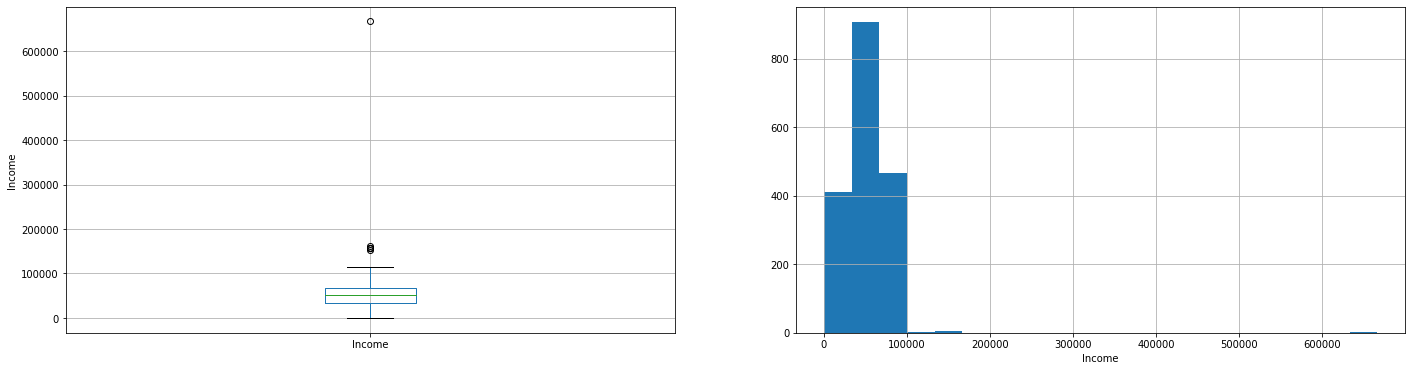

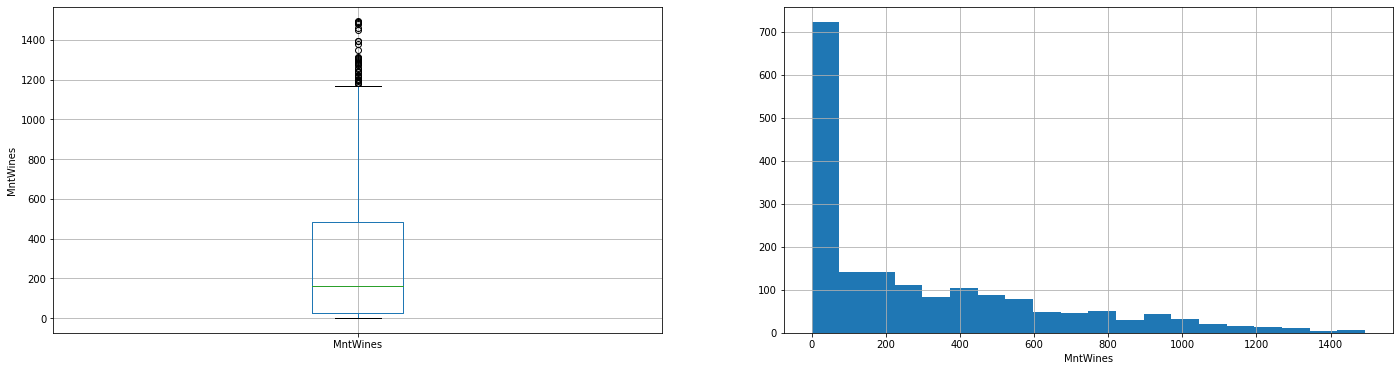

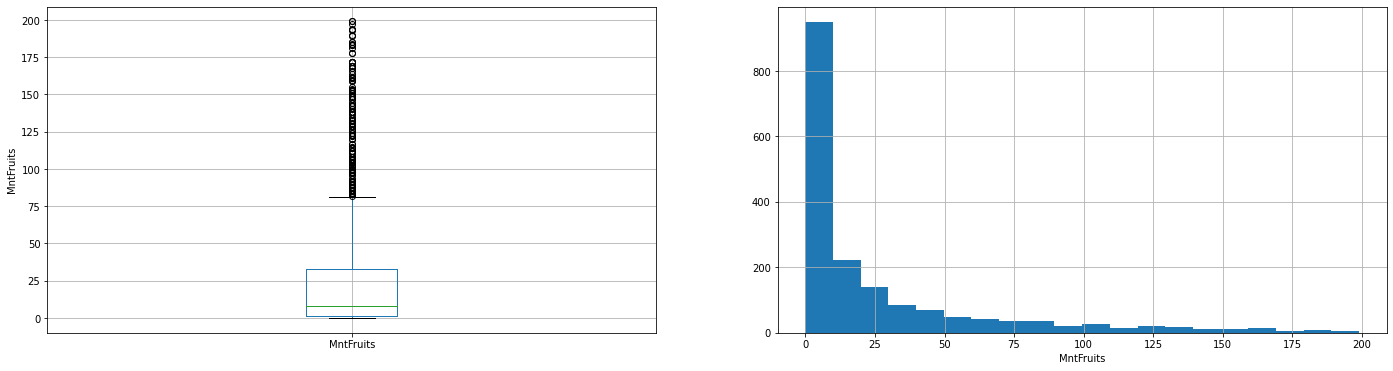

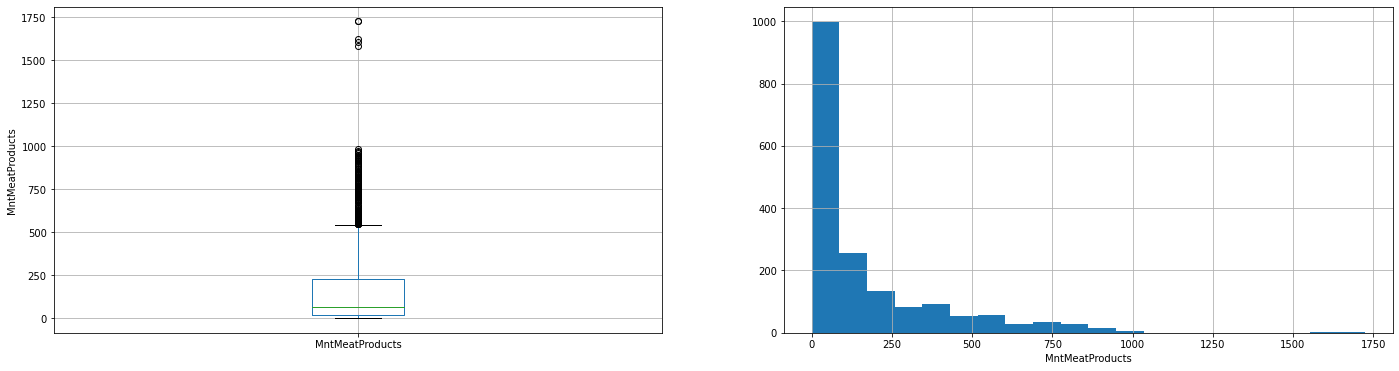

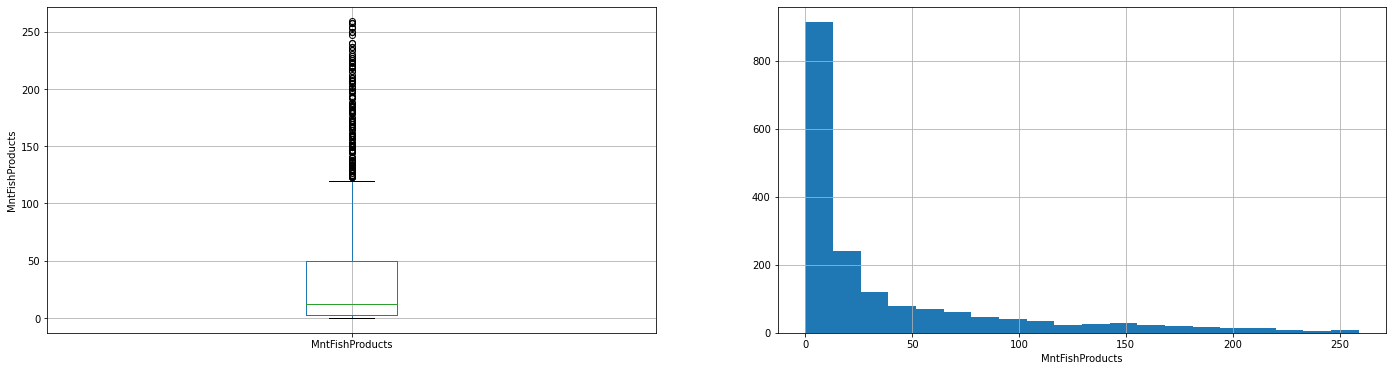

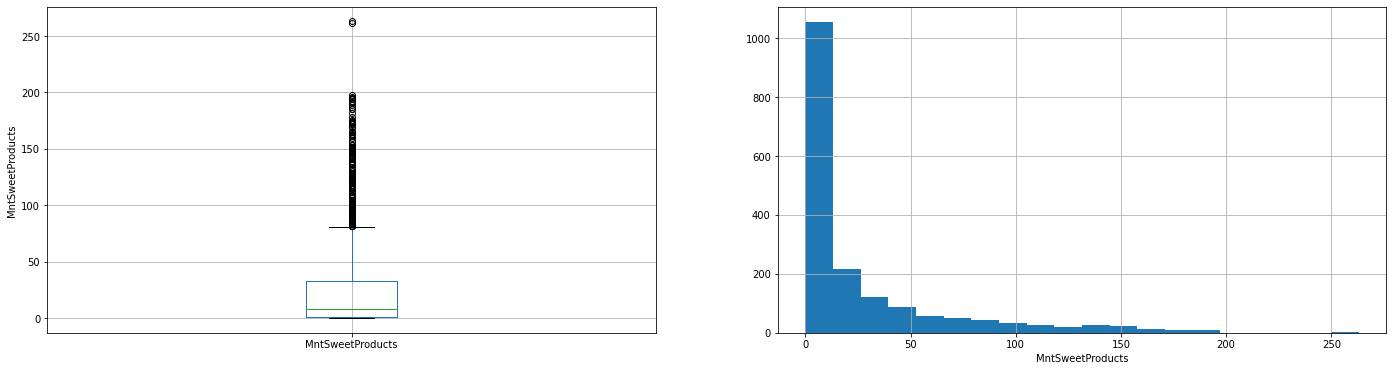

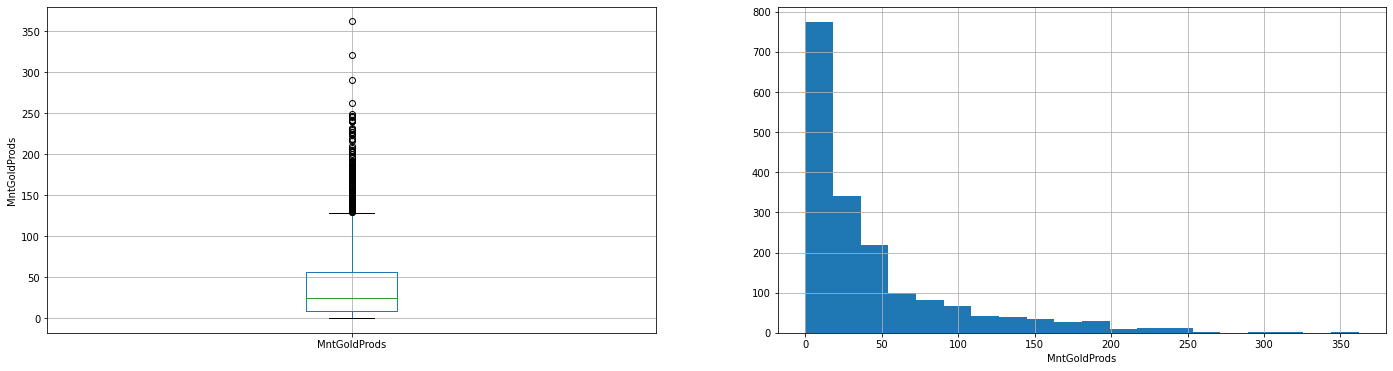

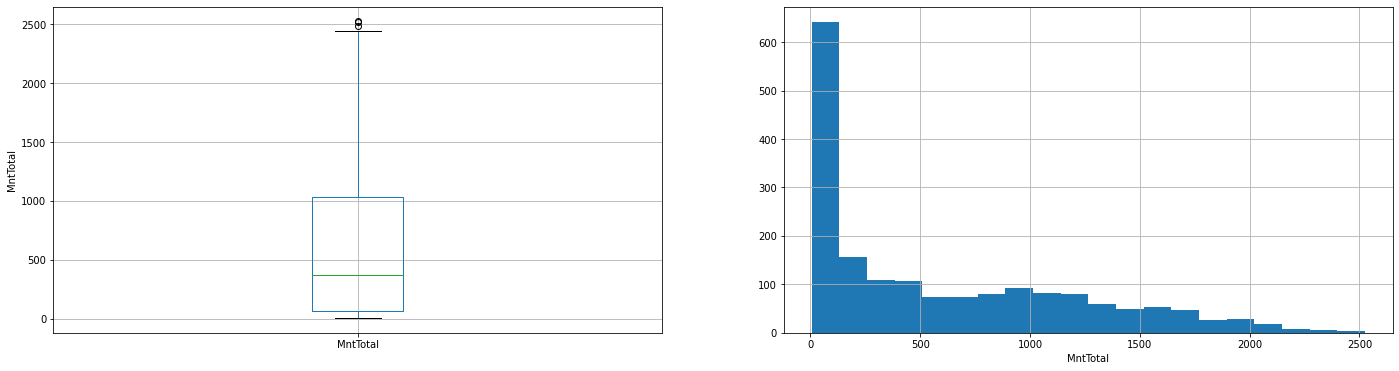

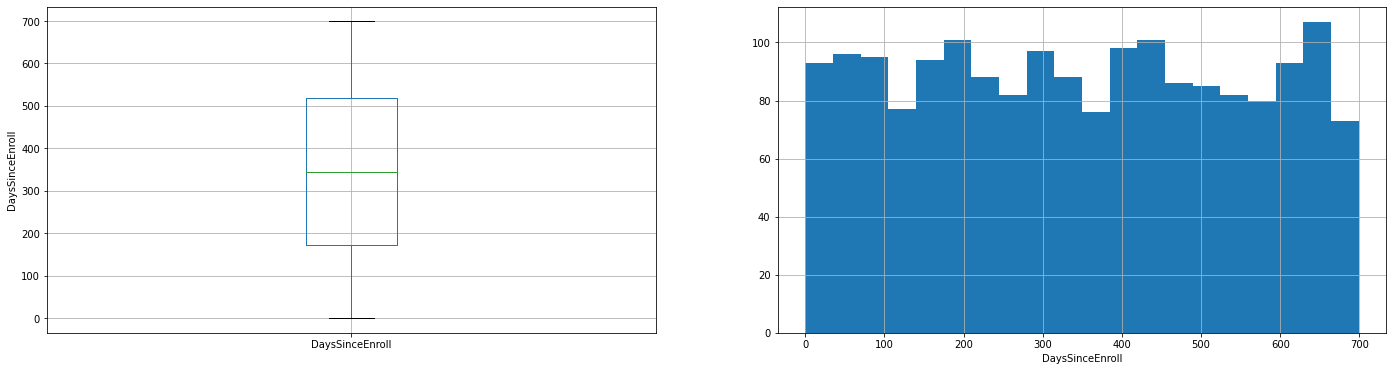

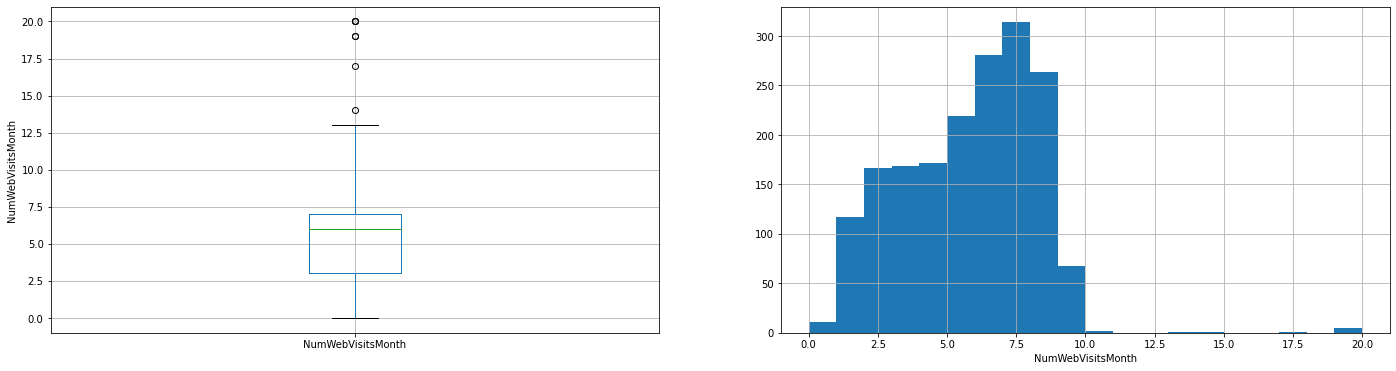

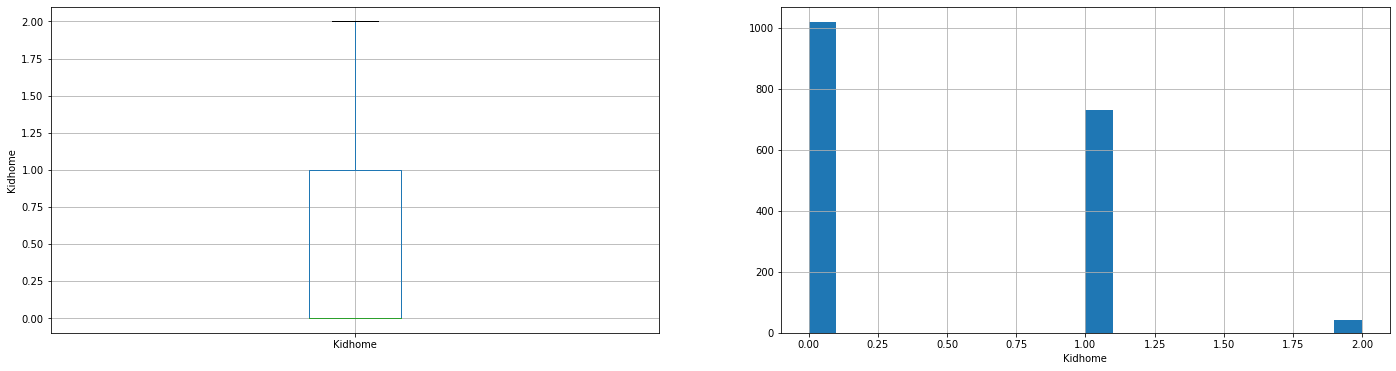

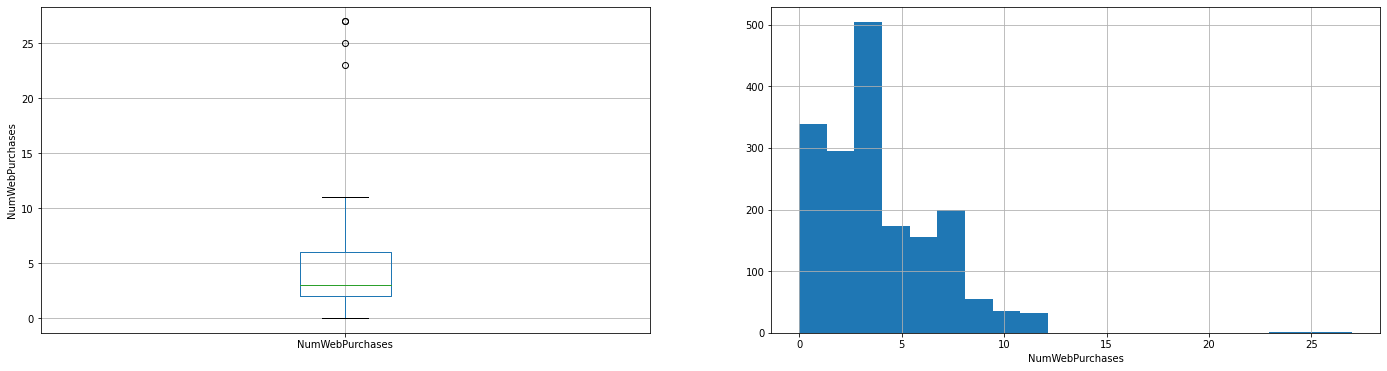

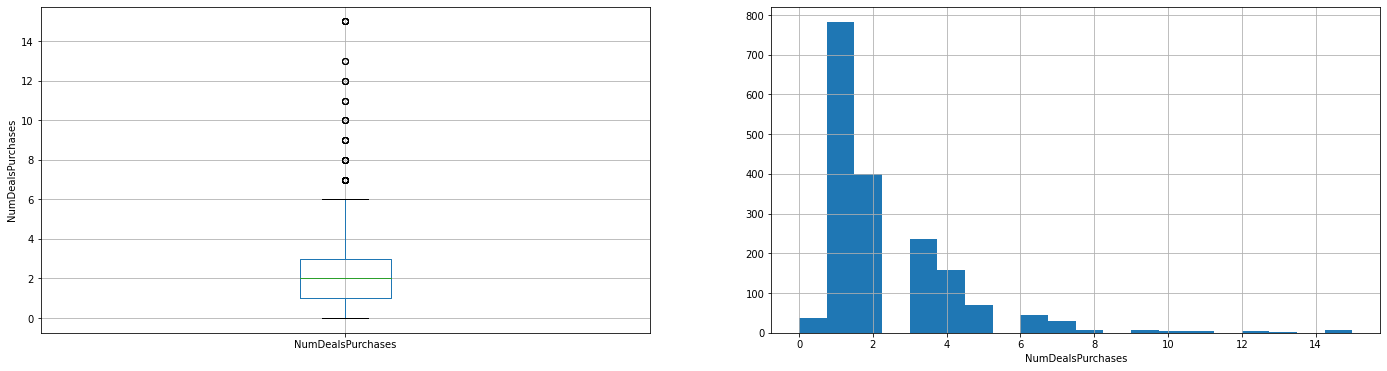

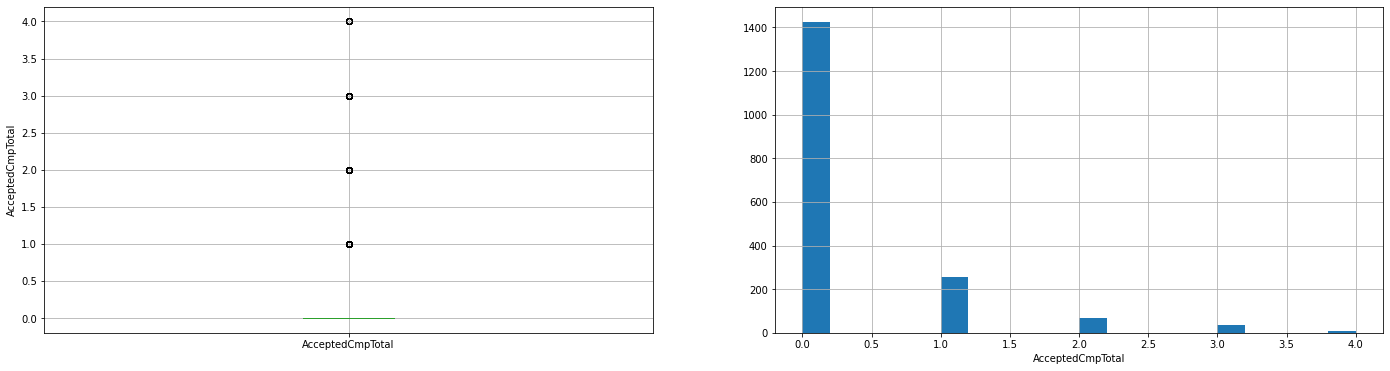

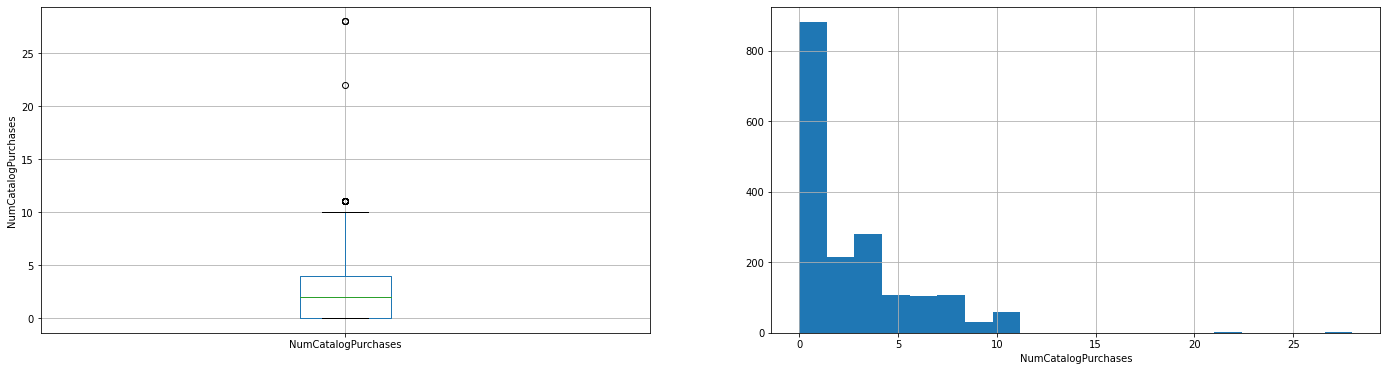

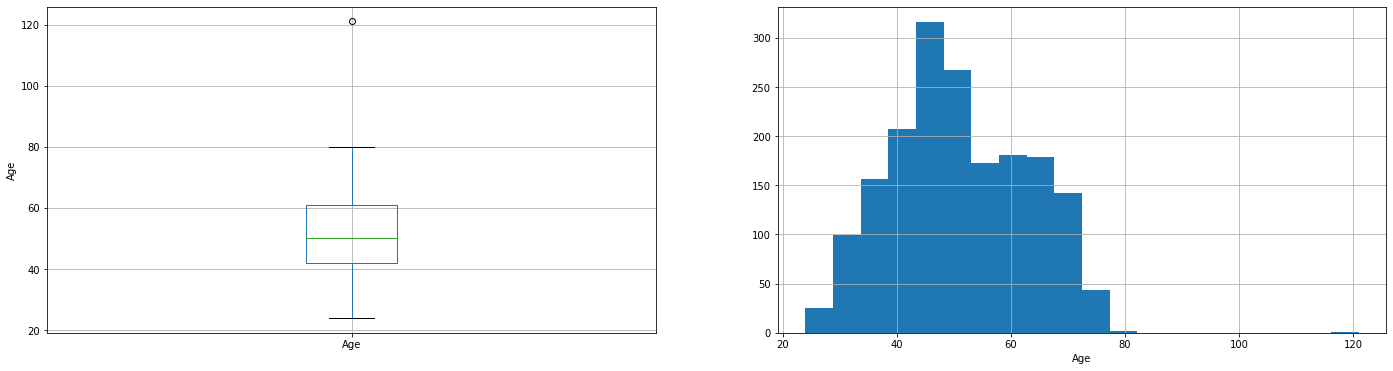

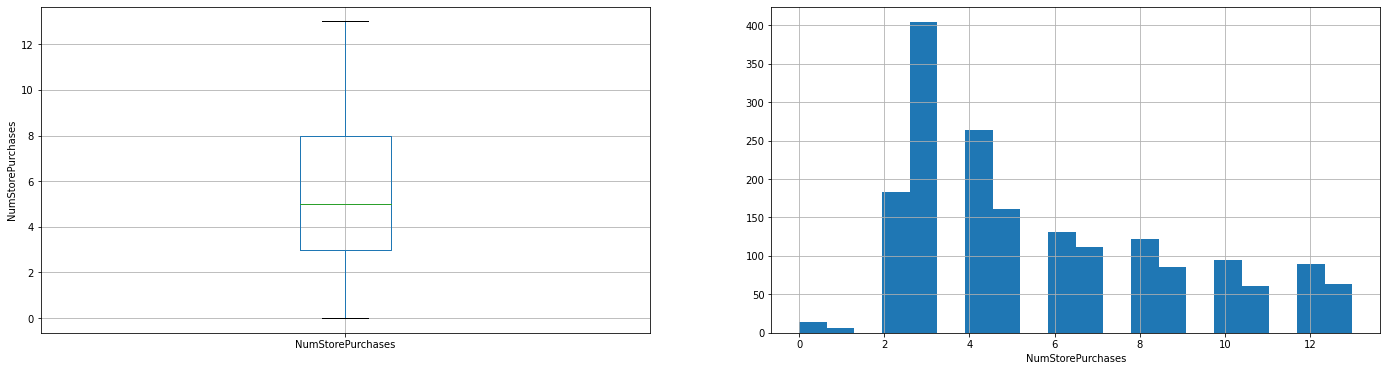

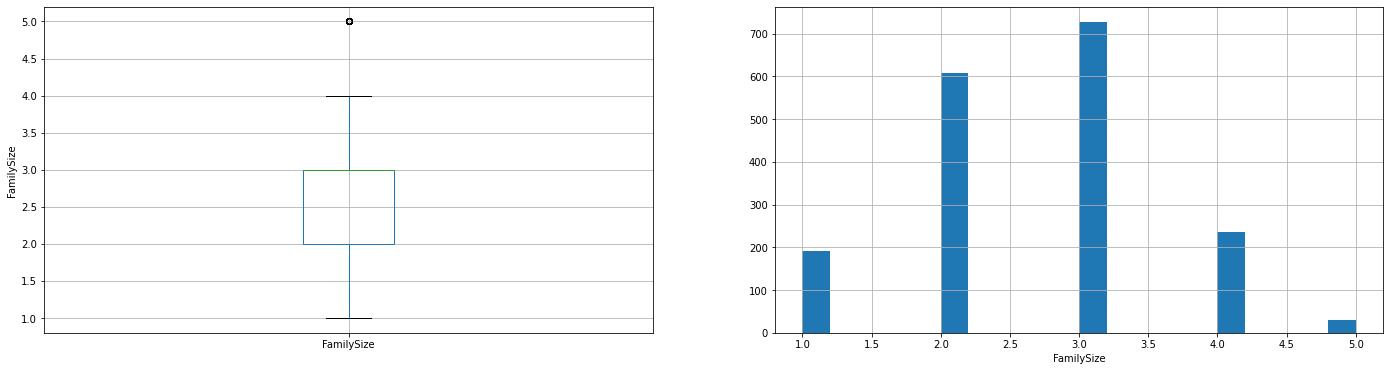

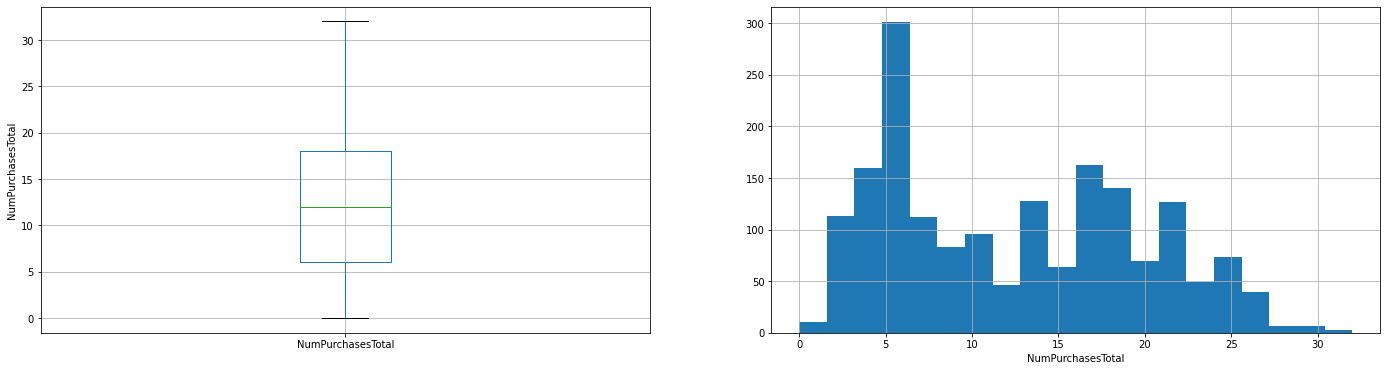

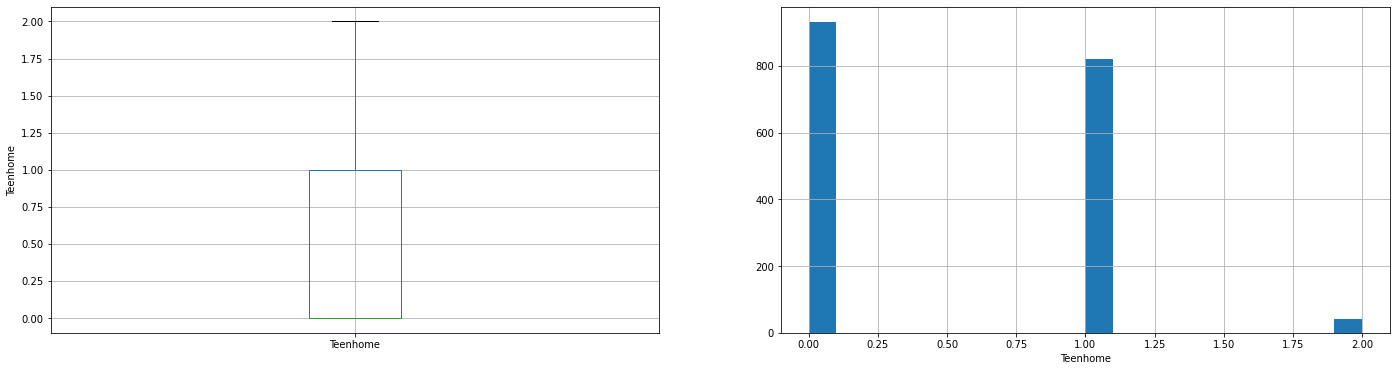

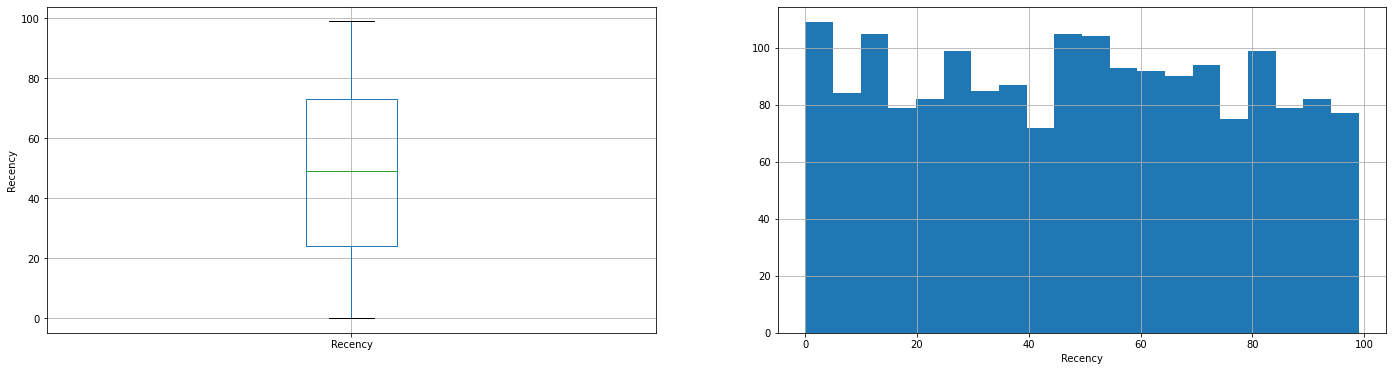

In [42]:
# let's make boxplots to visualise outliers in the variables and histograms to get an idea of the distribution

for var in continuous+discrete:
    plt.figure(figsize=(24,6))
    plt.subplot(1, 2, 1)
    fig = df2.boxplot(column=var)
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = df2[var].hist(bins=20)
    fig.set_xlabel(var)

    plt.show()

In [43]:
discrete

['NumWebVisitsMonth',
 'Kidhome',
 'NumWebPurchases',
 'NumDealsPurchases',
 'AcceptedCmpTotal',
 'NumCatalogPurchases',
 'Age',
 'NumStorePurchases',
 'FamilySize',
 'NumPurchasesTotal',
 'Teenhome',
 'Recency']

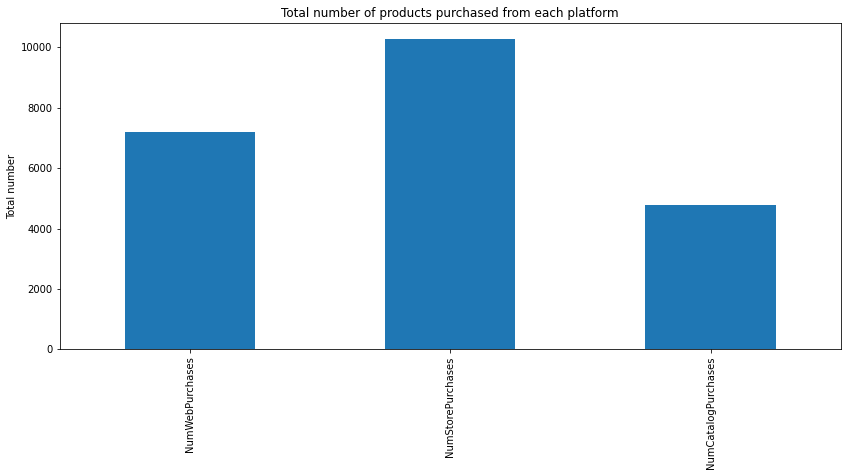

In [44]:
plt.figure(figsize=(14,6))
aux=df2[['NumWebPurchases','NumStorePurchases','NumCatalogPurchases']].sum(axis=0)
fig=aux.plot.bar()
fig.set_ylabel('Total number')
fig.set_title('Total number of products purchased from each platform');

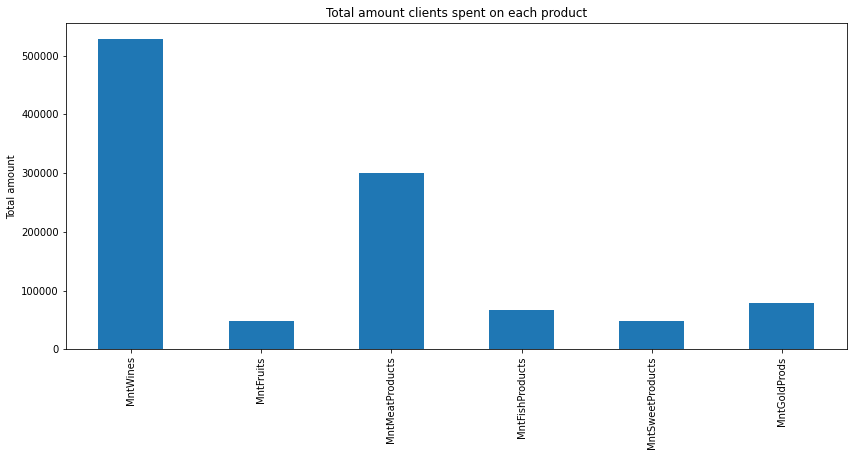

In [45]:
plt.figure(figsize=(14,6))
aux=df2[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=0)
fig=aux.plot.bar()
fig.set_ylabel('Total amount')
fig.set_title('Total amount clients spent on each product');

### Categorical

**Analysis**

* Most clients are graduated
* Most clients are married
* Past campaigns were not increasingly attracting more clients

Marital_status will need some further feature engineering to reduce cardinality

In [46]:
cat=df2[categorical].applymap(str)

Text(0, 0.5, 'Number of different categories')

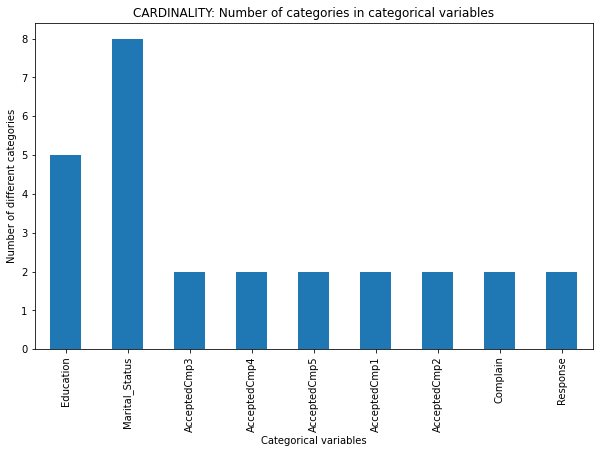

In [47]:
# plot number of categories per categorical variable
# Marital_status will need some further feature engineering to reduce cardinality
cat.nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

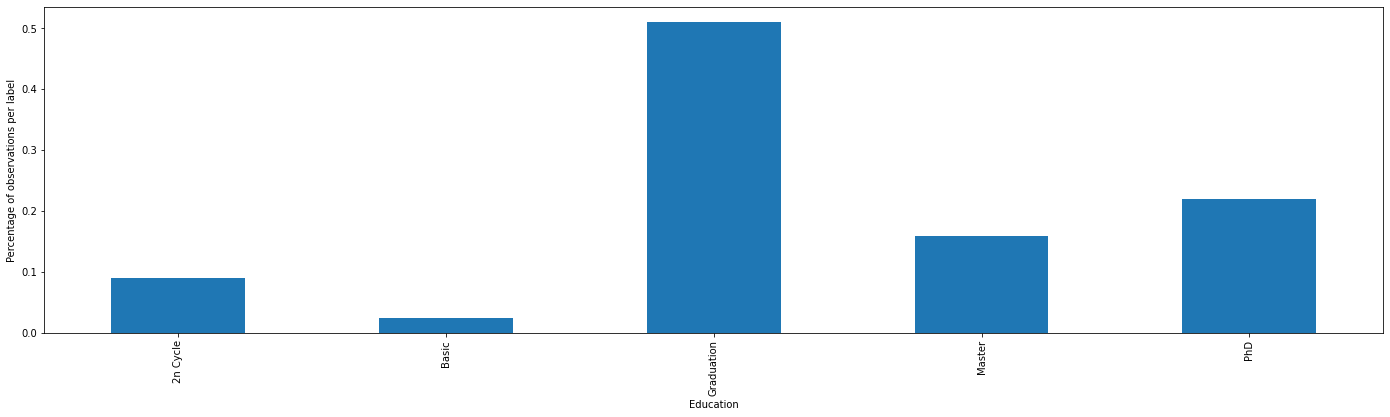

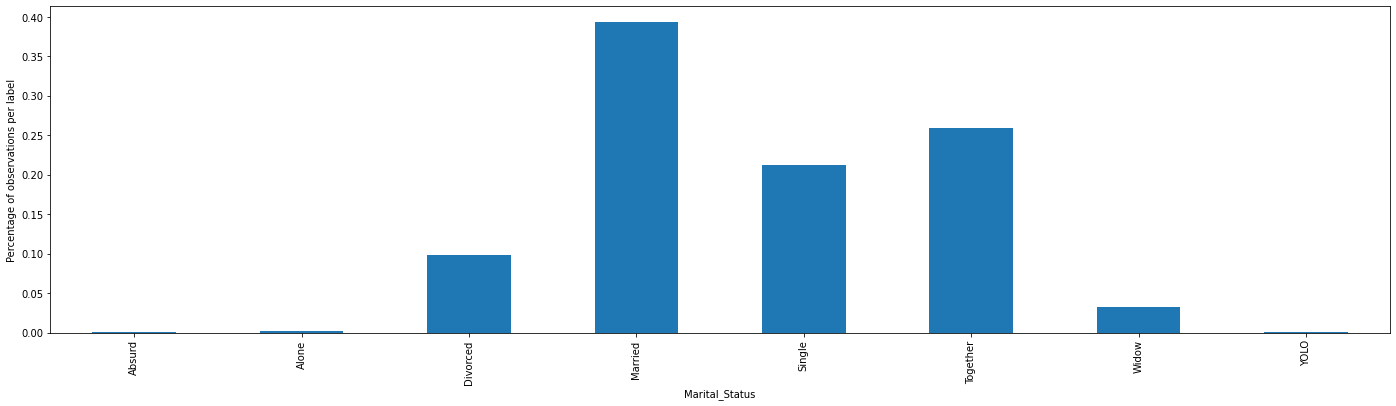

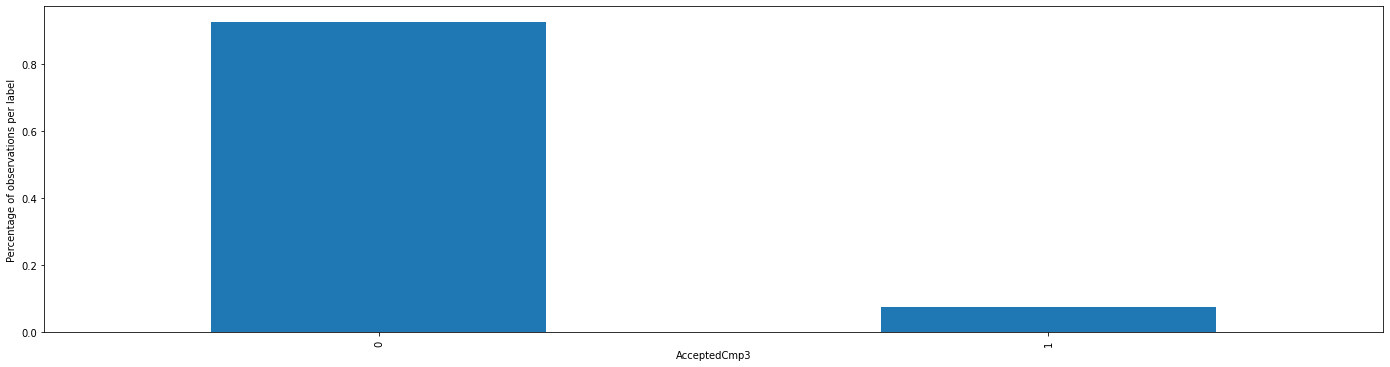

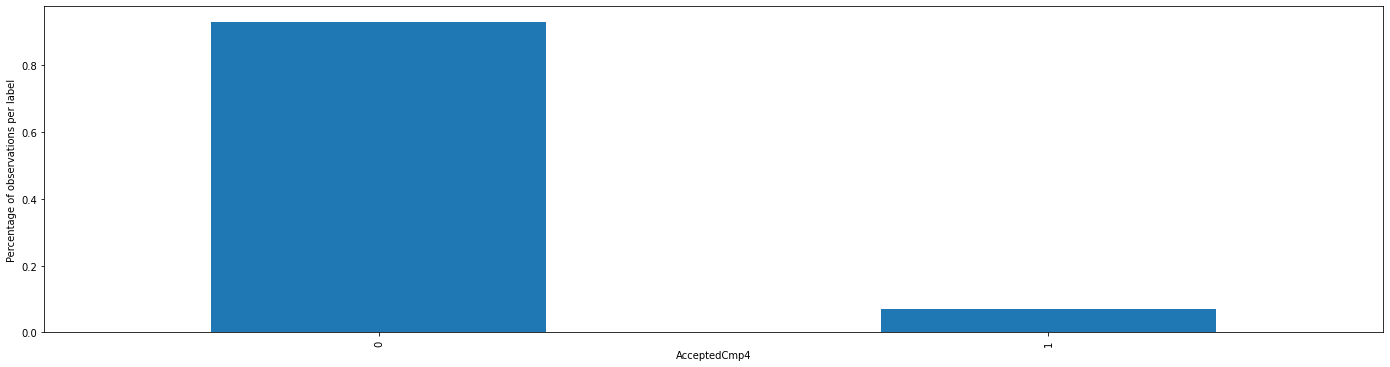

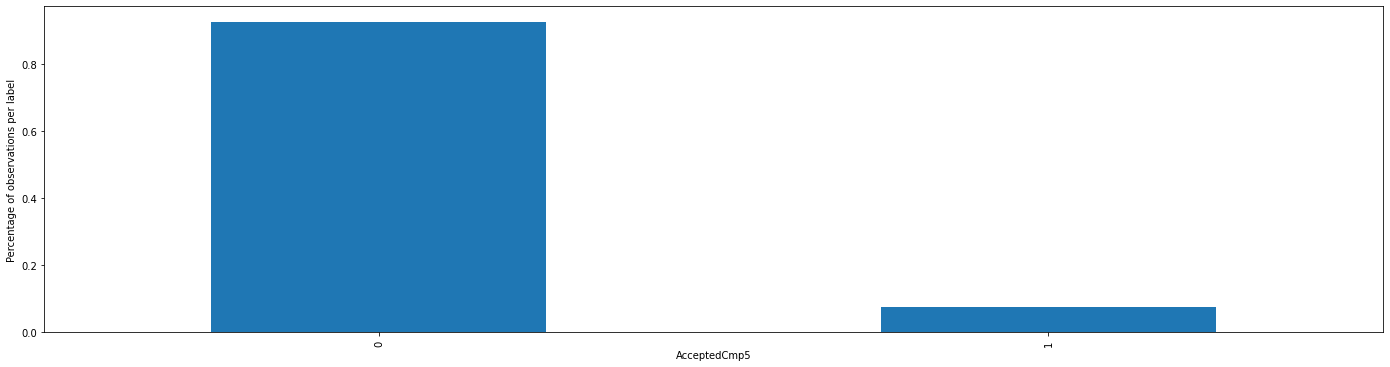

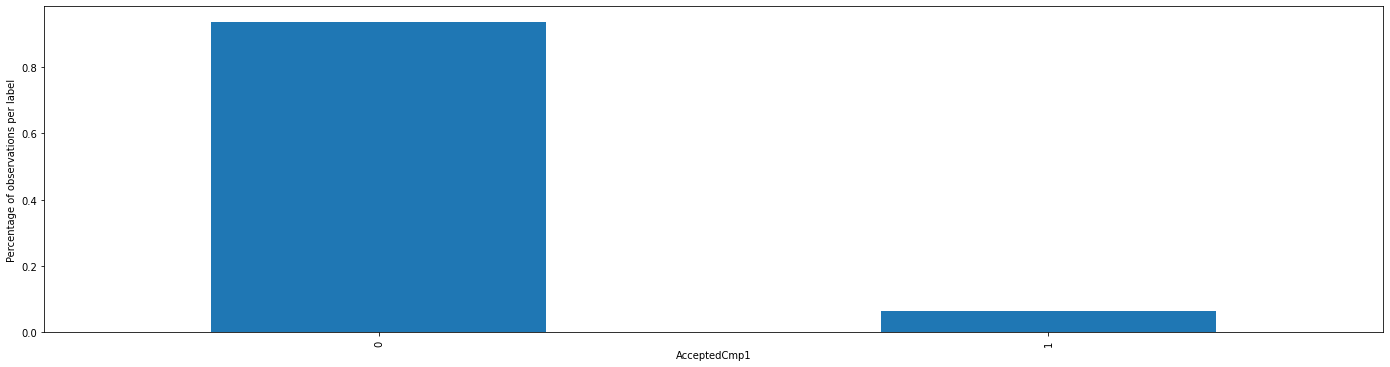

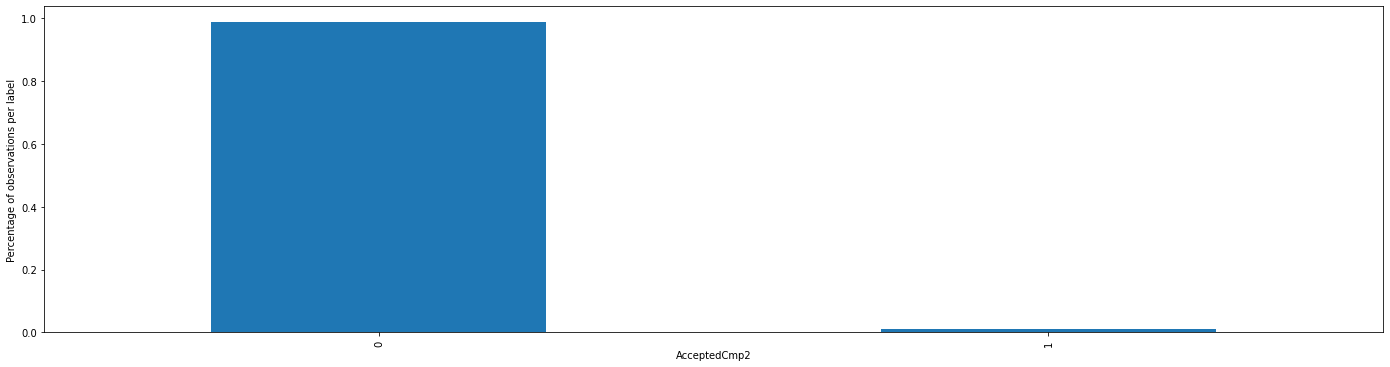

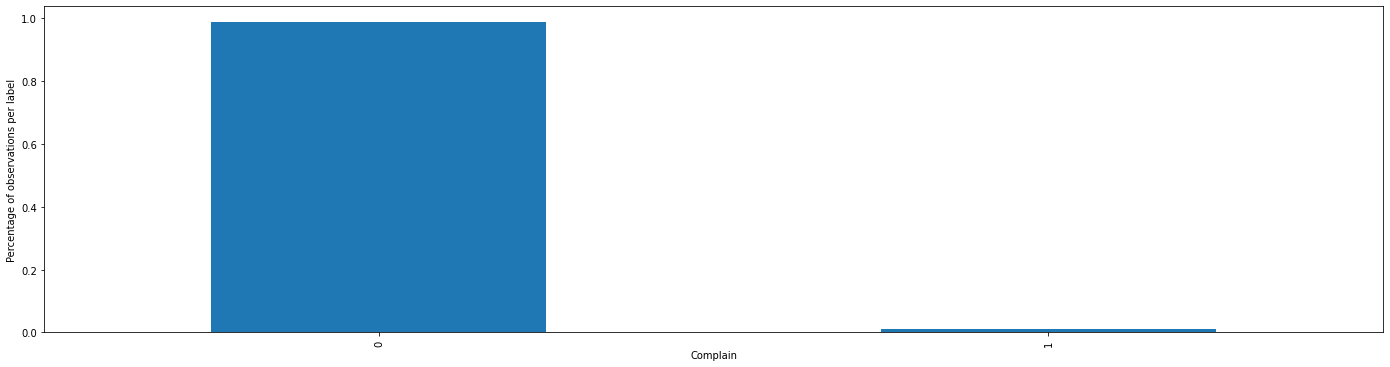

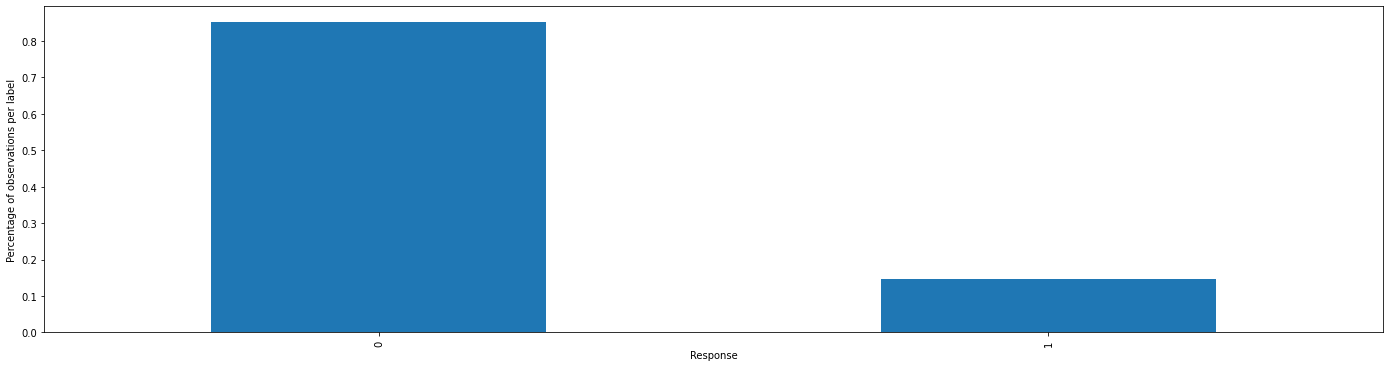

In [48]:
# outliers categorical variables
    
for var in cat.columns:
    plt.figure(figsize=(24,6))
    
    fig=(cat.groupby(var)[var].count() / np.float(len(cat))).plot.bar()
    fig.set_ylabel('Percentage of observations per label')

    plt.show()

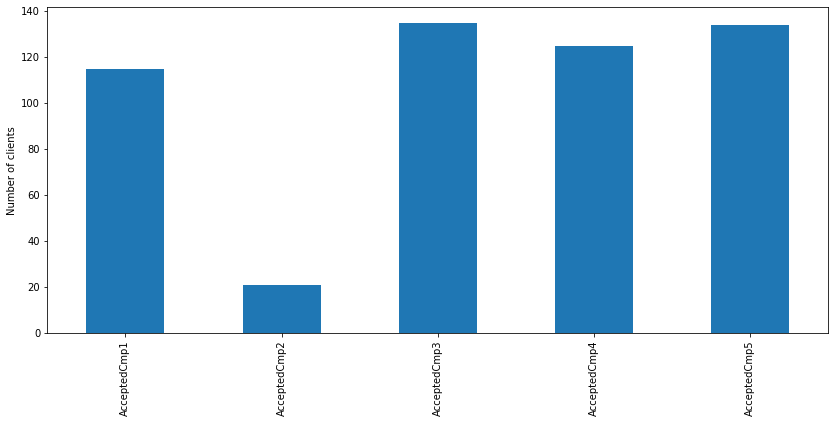

In [49]:
plt.figure(figsize=(14,6))
aux=df2[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']].sum(axis=0)
fig=aux.plot.bar()
fig.set_ylabel('Number of clients');
# fig.set_title('Were the campaigns getting better? No');

## Bivariate Analysis

In [50]:
target=cat.pop('Response')

### Continuous + discrete

**Analysis**

A simple ratio of medians from positive response to negative response show that:

Positive responders have higher:
* Income (30% more)
* amounts of products purchased (~3.6x more)
* number of products purchased from the web (66% more), catalogs (4x more) and store (50% more);

Positive responders have lower:
* days since enrollment (56% the value of negative responders),
* recency (55% the value of negative responders),
* Number of produts purchased with discount (50% the value of negative responders)
* Family size (67% the value of negative responders)

Some variables have equal medians for positive and negative responders, they are:
* age,
* number of visits to the website

Moreover, participating in campaigns in the past is a great indicator of participating in the last campaign.

In [51]:
cont=df2[continuous+discrete]

In [52]:
# lets separate between negative response and positive response
cont_negative_response=cont[df2['Response']==0]
cont_positive_response=cont[df2['Response']==1]

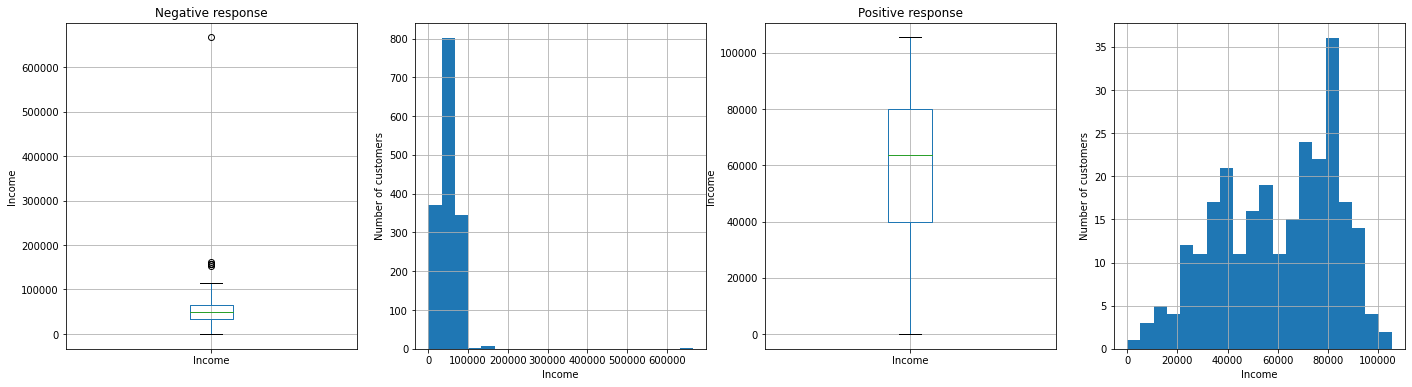

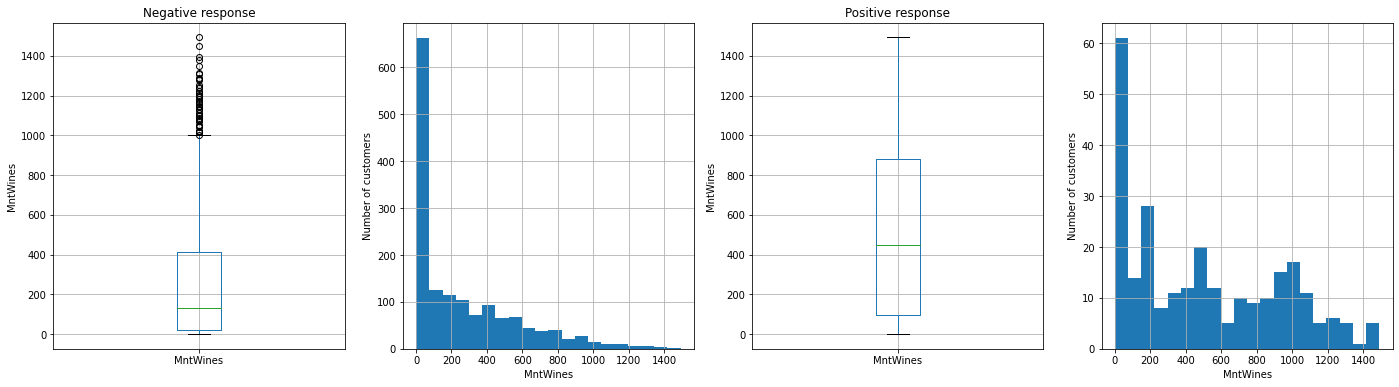

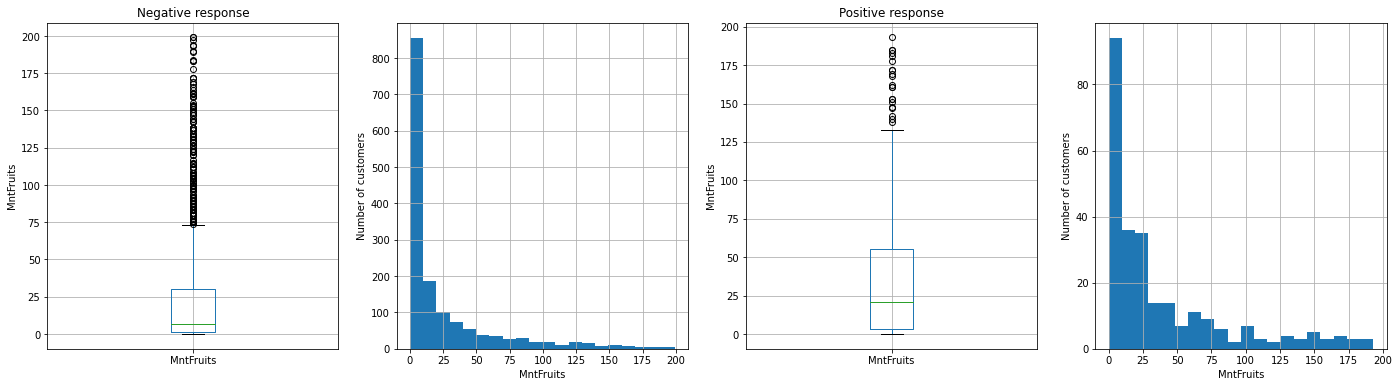

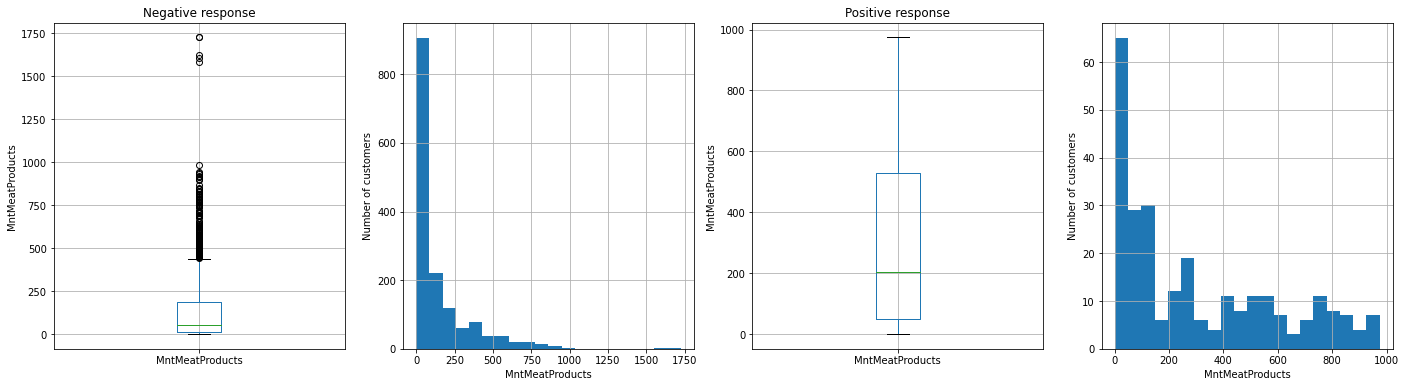

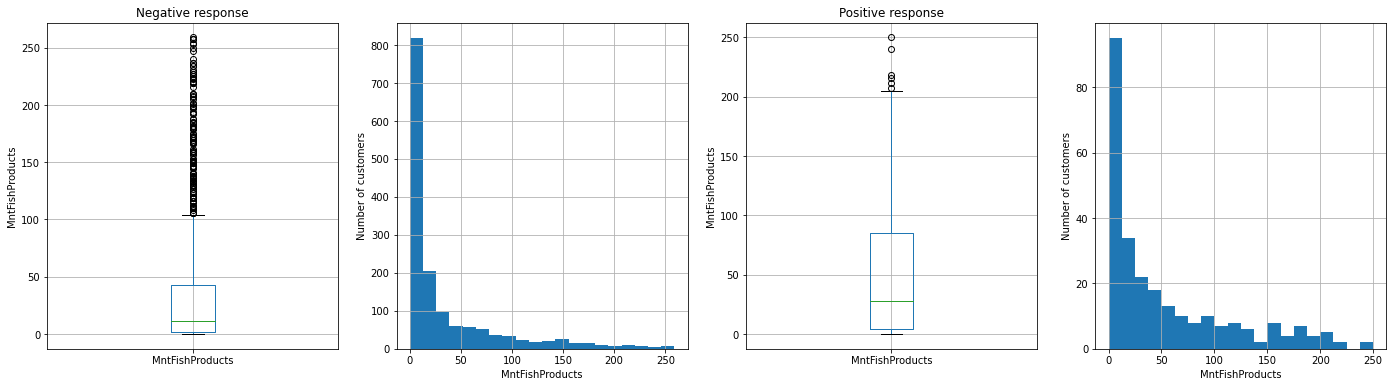

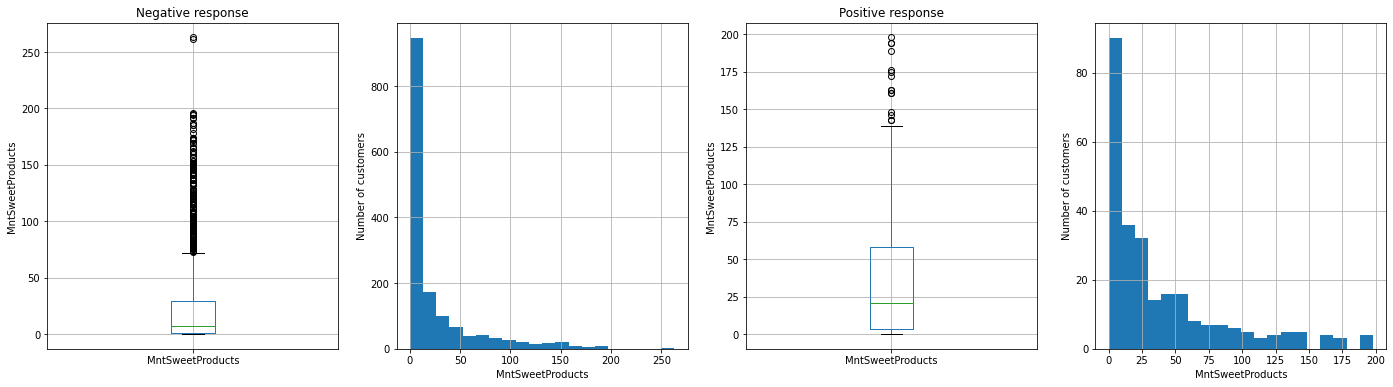

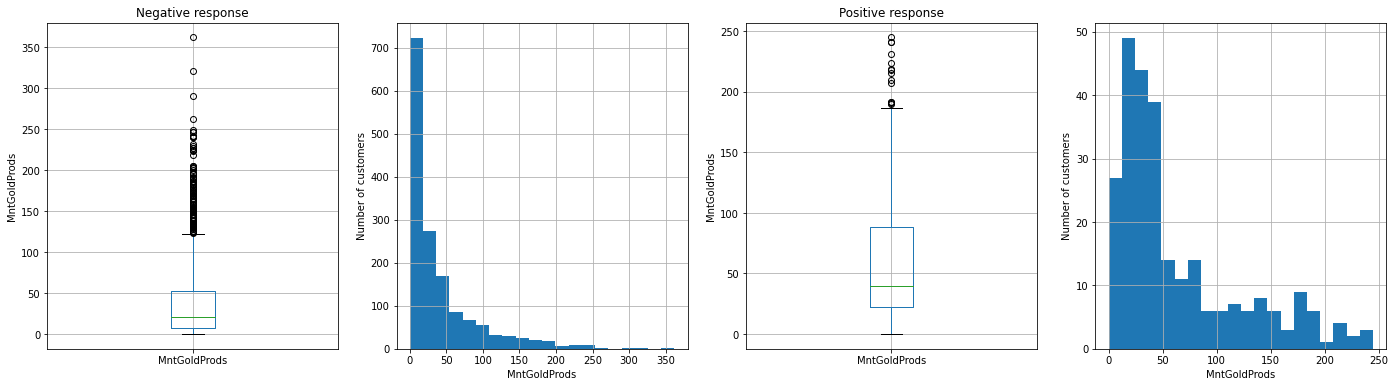

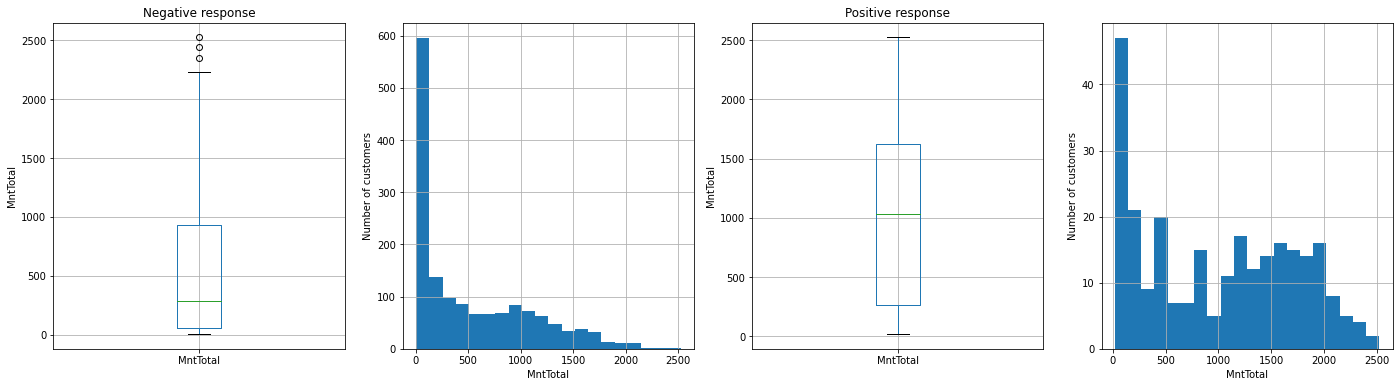

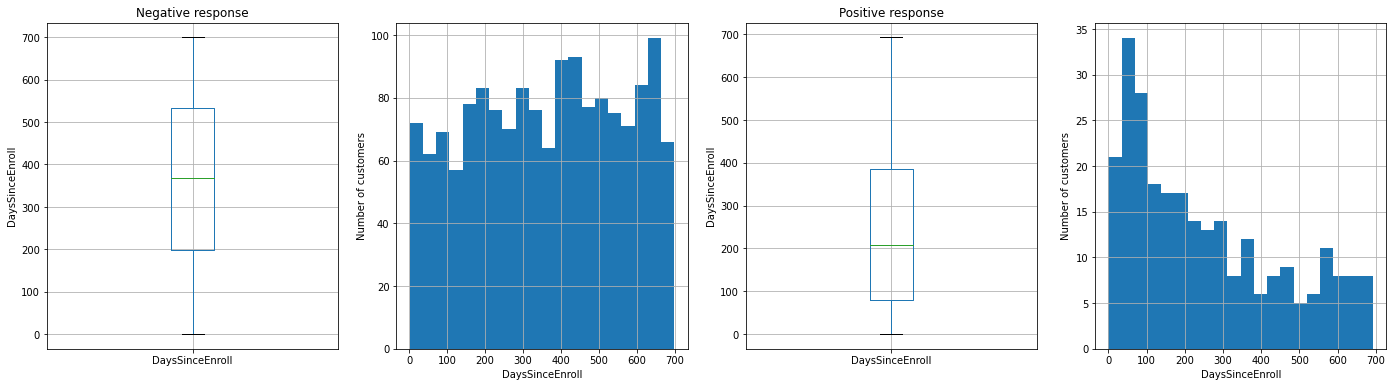

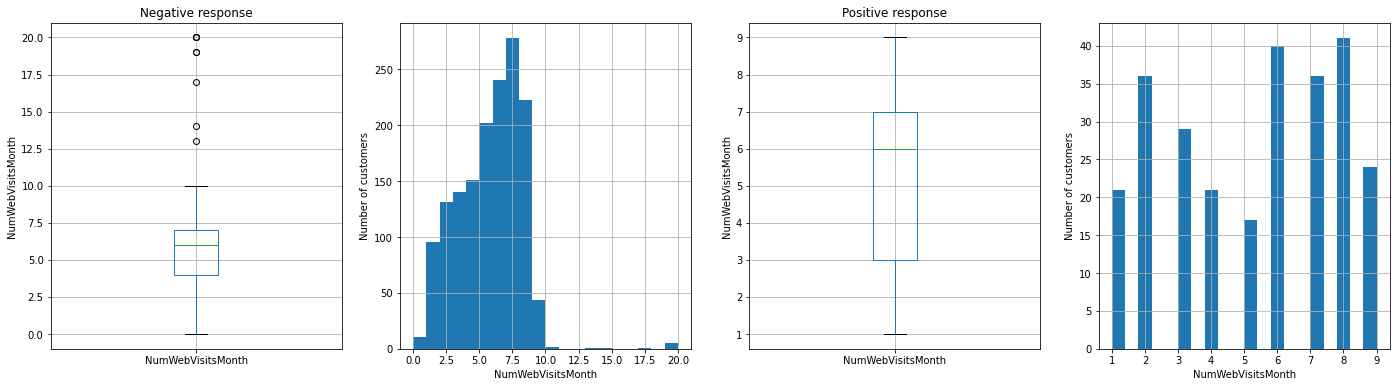

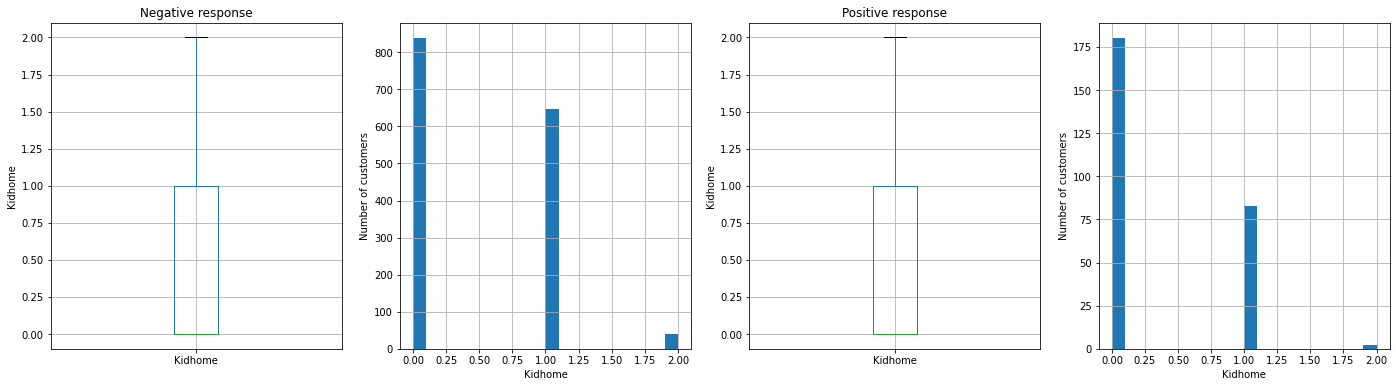

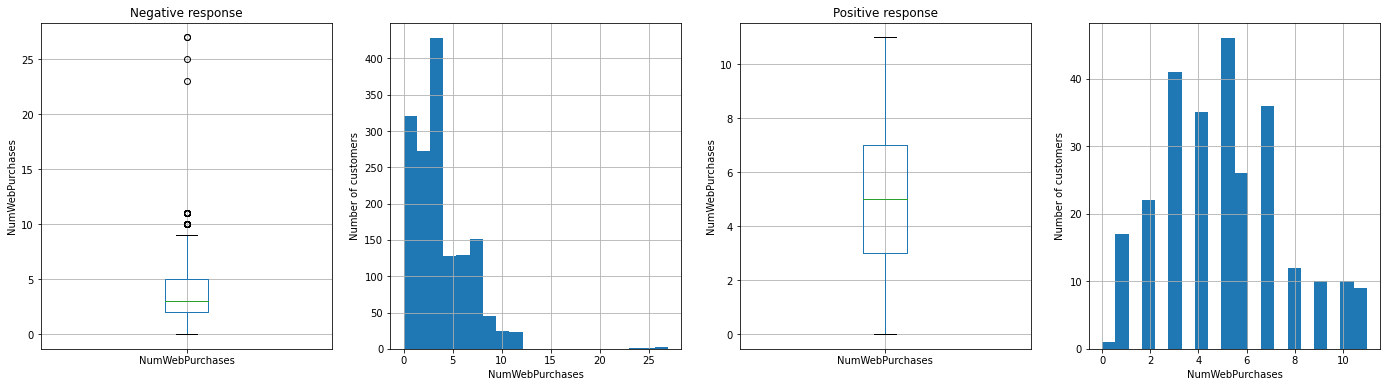

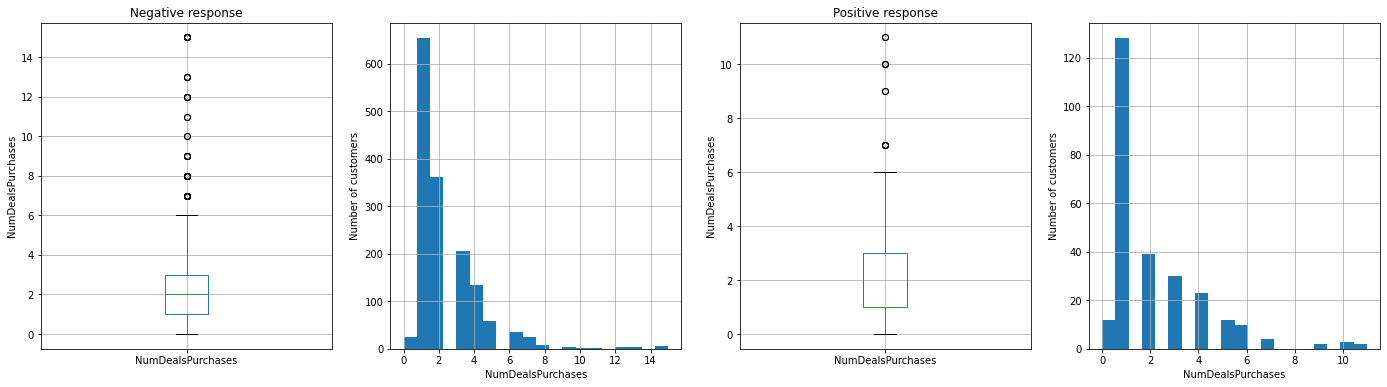

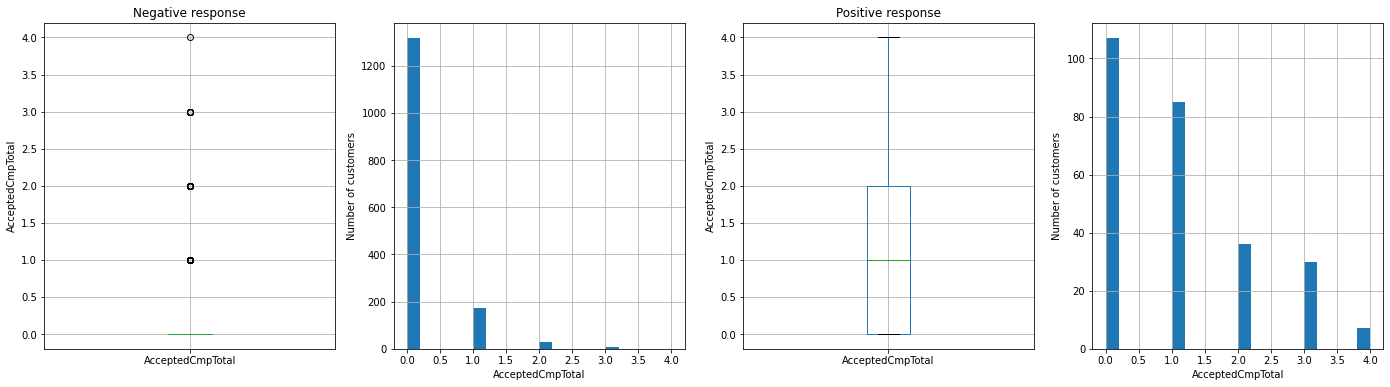

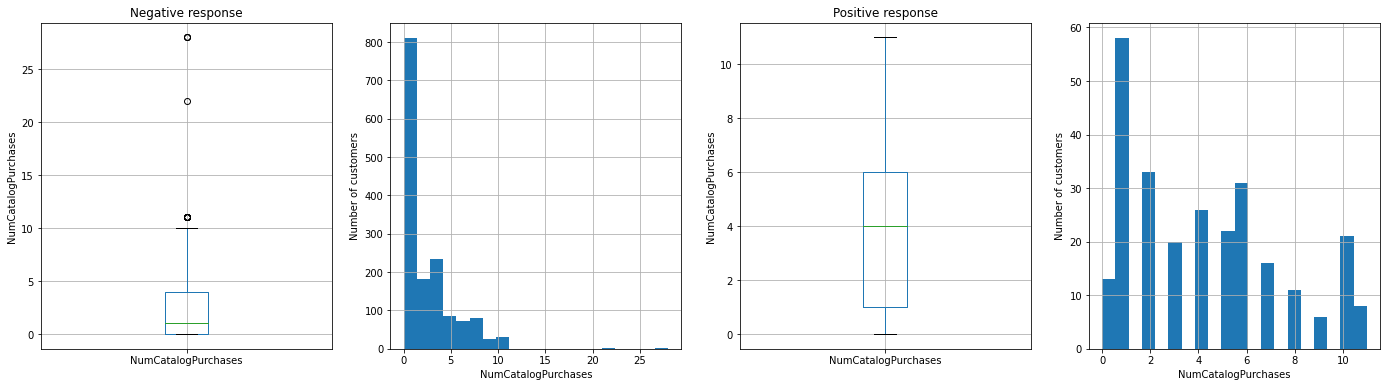

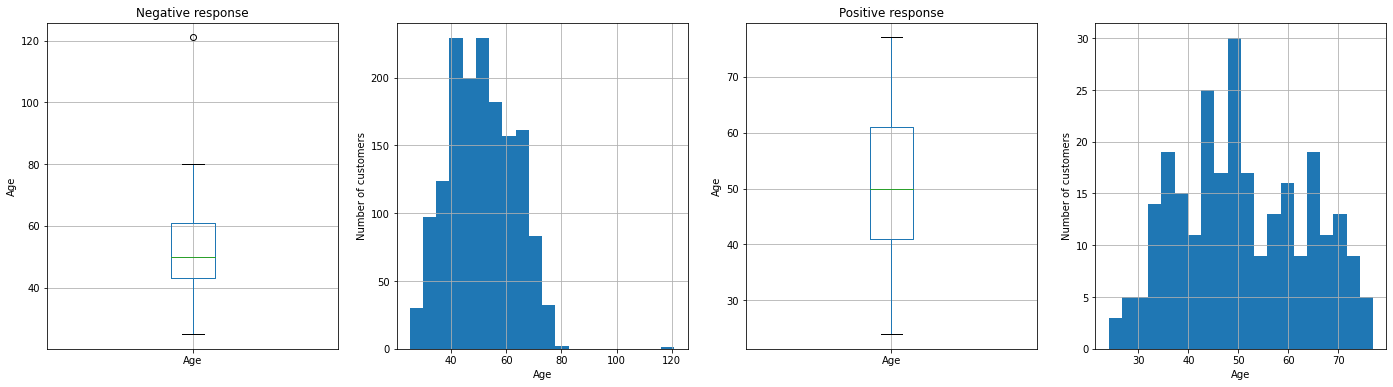

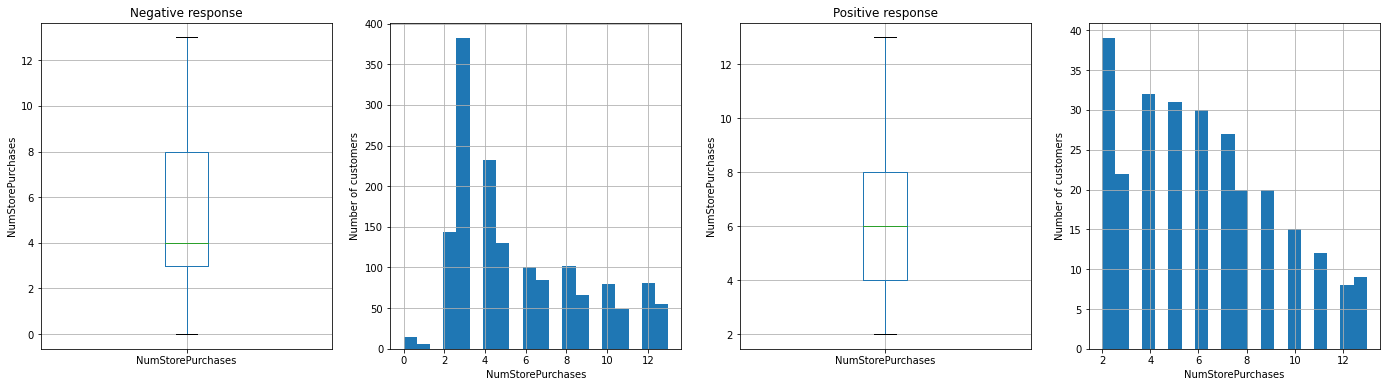

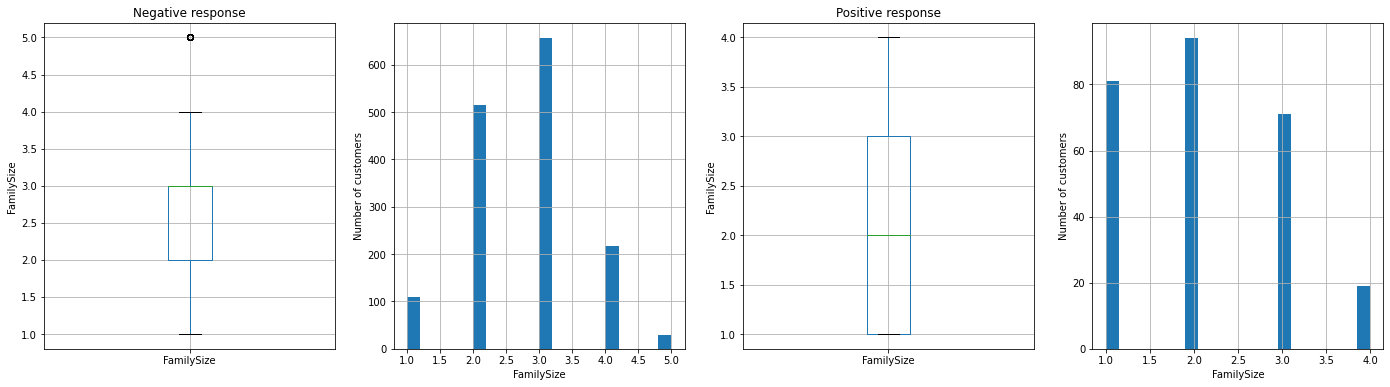

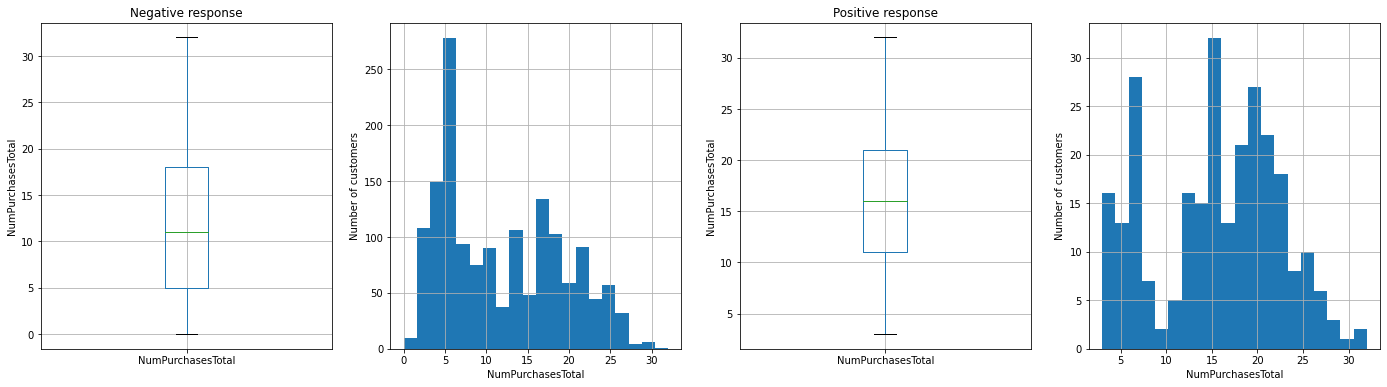

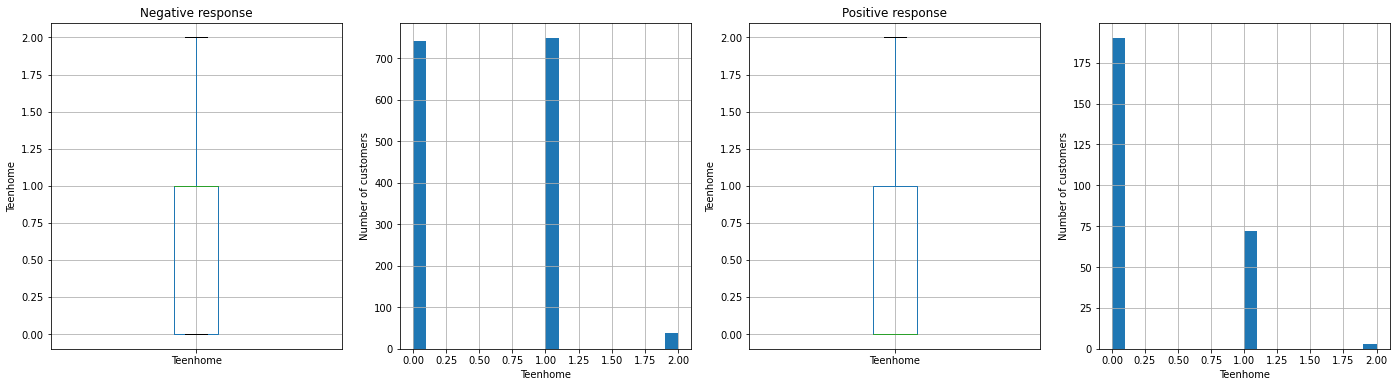

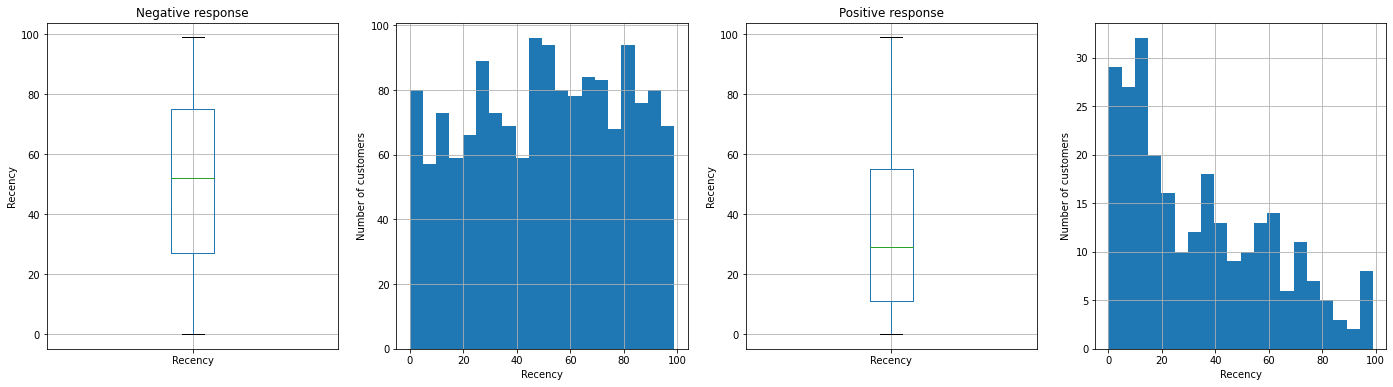

In [53]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous+discrete:
    plt.figure(figsize=(24,6))
    plt.subplot(1, 4, 1)
    fig = cont_negative_response.boxplot(column=var)
    fig.set_title('Negative response')
    fig.set_ylabel(var)
    
    plt.subplot(1, 4, 2)
    fig = cont_negative_response[var].hist(bins=20)
    fig.set_ylabel('Number of customers')
    fig.set_xlabel(var)
    
    plt.subplot(1, 4, 3)
    fig = cont_positive_response.boxplot(column=var)
    fig.set_title('Positive response')
    fig.set_ylabel(var)
    
    plt.subplot(1, 4, 4)
    fig = cont_positive_response[var].hist(bins=20)
    fig.set_ylabel('Number of customers')
    fig.set_xlabel(var)

    plt.show()

In [54]:
# ratio of medians from positive response to negative response
ratio=cont_positive_response.median()/cont_negative_response.median()
ratio=ratio.apply(lambda x: round(x,2))

# A simple ratio of medians from positive response to negative response show that:
# Positive responders have higher:
# Income (30%), amounts of products purchased (3.6x),
# number of products purchased from the web (66%), catalogs (4x) and store (50%);
# and also positive responders have lower:
# days since enrollment (56%), recency (55%), Number of produts purchased with discount (50%)
# Moreover some variables have equal medians for positive and negative responders, they are:
# age, number of visits to the website


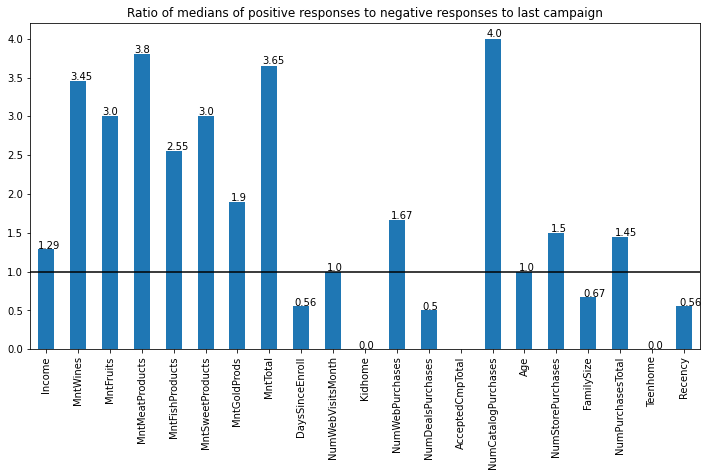

In [55]:
ax=ratio.plot.bar(title='Ratio of medians of positive responses to negative responses to last campaign',figsize=(12,6));
plt.axhline(y=1, color='k', linestyle='-')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [56]:
# aux=pd.concat([cont_negative_response['AcceptedCmpTotal'].value_counts()/df2['AcceptedCmpTotal'].value_counts(),
#                 cont_positive_response['AcceptedCmpTotal'].value_counts()/df2['AcceptedCmpTotal'].value_counts()],axis=1)
# aux.index.name = 'Number of accepted responses in the past'
# aux.columns = ['ratio of negative vs total responses to current campaign','ratio of postive vs total responses to current campaign']
# aux

In [57]:
ratio=(cont_positive_response['AcceptedCmpTotal'].value_counts()/df2['AcceptedCmpTotal'].value_counts())*100
ratio

0     7.514045
1    32.945736
2    54.545455
3    83.333333
4    87.500000
Name: AcceptedCmpTotal, dtype: float64

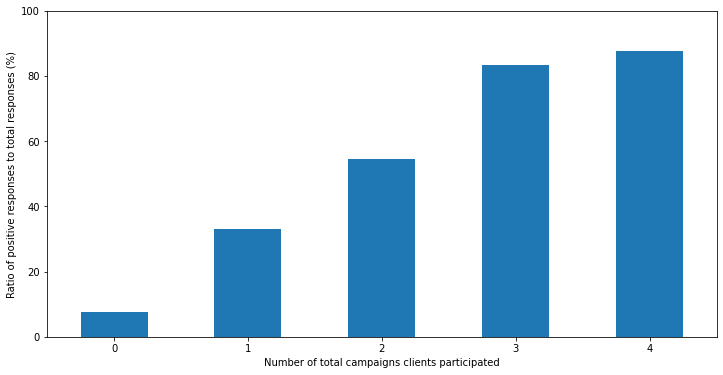

In [58]:
plt.figure(figsize=(12, 6))
fig=ratio.plot.bar()
fig.set_xticklabels(np.arange(0,5),rotation=0)
# fig.set_xlim(0,4)
fig.set_ylim(0,100)
fig.set_xlabel('Number of total campaigns clients participated')
fig.set_ylabel('Ratio of positive responses to total responses (%)');

In [59]:
aux=df2[['NumWebPurchases','NumStorePurchases','NumCatalogPurchases','Response']].groupby(['Response']).sum()
aux=pd.DataFrame(aux.unstack()).reset_index()
aux.columns=['Purchase Type','Response','TotalAmount']
aux

Purchase Type  Response  TotalAmount
0      NumWebPurchases         0         5844
1      NumWebPurchases         1         1347
2    NumStorePurchases         0         8655
3    NumStorePurchases         1         1631
4  NumCatalogPurchases         0         3636
5  NumCatalogPurchases         1         1136

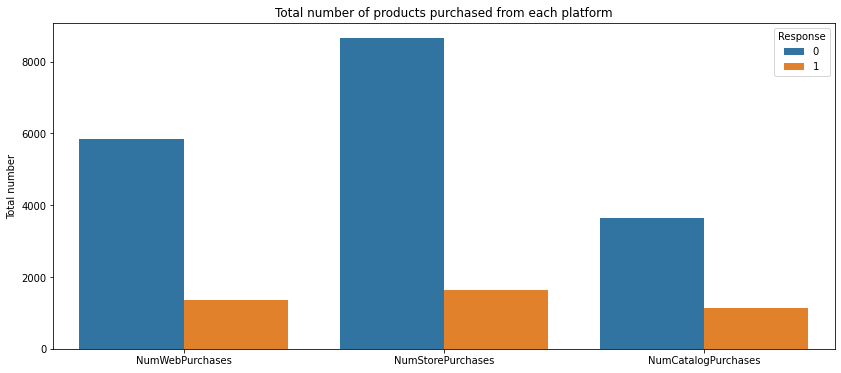

In [60]:
plt.figure(figsize=(14,6))
fig=sns.barplot(x='Purchase Type',y='TotalAmount',data=aux,hue='Response',estimator=sum)
fig.set_ylabel('Total number')
fig.set_xlabel('')
fig.set_title('Total number of products purchased from each platform');

In [61]:
aux=df2[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','Response']].groupby(['Response']).sum()
aux=pd.DataFrame(aux.unstack()).reset_index()
aux.columns=['Product','Response','TotalAmount']
aux

Product  Response  TotalAmount
0           MntWines         0       396717
1           MntWines         1       132063
2          MntFruits         0        37302
3          MntFruits         1        10320
4    MntMeatProducts         0       219390
5    MntMeatProducts         1        80210
6    MntFishProducts         0        53096
7    MntFishProducts         1        14032
8   MntSweetProducts         0        37962
9   MntSweetProducts         1        10428
10      MntGoldProds         0        61423
11      MntGoldProds         1        16906

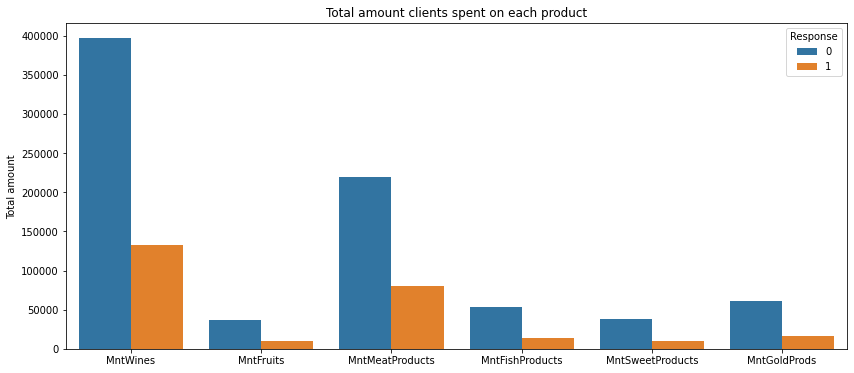

In [62]:
plt.figure(figsize=(14,6))
fig=sns.barplot(x='Product',y='TotalAmount',data=aux,hue='Response',estimator=sum)
fig.set_ylabel('Total amount')
fig.set_xlabel('')
fig.set_title('Total amount clients spent on each product');

### Categorical

**Analysis**
* Education plays only a minor role, having a higher education increases chance of positive response
* Being single increases chance of accepting last campaign
* Past complaints does't play an important role
* Having participated in any of the 5 campaigns had a significant role on participating in the last one

In [63]:
# lets separate between fraud and not fraud
cat_negative_response=cat[df2['Response']==0]
cat_positive_response=cat[df2['Response']==1]

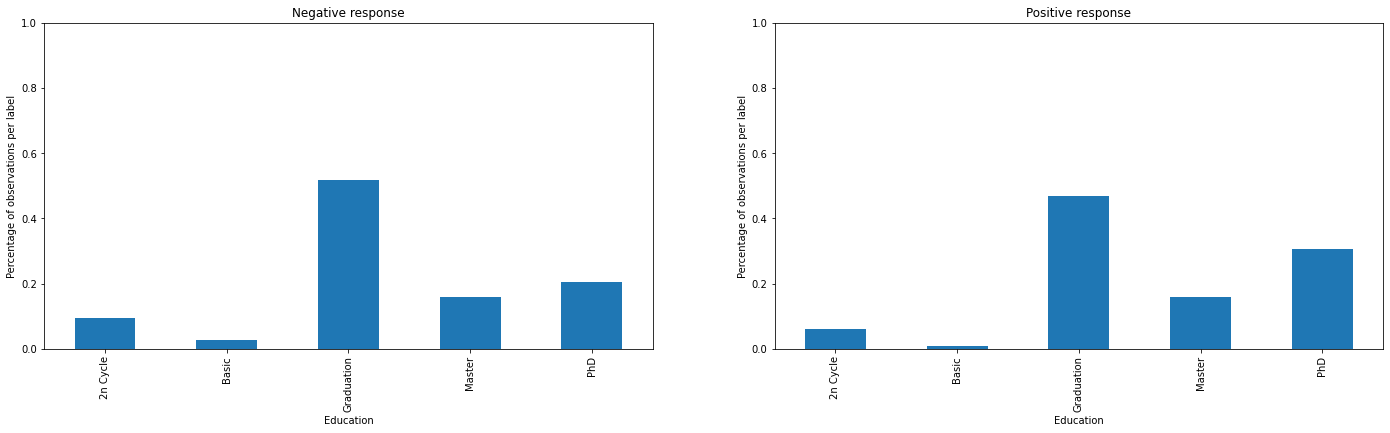

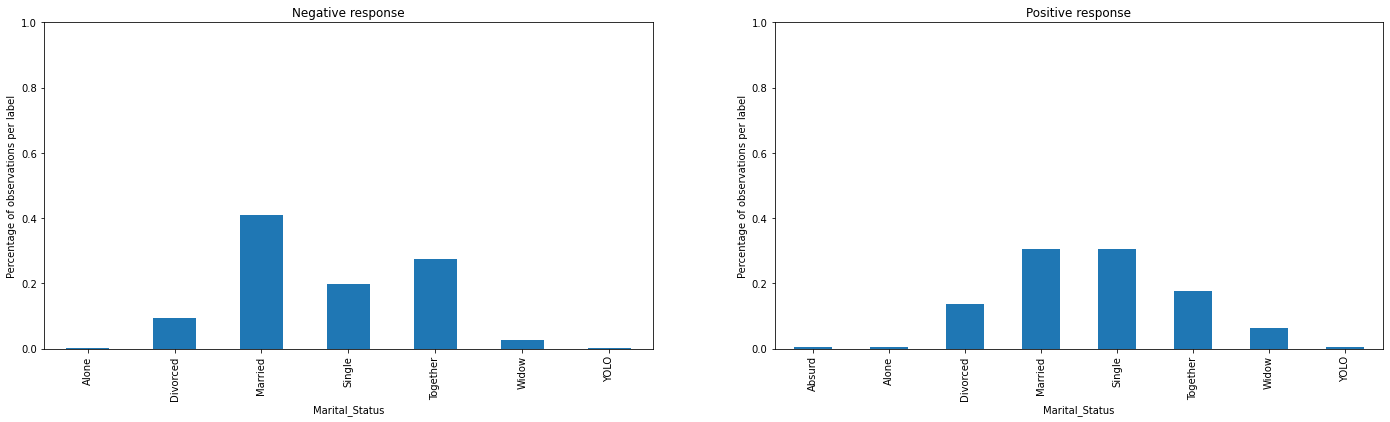

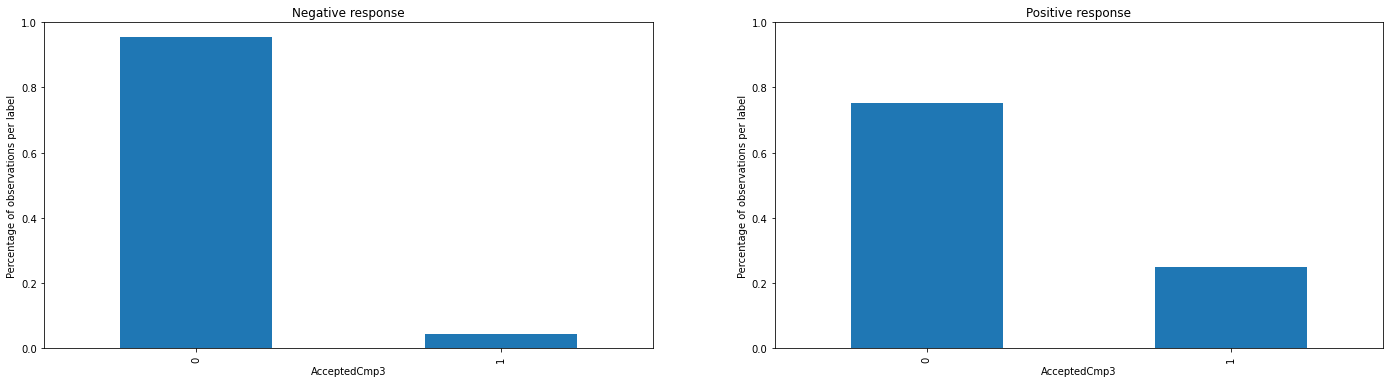

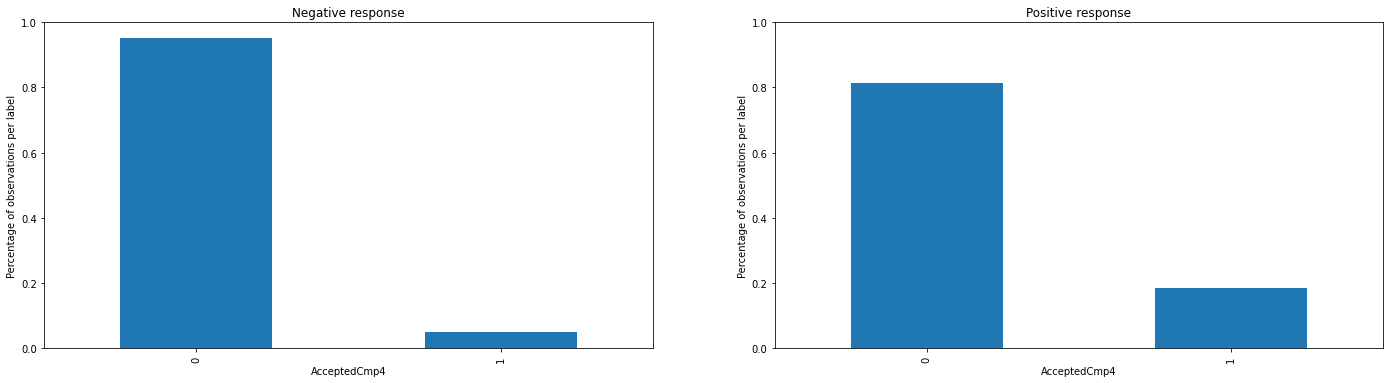

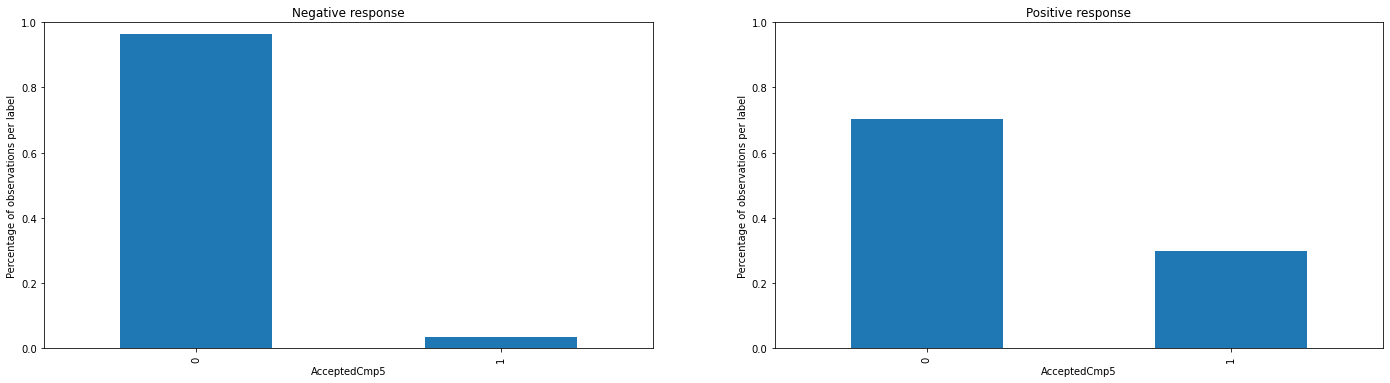

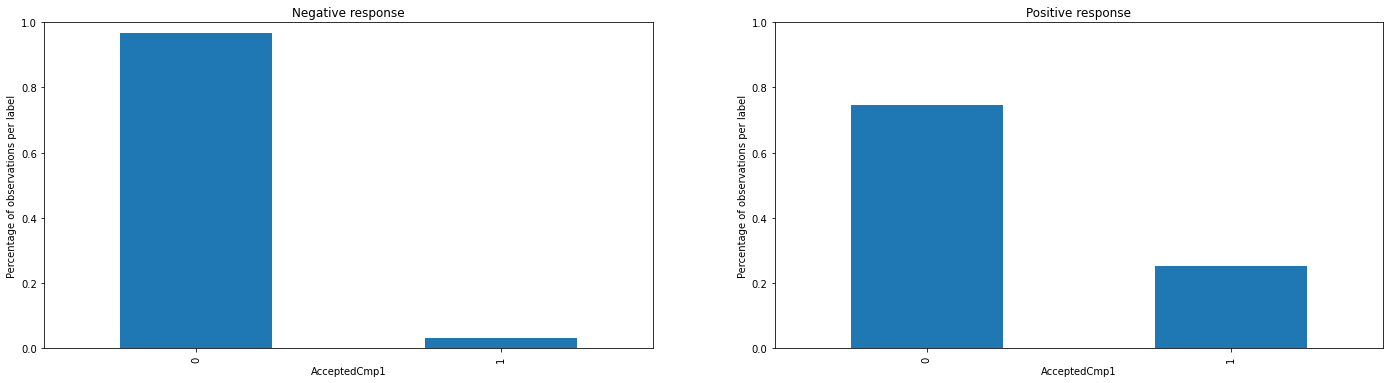

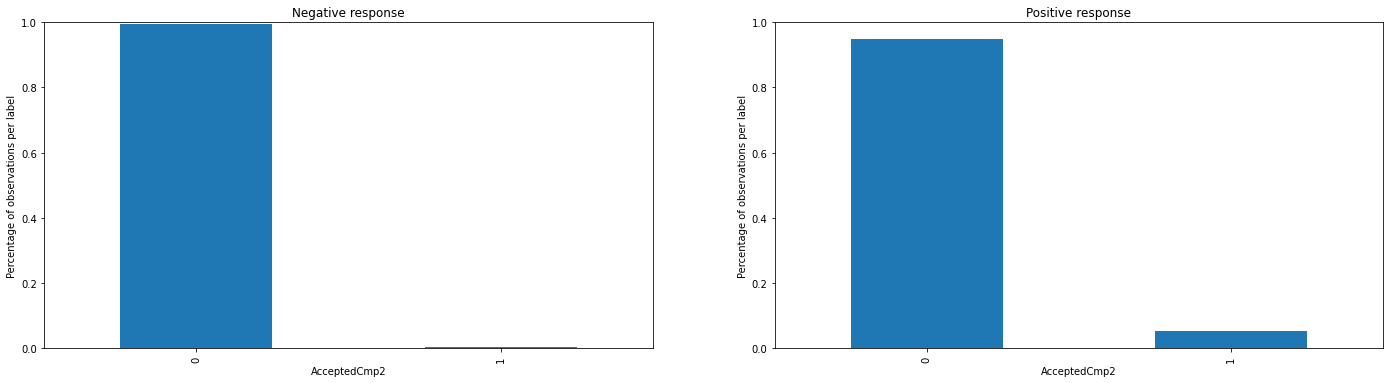

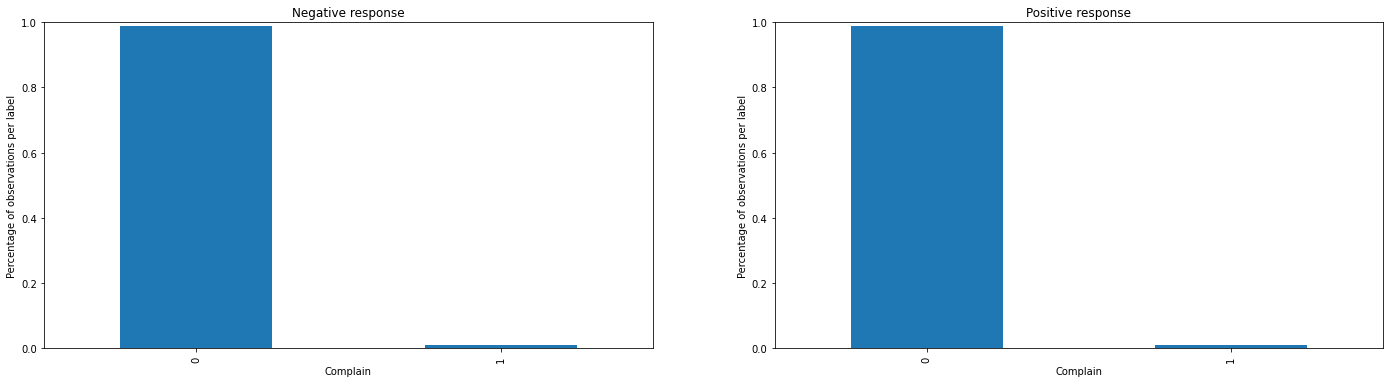

In [64]:
# outliers in discrete and categorical variables
    
for var in cat.columns:
    plt.figure(figsize=(24,6))
    
    plt.subplot(1, 2, 1)
    fig=(cat_negative_response.groupby(var)[var].count() / np.float(len(cat_negative_response))).plot.bar()
    fig.set_ylabel('Percentage of observations per label')
    fig.set_title('Negative response')
    fig.set_ylim(0,1)
    
    plt.subplot(1, 2, 2)
    fig=(cat_positive_response.groupby(var)[var].count() / np.float(len(cat_positive_response))).plot.bar()
    fig.set_ylabel('Percentage of observations per label')
    fig.set_title('Positive response')
    fig.set_ylim(0,1)
    
    plt.show()

In [65]:
# outliers in discrete and categorical variables
aux=pd.DataFrame()
for var in cat.columns.sort_values():
    aux=pd.concat([aux,(cat_positive_response.groupby(var)[var].count() / np.float(len(cat_positive_response)))/(cat_negative_response.groupby(var)[var].count() / np.float(len(cat_negative_response)))],axis=0)

In [66]:
aux.index=['0', 'Accepted campaign 1', '0', 'Accepted campaign 2', '0', 'Accepted campaign 3', '0', 'Accepted campaign 4',
           '0', 'Accepted campaign 5', '0', 'Complained in the past', '2n Cycle',
       'Basic', 'Graduation', 'Master', 'PhD', 'Absurd', 'Alone', 'Divorced',
       'Married', 'Single', 'Together', 'Widow', 'YOLO']
aux=aux.drop(labels='0',axis=0)
aux=aux.apply(lambda x: round(x,2))

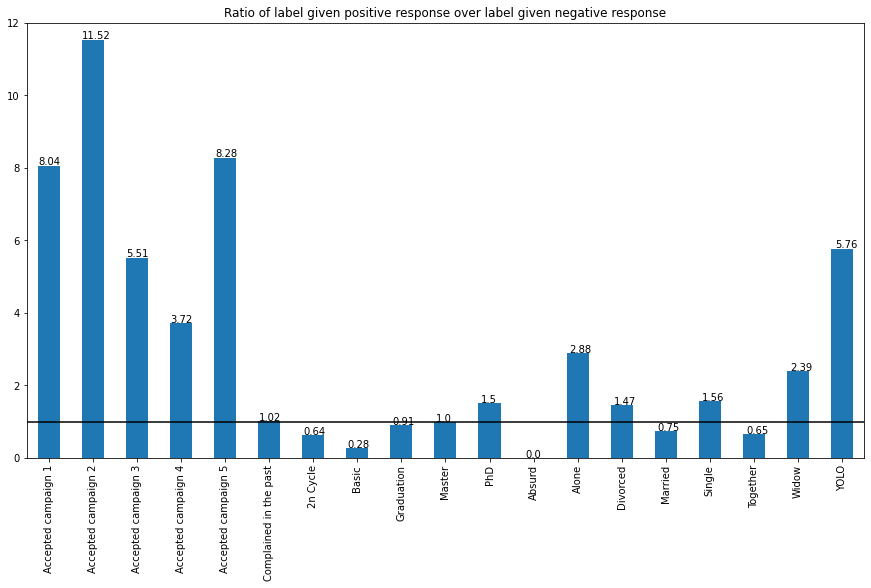

In [67]:
# plt.figure(figsize=(15,8))
fig=aux.plot.bar(figsize=(15,8),legend=False)
# fig.set_ylabel('Given positive response to ratio of count of given label on positive set over count of given label on negative set')
fig.set_title('Ratio of label given positive response over label given negative response')
fig.set_ylim(0,12)
# fig.set_legend('')
plt.axhline(y=1, color='k', linestyle='-')
for p in fig.patches:
    fig.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [68]:
aux=df2[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response']].groupby(['Response']).sum()
aux=pd.DataFrame(aux.unstack()).reset_index()
aux.columns=['AcceptedCmp','Response','Total']
aux

AcceptedCmp  Response  Total
0  AcceptedCmp1         0     48
1  AcceptedCmp1         1     67
2  AcceptedCmp2         0      7
3  AcceptedCmp2         1     14
4  AcceptedCmp3         0     69
5  AcceptedCmp3         1     66
6  AcceptedCmp4         0     76
7  AcceptedCmp4         1     49
8  AcceptedCmp5         0     55
9  AcceptedCmp5         1     79

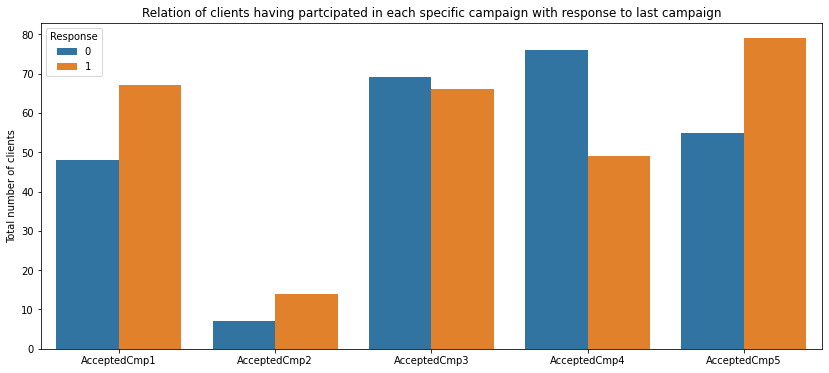

In [69]:
plt.figure(figsize=(14,6))
fig=sns.barplot(x='AcceptedCmp',y='Total',data=aux,hue='Response',estimator=sum)
fig.set_ylabel('Total number of clients')
fig.set_xlabel('')
fig.set_title('Relation of clients having partcipated in each specific campaign with response to last campaign');

In [70]:
aux=pd.DataFrame(pd.crosstab( df2['Marital_Status'], df2['Response'] ).stack()).reset_index()
aux.columns=['Marital Status','Response','Total']
aux

Marital Status  Response  Total
0          Absurd         0      0
1          Absurd         1      1
2           Alone         0      2
3           Alone         1      1
4        Divorced         0    141
5        Divorced         1     36
6         Married         0    624
7         Married         1     81
8          Single         0    300
9          Single         1     81
10       Together         0    418
11       Together         1     47
12          Widow         0     41
13          Widow         1     17
14           YOLO         0      1
15           YOLO         1      1

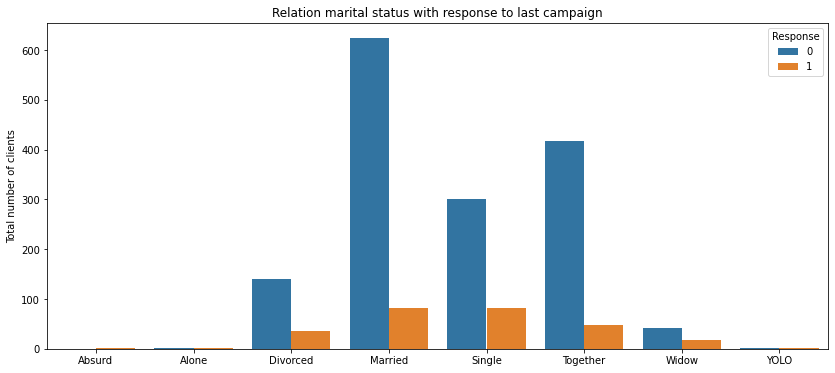

In [71]:
plt.figure(figsize=(14,6))
fig=sns.barplot(x='Marital Status',y='Total',data=aux,hue='Response',estimator=sum)
fig.set_ylabel('Total number of clients')
fig.set_xlabel('')
fig.set_title('Relation marital status with response to last campaign');

In [72]:
# aux1=aux.groupby('Marital Status').sum()['Total']
# aux1=pd.merge(aux,aux1,how='left',on='Marital Status')
# aux1['Total(%)']

In [73]:
aux=pd.DataFrame(pd.crosstab( df2['Education'], df2['Response'] ).stack()).reset_index()
aux.columns=['Education','Response','Total']
aux

Education  Response  Total
0    2n Cycle         0    144
1    2n Cycle         1     16
2       Basic         0     41
3       Basic         1      2
4  Graduation         0    789
5  Graduation         1    124
6      Master         0    242
7      Master         1     42
8         PhD         0    311
9         PhD         1     81

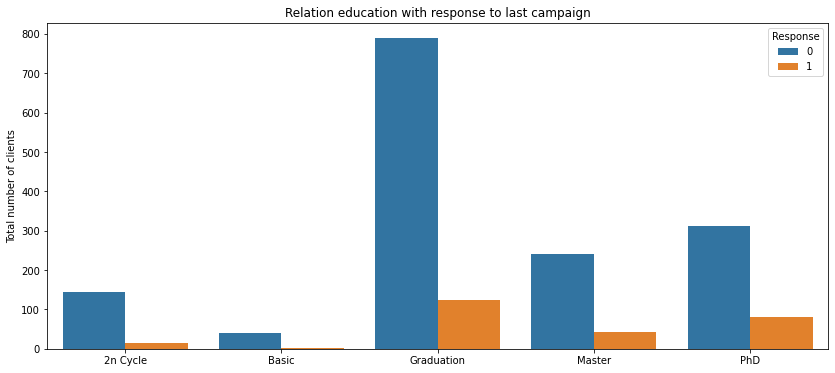

In [74]:
plt.figure(figsize=(14,6))
fig=sns.barplot(x='Education',y='Total',data=aux,hue='Response',estimator=sum)
fig.set_ylabel('Total number of clients')
fig.set_xlabel('')
fig.set_title('Relation education with response to last campaign');

In [75]:
# aux=pd.get_dummies(df2[categorical])
# aux=aux.groupby(['Response']).sum()
# aux=pd.DataFrame(aux.unstack()).reset_index()
# aux.columns=['Var','Response','Total']
# # aux[aux['Response']==1]['Total']/aux[aux['Response']==0]['Total']
# pos=aux[aux['Response']==1][['Var','Total']].reset_index(drop=True)
# neg=aux[aux['Response']==0][['Var','Total']].reset_index(drop=True)

## Multivariate Analysis

### Pearson correlation

**Analysis**
Interesiting strong postive correlations:
* Target and number of campaigns accepted in the past
* Income and total amount spent or number of products purchased

Interesiting strong negative correlations:
* Target and family size
* Target and days since erollment
* Total amount spent and family size
* Total amount spent and visits to the website

Surprisingly low correlation with:
* Number of past complaints with any other variable

<AxesSubplot:>

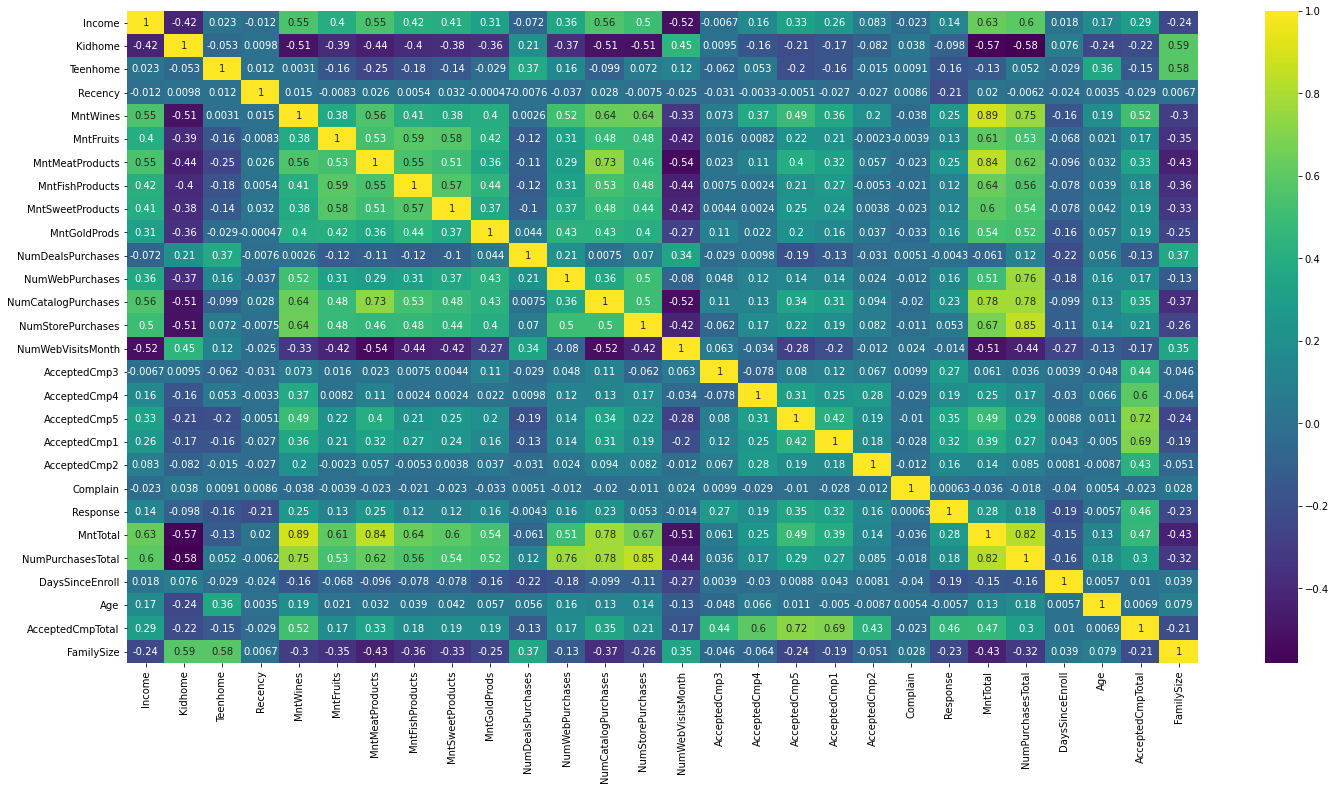

In [76]:
plt.figure(figsize=(24,12))
sns.heatmap(df2.corr(method='pearson'),cmap='viridis',annot=True)

### Cramer-v categorical correlation

**Analysis**

Interesiting strong correlations:
* Age and education and marital status


In [77]:
aux=df2[categorical+discrete].applymap(str)

In [78]:
cat_attributes_list = aux.columns

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v( aux[ ref ], aux[ feat ] )
        
        # append a list
        corr_list.append( corr )
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

<AxesSubplot:>

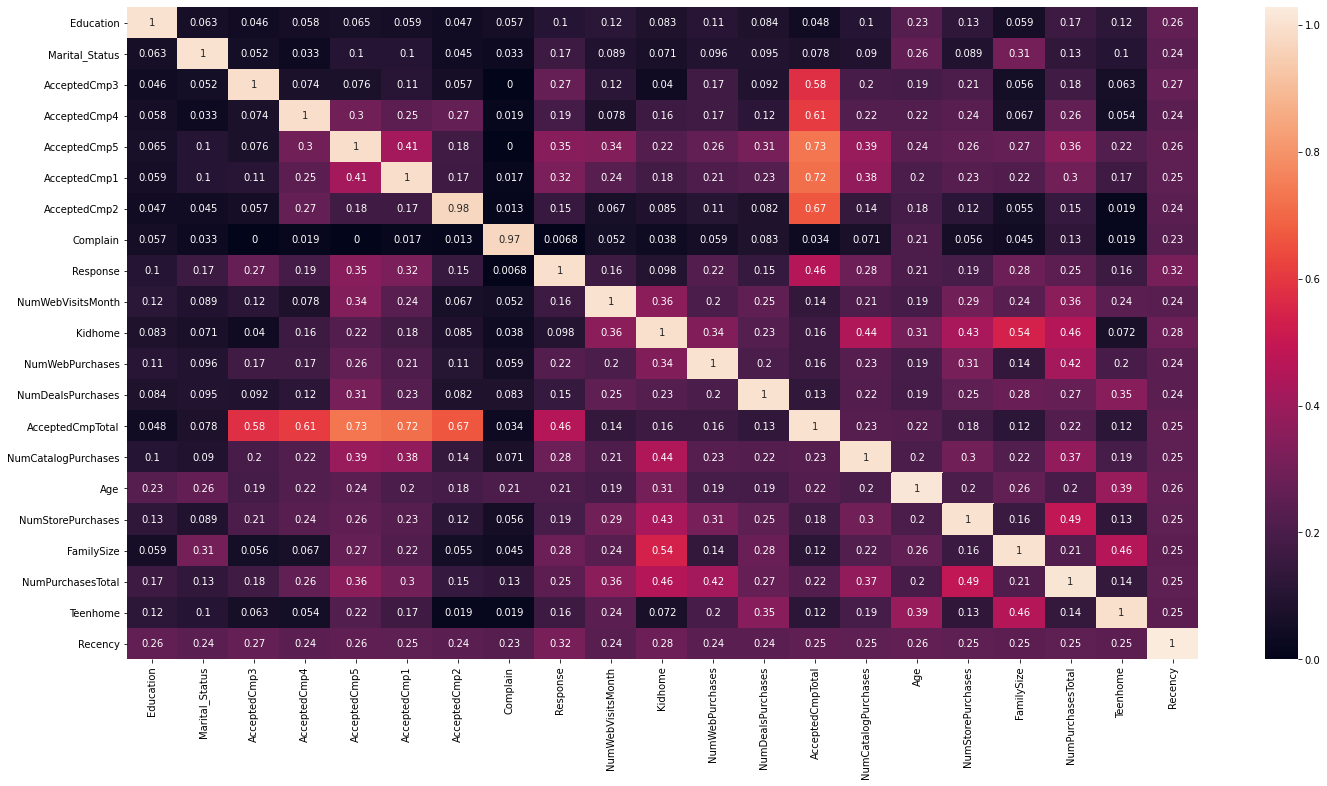

In [79]:
plt.figure(figsize=(24,12))
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True )

# DATA PREPARATION

In [80]:
df3=df2.copy()

In [81]:
discrete,continuous,categorical,dates=variable_types(df3)

There are 12 discrete variables
There are 9 continuous variables
There are 9 categorical variables
There are 0 date_time variables


## Categorical

In [82]:
categorical

['Education',
 'Marital_Status',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Response']

### Education variable rank ecoding

In [83]:
df3['Education'].unique()

array(['Graduation', 'Master', 'PhD', 'Basic', '2n Cycle'], dtype=object)

In [84]:
dic={'Basic':0,'2n Cycle':1,'Graduation':2,'Master':3,'PhD':4}
df3['Education']=df3['Education'].map(dic)

### Marital Status

**Analysis**

All the specific different marital status doesn't bring new information to the model. Decidide to replace Marital_status with a simpler feature named **Alone**

In [85]:
df3['Marital_Status'].value_counts()

Married     705
Together    465
Single      381
Divorced    177
Widow        58
Alone         3
YOLO          2
Absurd        1
Name: Marital_Status, dtype: int64

In [86]:
aux=pd.get_dummies(df3['Marital_Status'],drop_first=False)
aux=pd.concat([aux,df3['Response']],axis=1)

<AxesSubplot:>

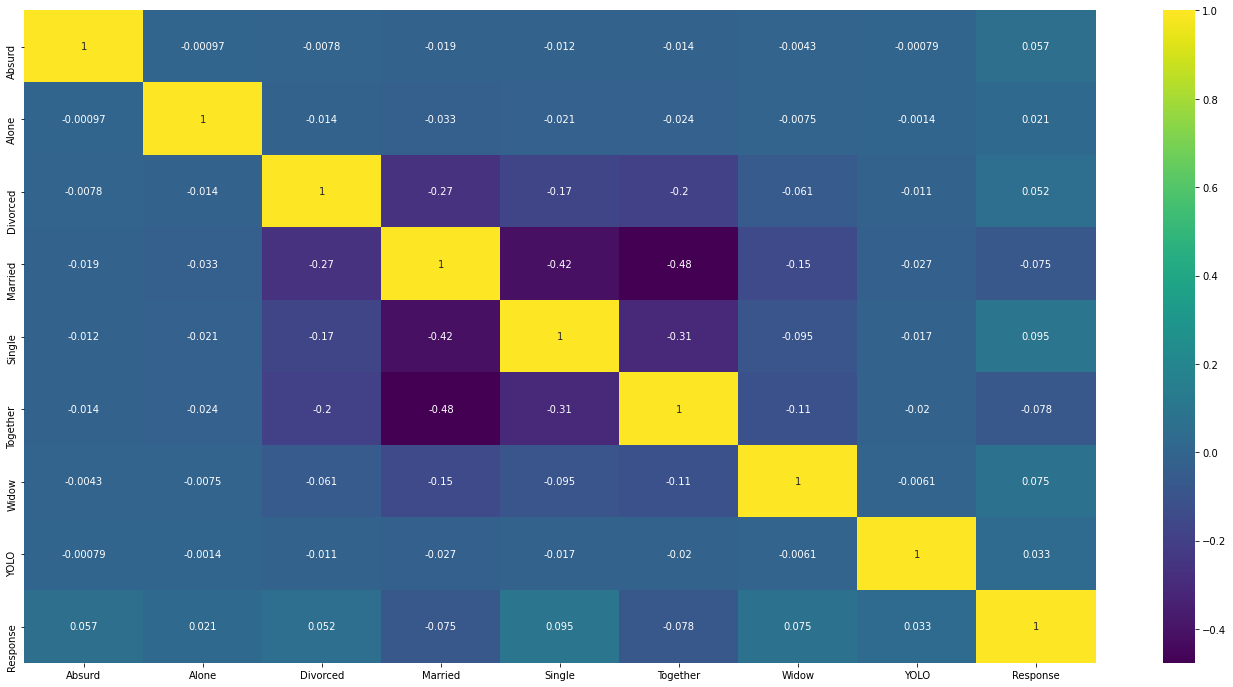

In [87]:
# see below that Response has postive correlation for absurd,alone,divorced,single,widow and Yolo
# and negative for married and together
# also married and together have very similar correlations
plt.figure(figsize=(24,12))
sns.heatmap(aux.corr(method='pearson'),cmap='viridis',annot=True)

In [88]:
# To reduce model complexity we will replace the feature maritural status with a simpler feature called alone
dic={'Married':0,'Together':0,'Single':1,'Divorced':1,'Widow':1,'Alone':1,'YOLO':1,'Absurd':1}
df3['Alone']=df3['Marital_Status'].map(dic)

#### Drop Marital Status

In [89]:
df3.drop(['Marital_Status'],axis=1,inplace=True)

## Continuous and discrete 

In [90]:
print(continuous+discrete)

['Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'MntTotal', 'DaysSinceEnroll', 'NumWebVisitsMonth', 'Kidhome', 'NumWebPurchases', 'NumDealsPurchases', 'AcceptedCmpTotal', 'NumCatalogPurchases', 'Age', 'NumStorePurchases', 'FamilySize', 'NumPurchasesTotal', 'Teenhome', 'Recency']


### Drop extreme outliers

Diagnose outliers found on EDA and drop only if extreme and target not positive

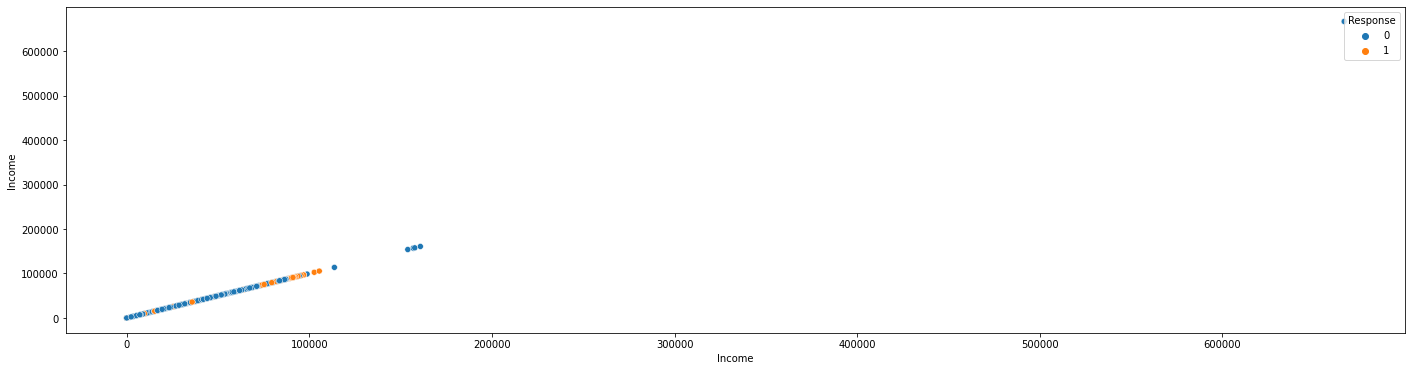

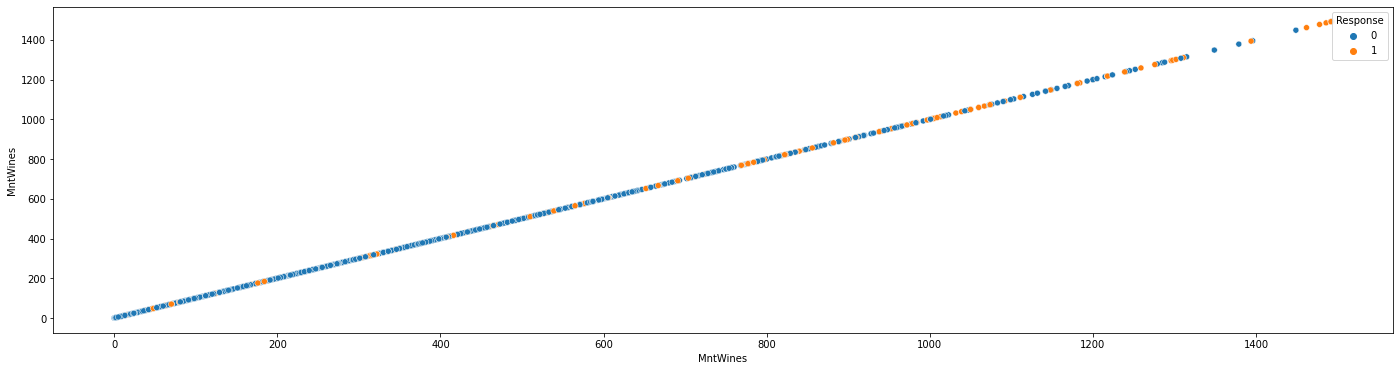

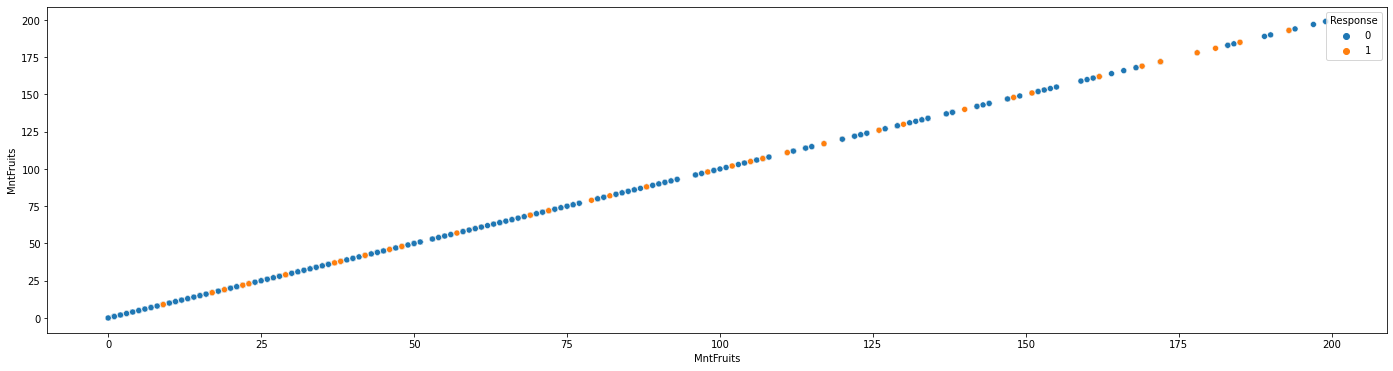

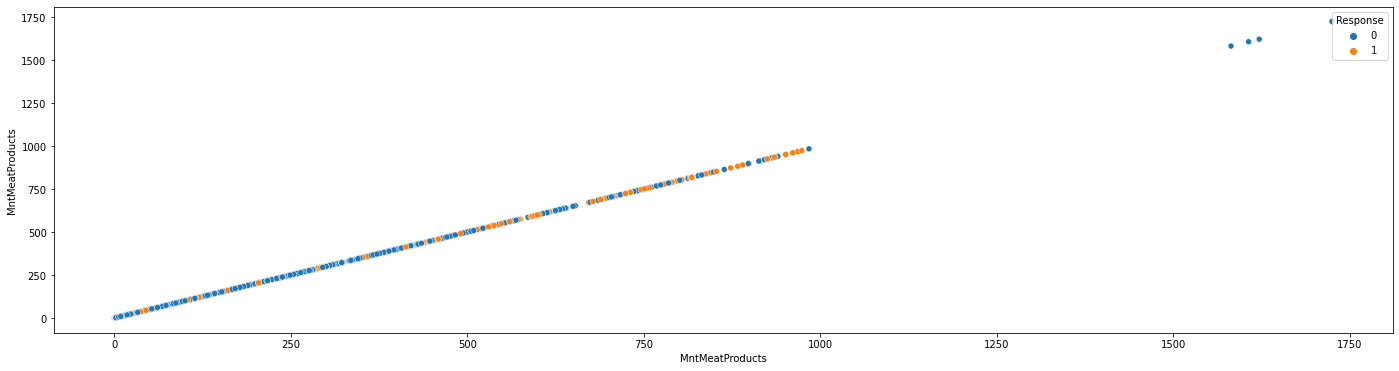

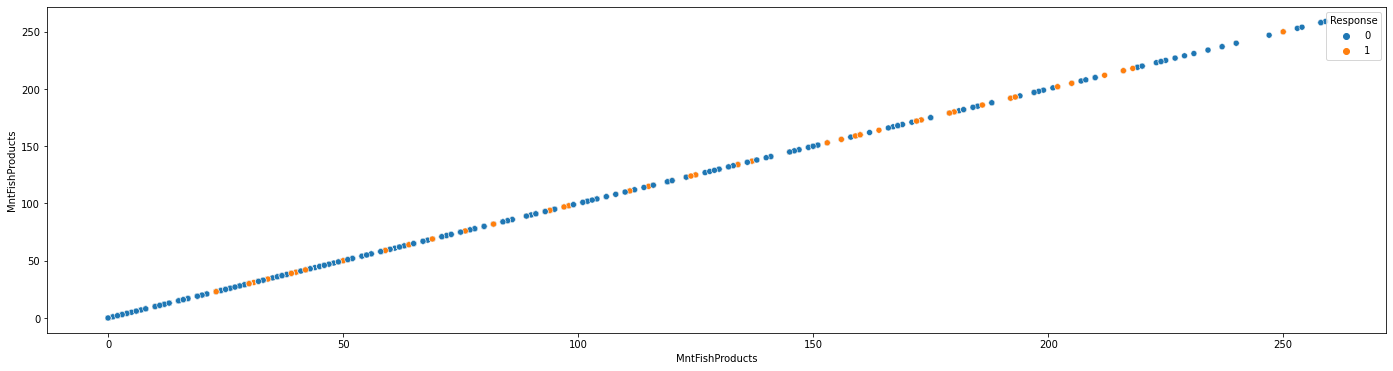

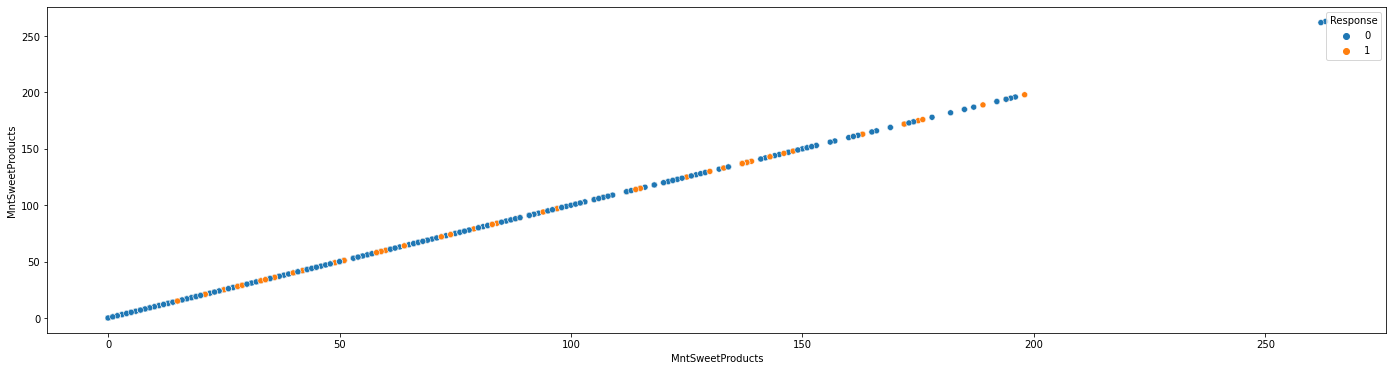

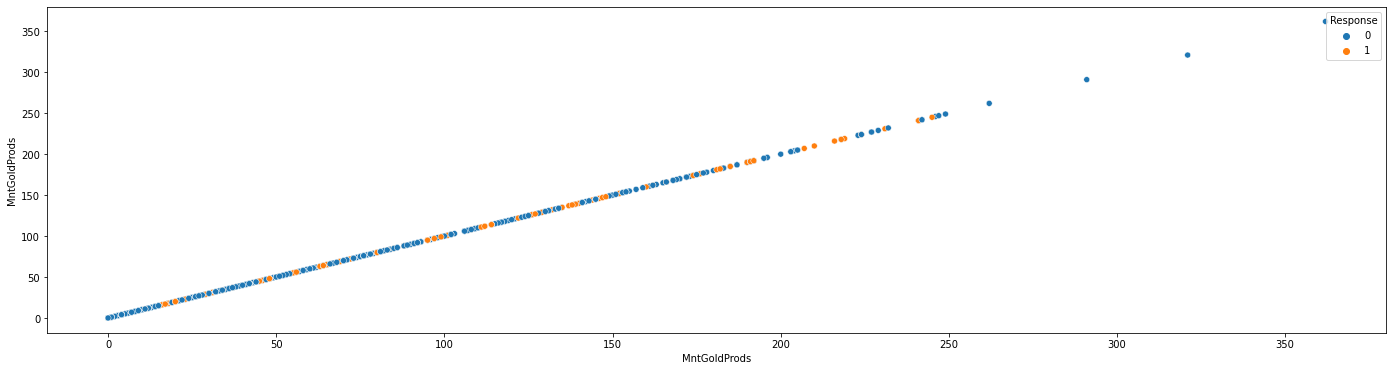

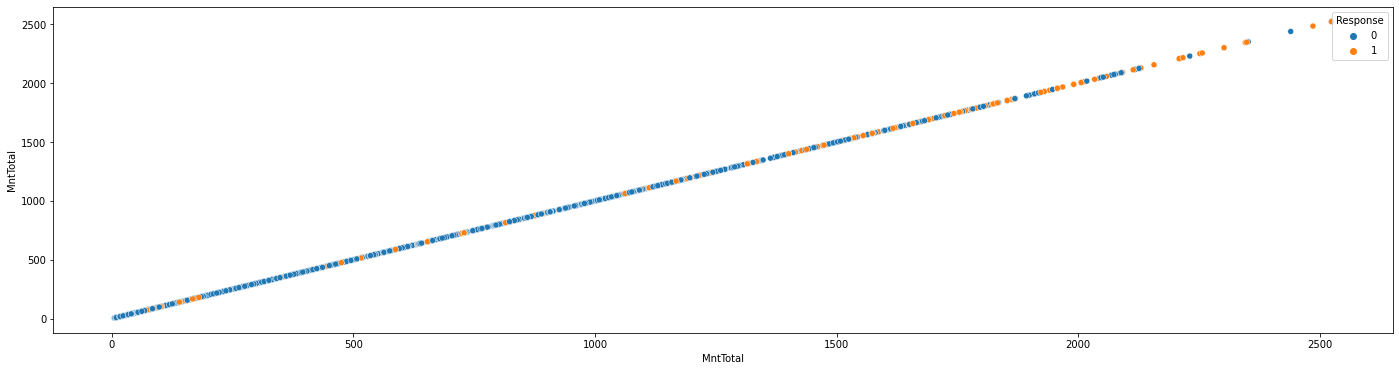

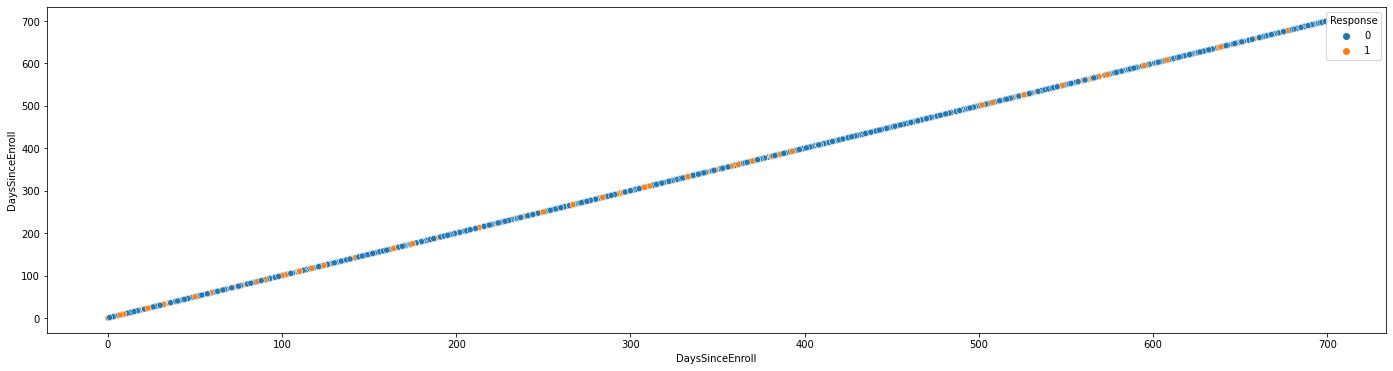

In [91]:
# Care should be taken to not drop outliers if positive target
for var in continuous:
    plt.figure(figsize=(24,6))
    sns.scatterplot(x=var, y=var, hue='Response', data=df2)
    plt.ylabel(var)
#     plt.title('x ' + var)
    plt.show()

In [92]:
def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
#     upper_boundary = df[variable].mean() + distance * df[variable].std()
#     lower_boundary = df[variable].mean() - distance * df[variable].std()
#     lower_boundary = df[variable].quantile(0.05)
#     upper_boundary = df[variable].quantile(0.95)
    return upper_boundary, lower_boundary

In [93]:
for var in continuous:
    RM_upper_limit, RM_lower_limit = find_skewed_boundaries(df3, var, 6)
    print(var,' Upper limit :',RM_upper_limit)
    print('Outliers: ')
    print(df3[df3[var]>RM_upper_limit][var].values,'\n')
    # drop outliers
    df3=df3.loc[df3[var]<=RM_upper_limit]

Income  Upper limit : 268445.25
Outliers: 
[666666.] 

MntWines  Upper limit : 3243.0
Outliers: 
[] 

MntFruits  Upper limit : 225.0
Outliers: 
[] 

MntMeatProducts  Upper limit : 1499.0
Outliers: 
[1607 1582 1725 1622 1725] 

MntFishProducts  Upper limit : 332.0
Outliers: 
[] 

MntSweetProducts  Upper limit : 230.25
Outliers: 
[263 262] 

MntGoldProds  Upper limit : 344.0
Outliers: 
[] 

MntTotal  Upper limit : 6801.75
Outliers: 
[] 

DaysSinceEnroll  Upper limit : 2595.0
Outliers: 
[] 



### Scaling study

**Analysis**

* Robust scaler is best for now
* Try yeo-Johson on second cycle on continuous variables (except Income)

#### Continuous

In [94]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    plt.figure(figsize=(20,6))
    plt.subplot(1, 2, 1)
    plt.title(variable)
    df[variable].hist(bins=30)
    plt.subplot(1, 2, 2)
    ss.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

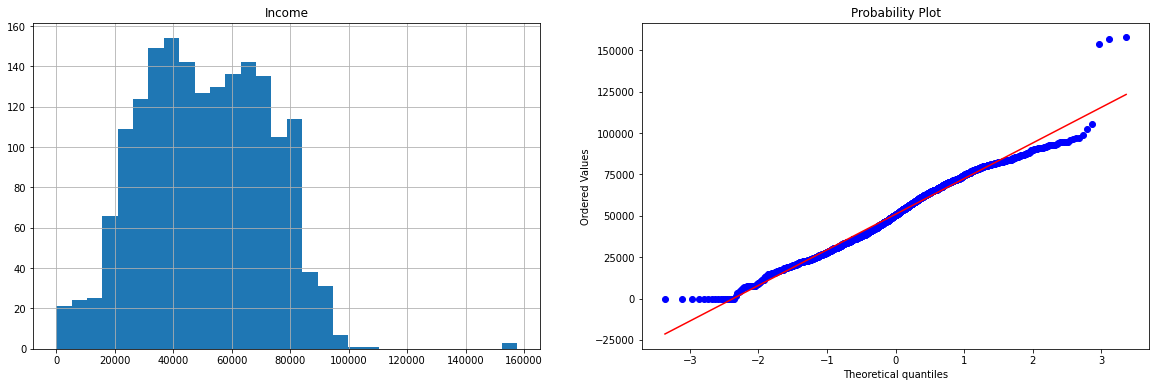

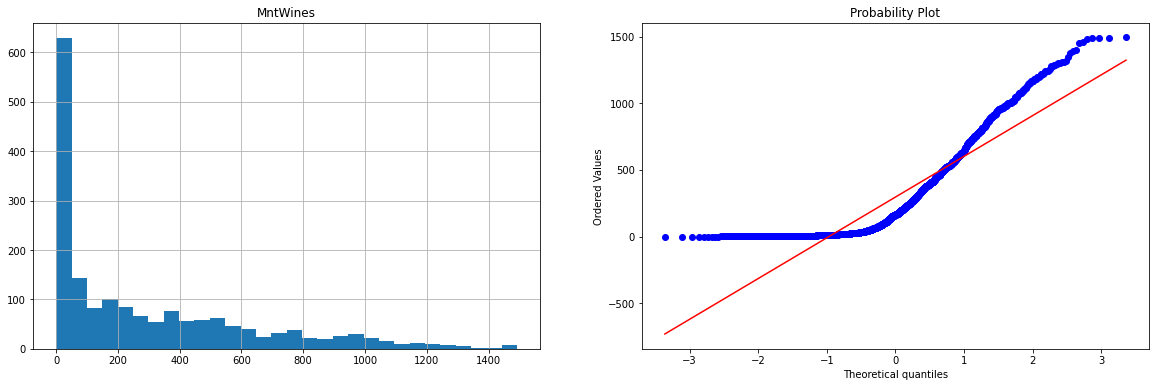

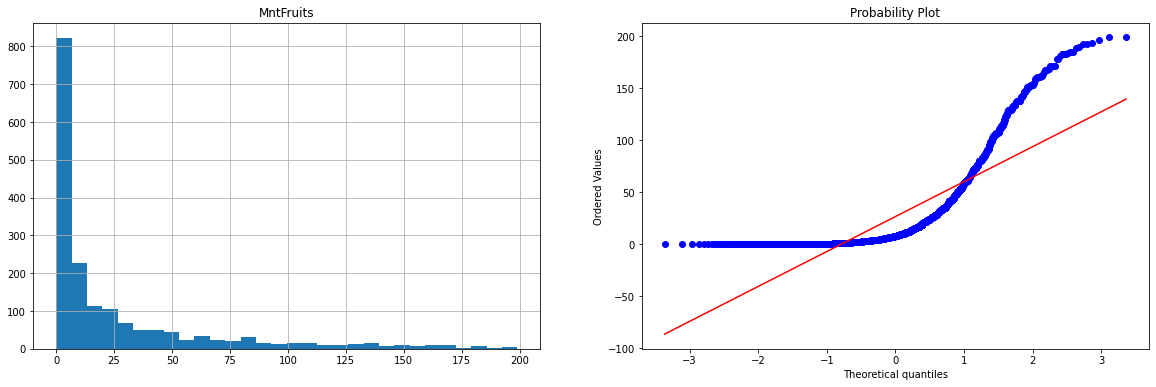

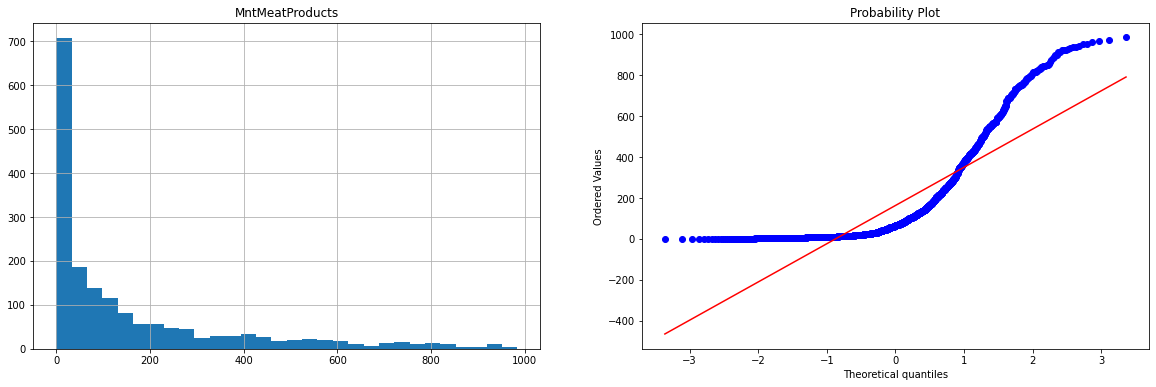

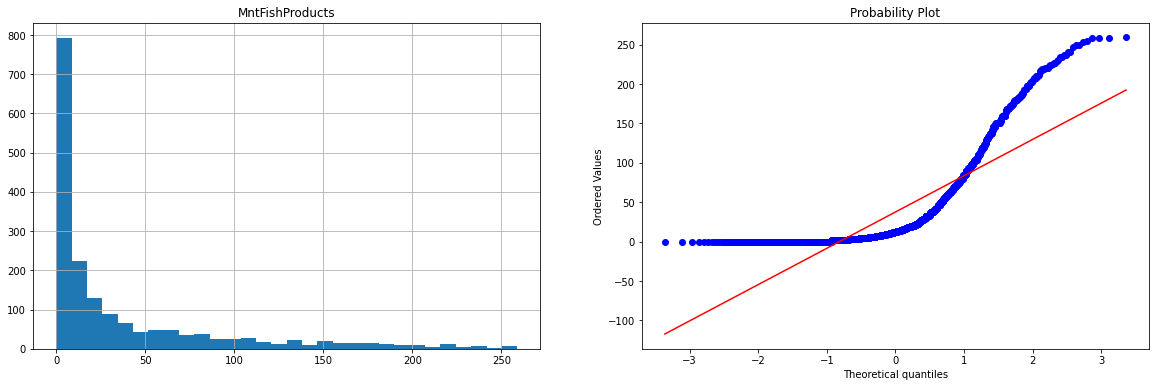

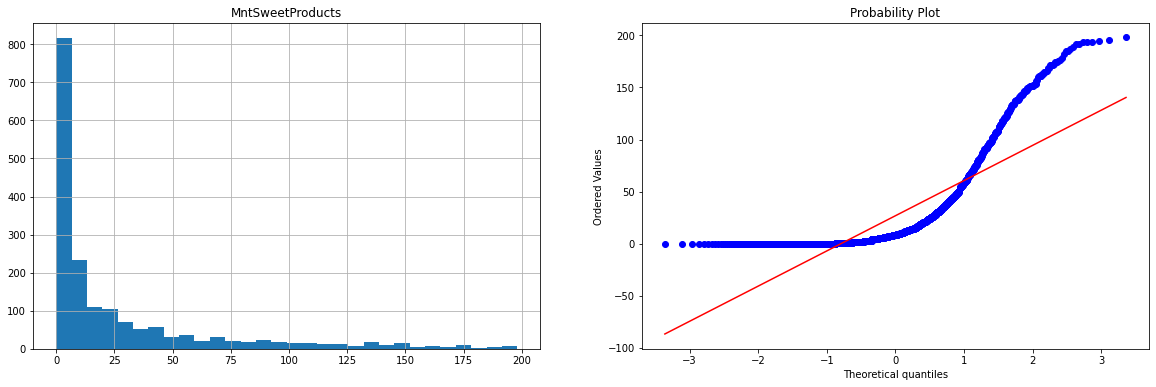

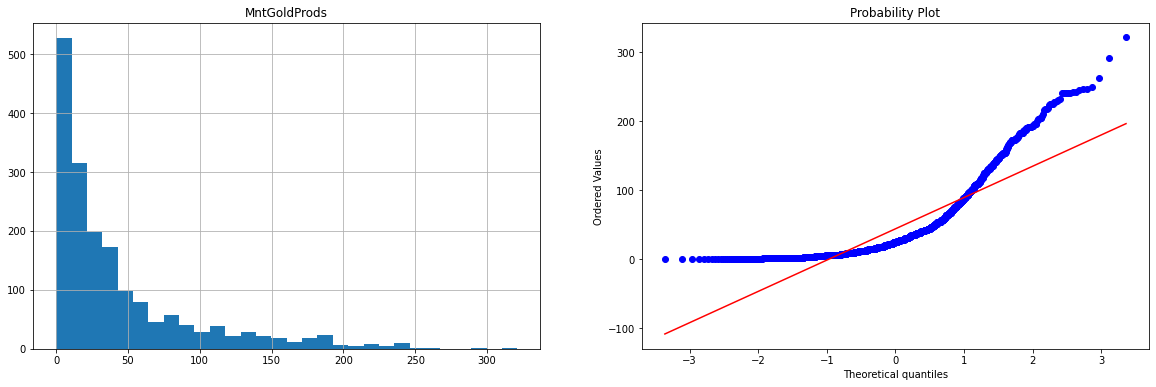

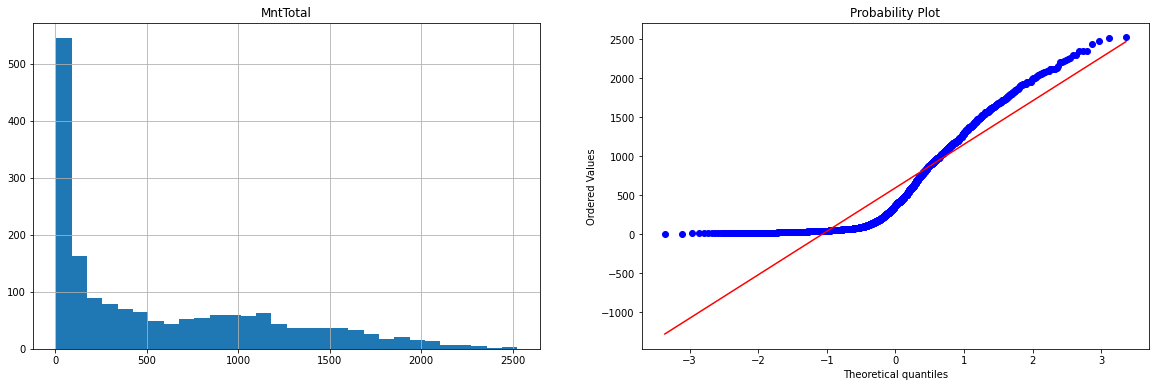

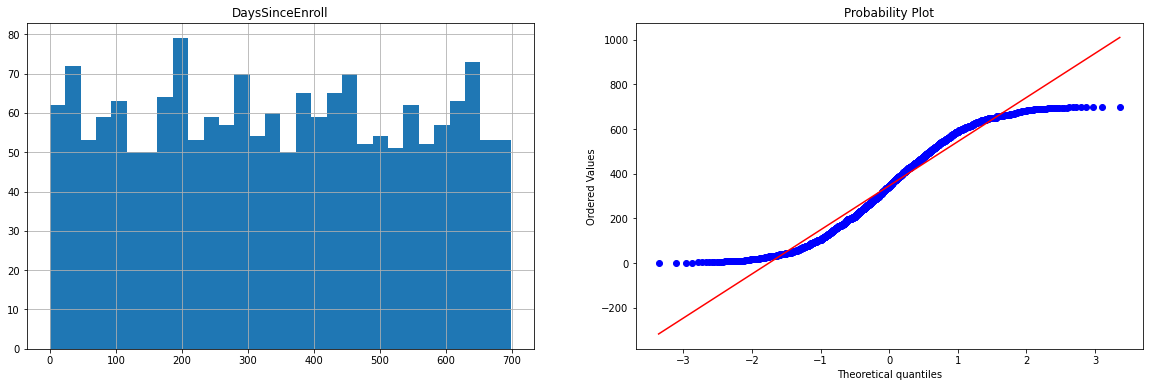

In [95]:
# acessing normality of nonscaled
for var in continuous:
    diagnostic_plots(df3, var)

 scale:  [21671.95038909]


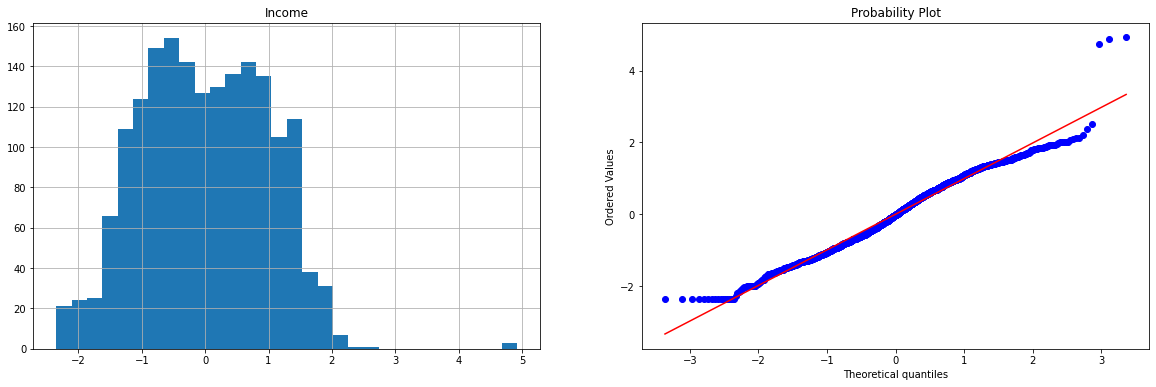

 scale:  [334.68394489]


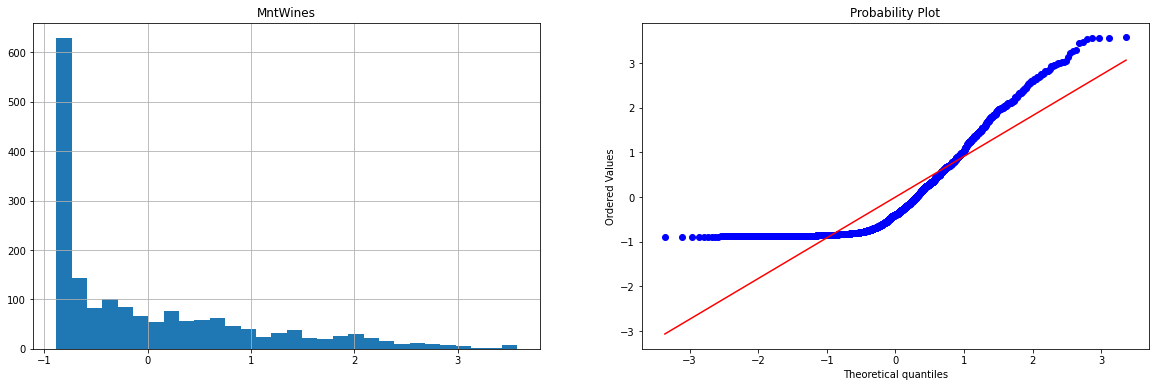

 scale:  [40.41816751]


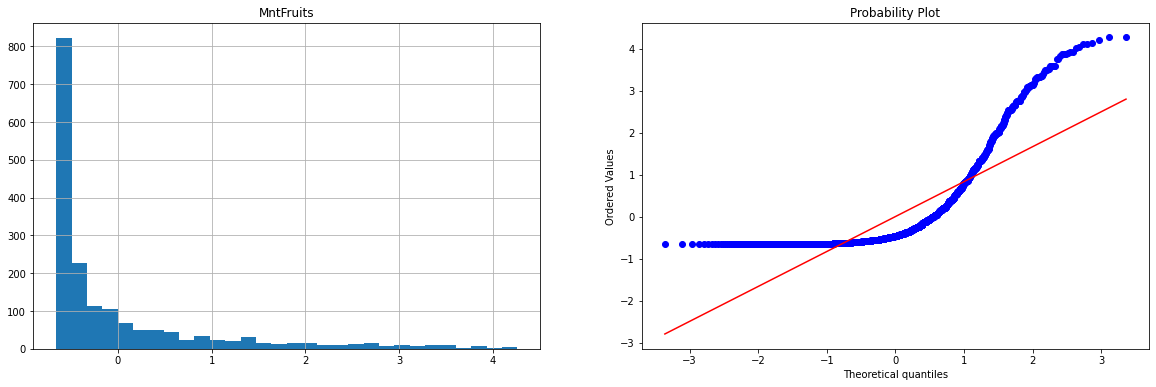

 scale:  [216.30799292]


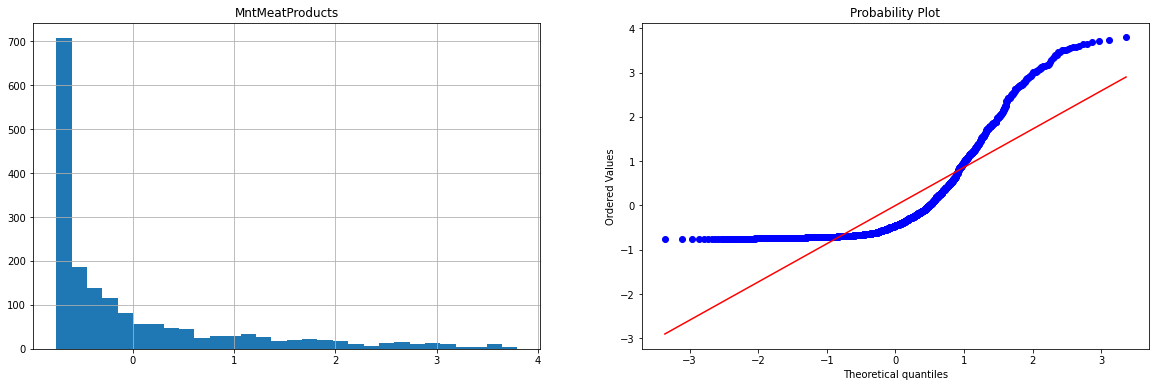

 scale:  [54.49508982]


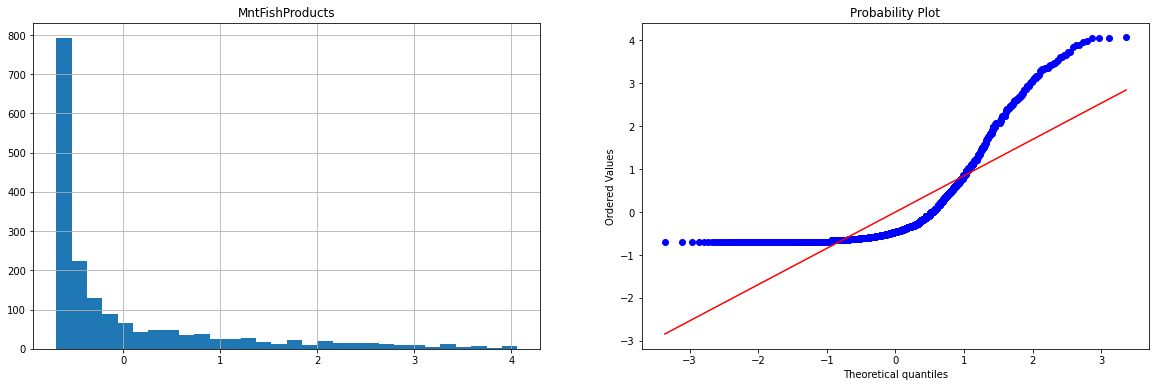

 scale:  [40.56148367]


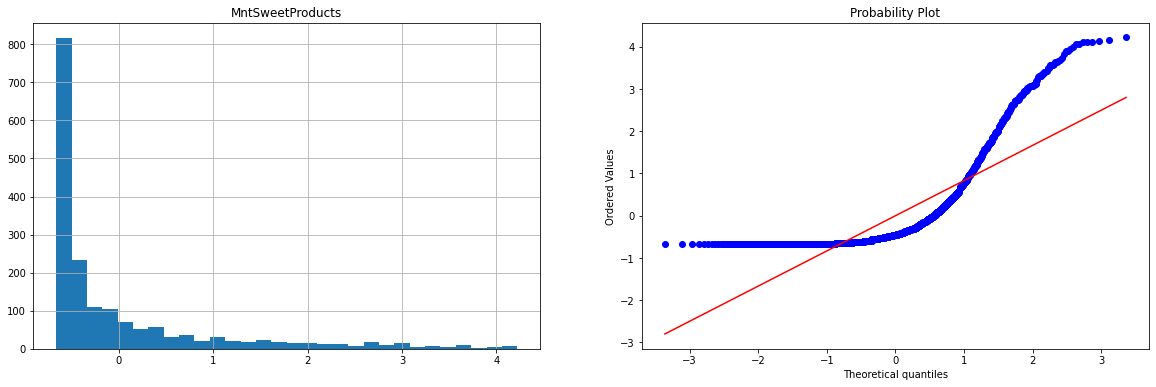

 scale:  [51.60987321]


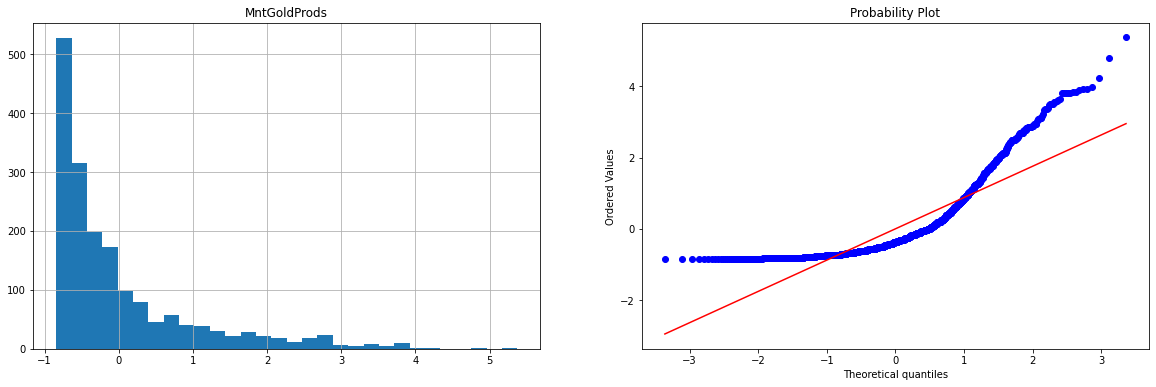

 scale:  [601.61107509]


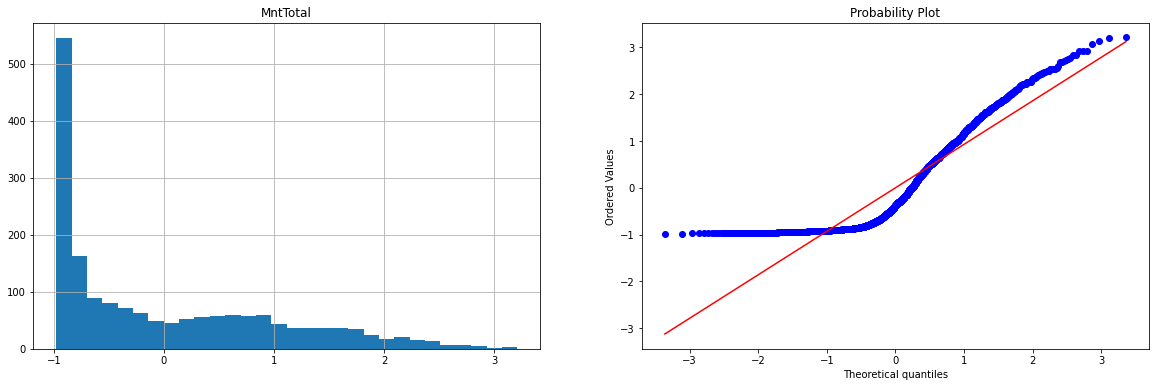

 scale:  [201.8279943]


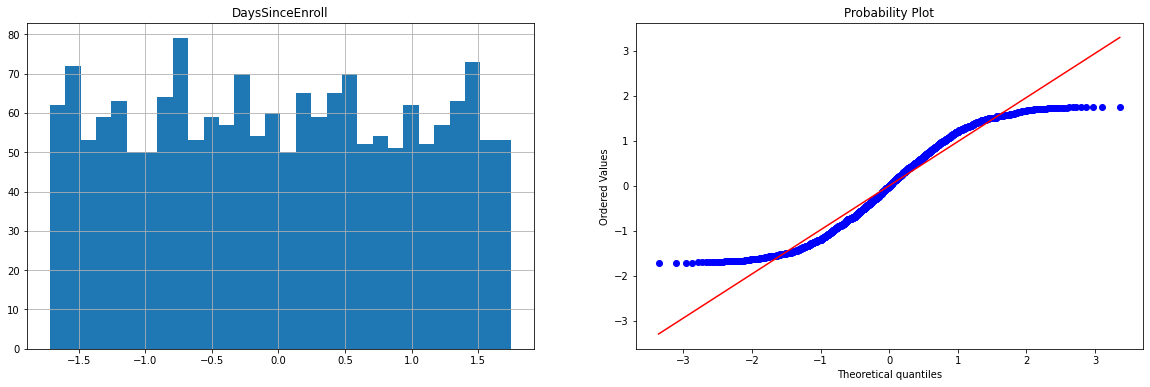

In [96]:
# studying viability of standardscaler
aux=df3.copy()
scaler = StandardScaler()
for var in continuous:
    aux[[var]]=scaler.fit_transform(aux[[var]].values)
    print(' scale: ', scaler.scale_)
    diagnostic_plots(aux, var)

 scale:  [33219.75]


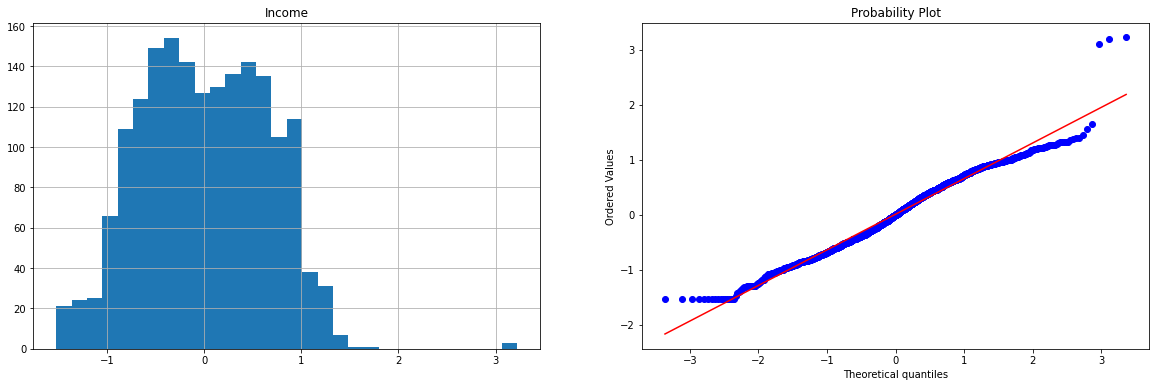

 scale:  [460.]


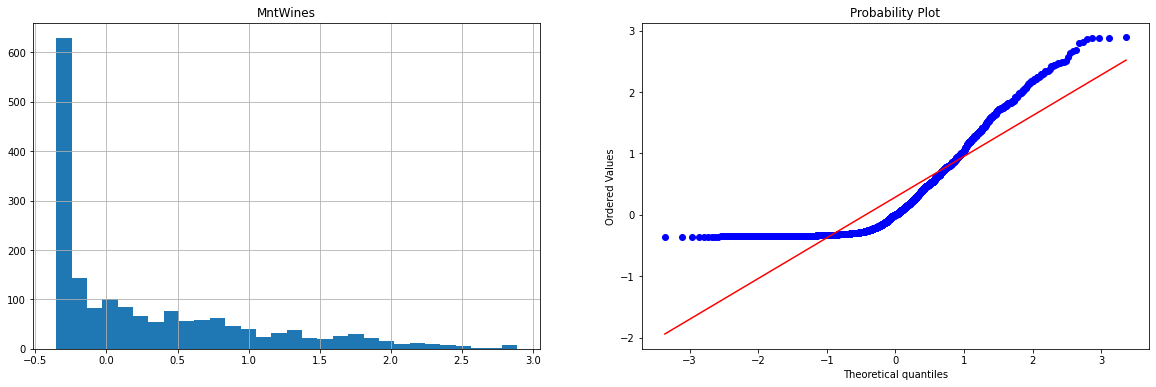

 scale:  [32.25]


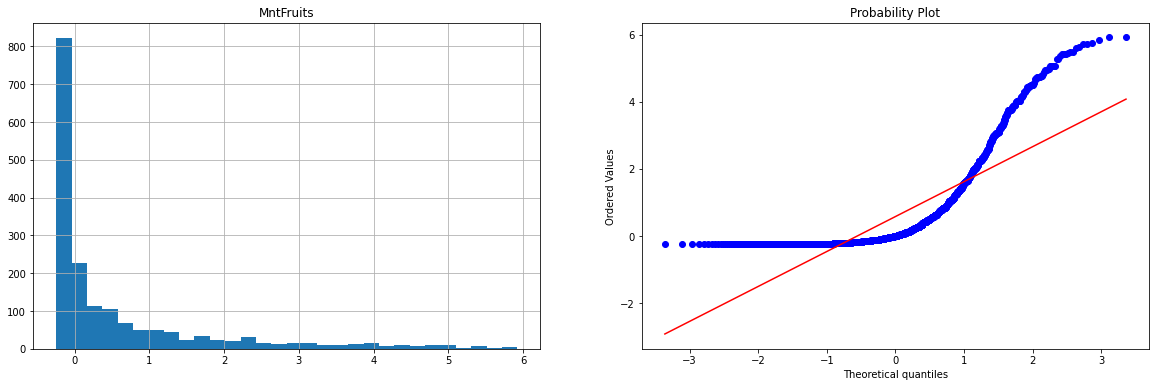

 scale:  [209.]


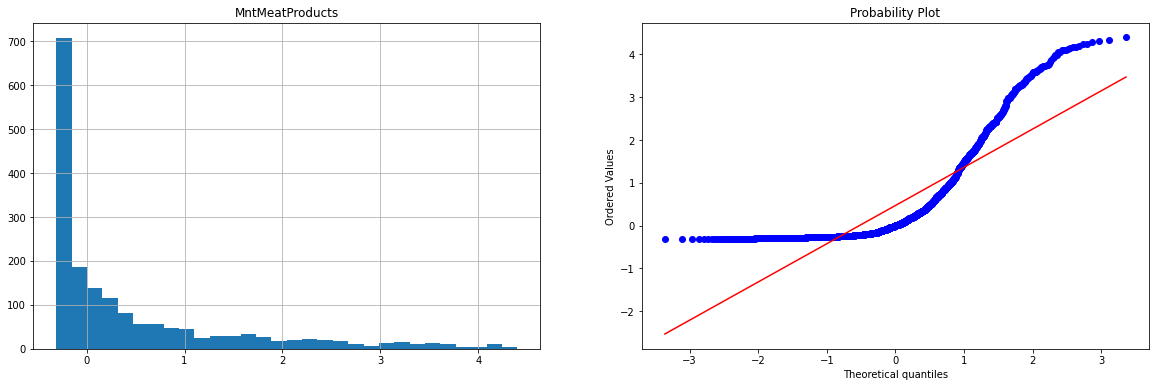

 scale:  [47.]


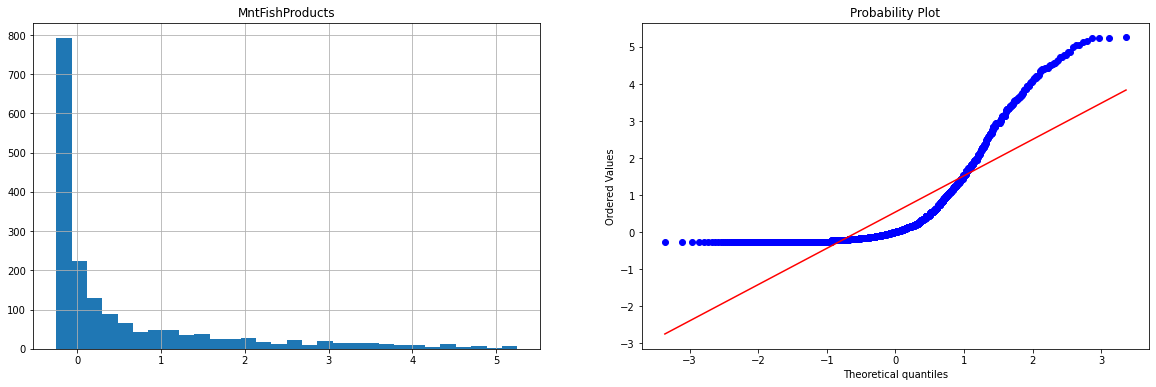

 scale:  [32.]


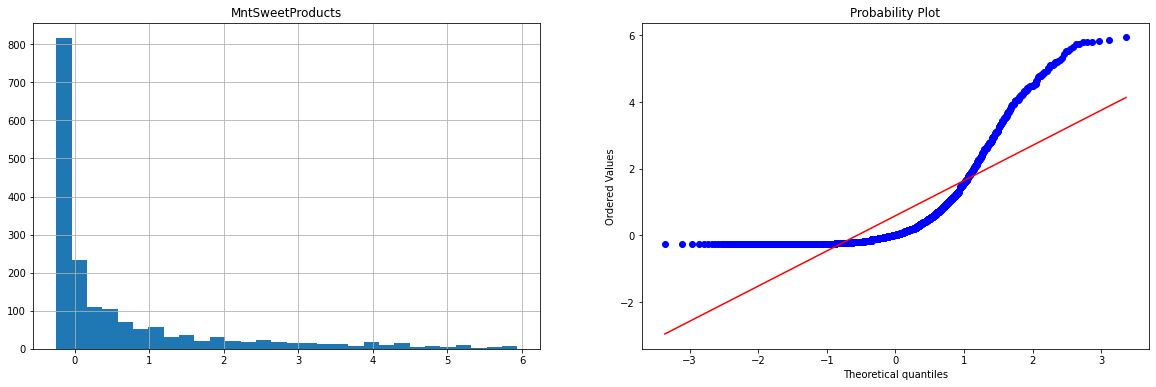

 scale:  [48.]


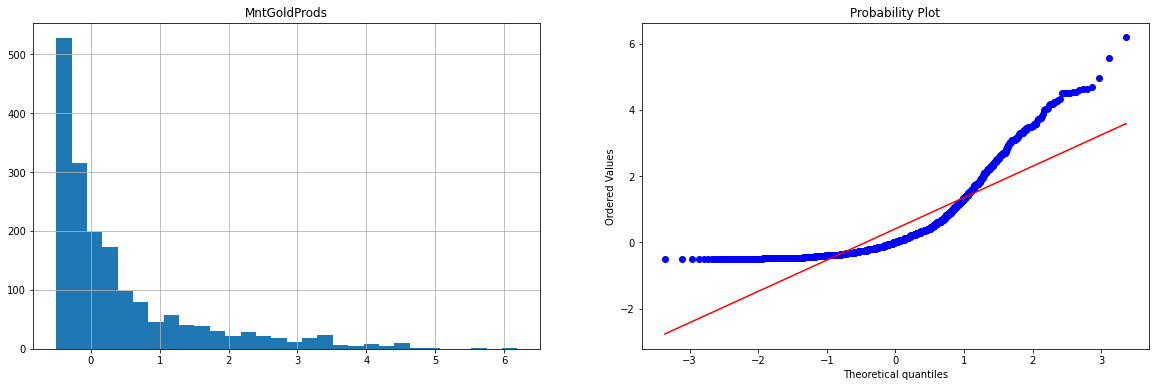

 scale:  [962.25]


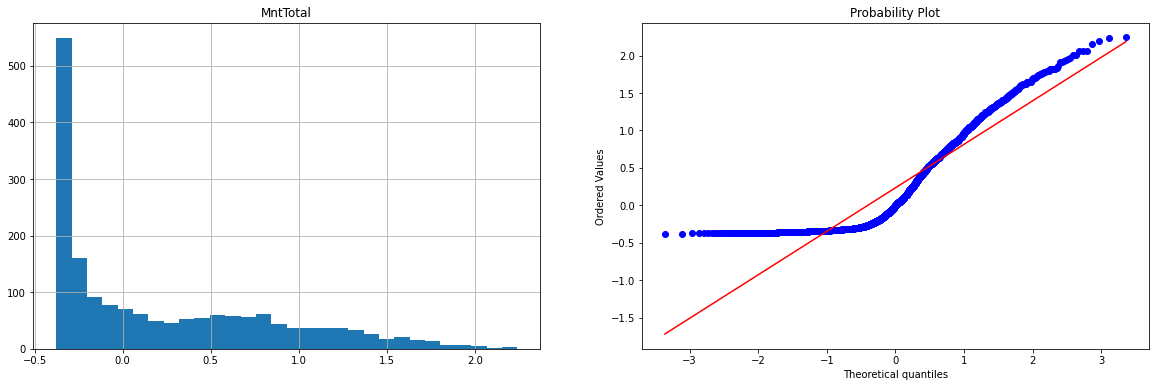

 scale:  [346.]


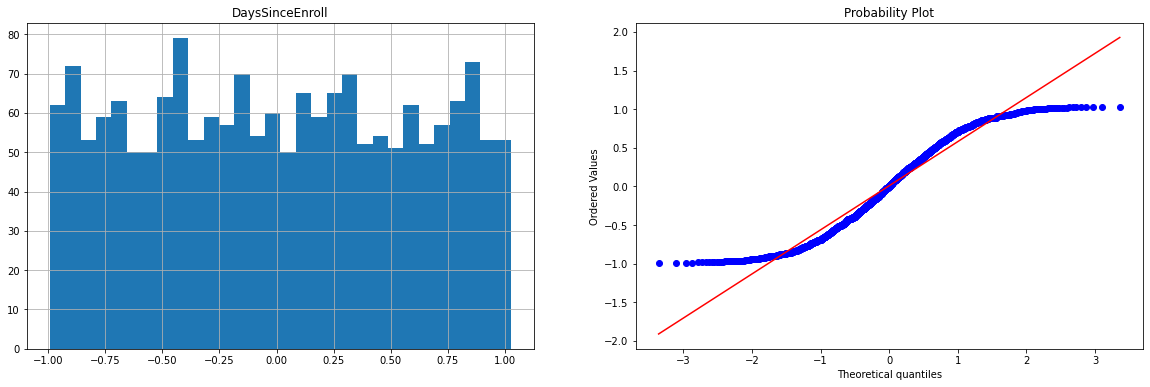

In [97]:
# studying viability of robustscaler
aux=df3.copy()
scaler = RobustScaler()
for var in continuous:
    aux[[var]]=scaler.fit_transform(aux[[var]].values)
    print(' scale: ', scaler.scale_)
    diagnostic_plots(aux, var)

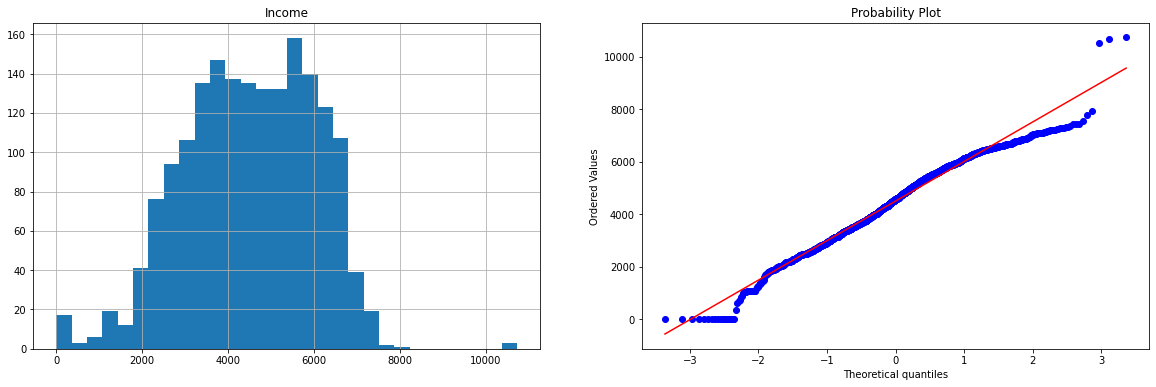

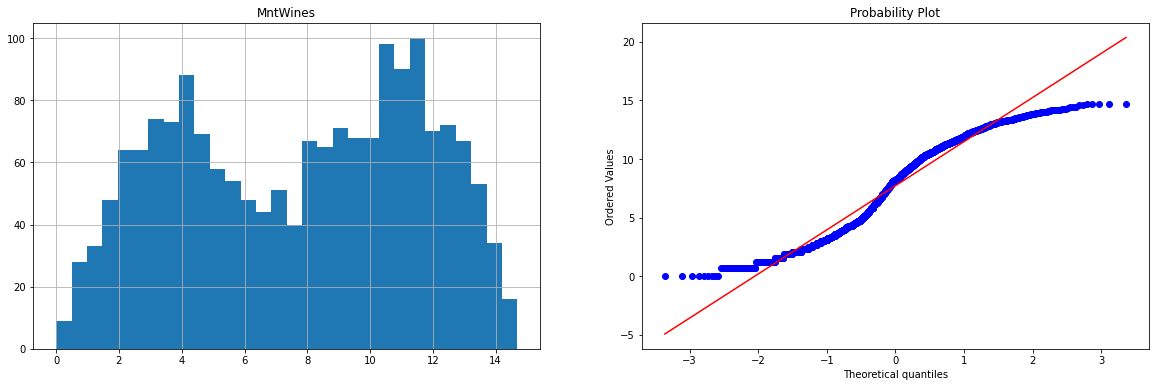

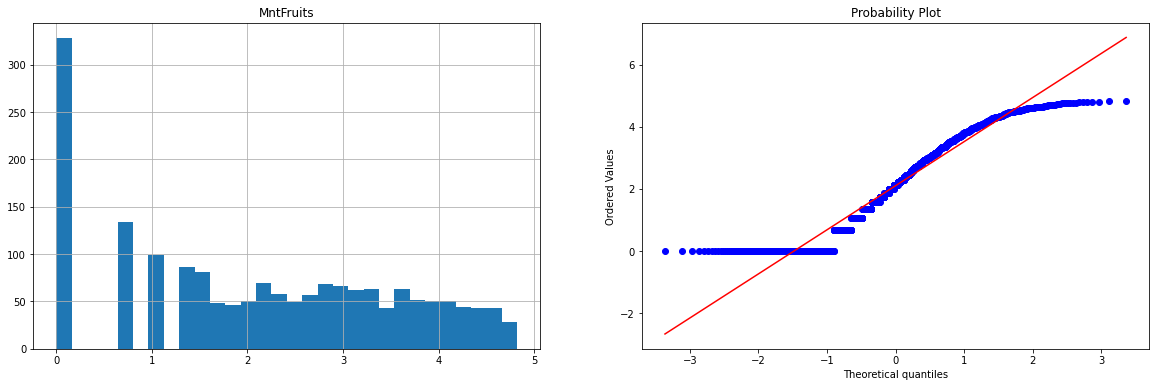

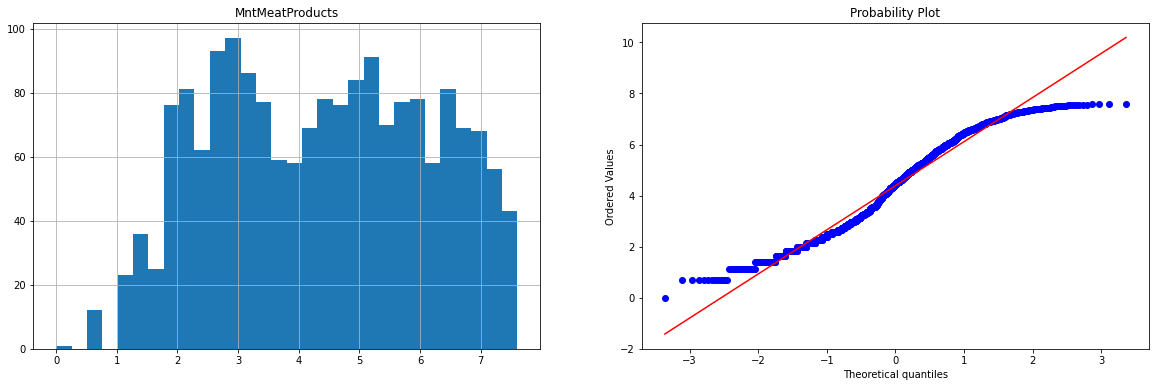

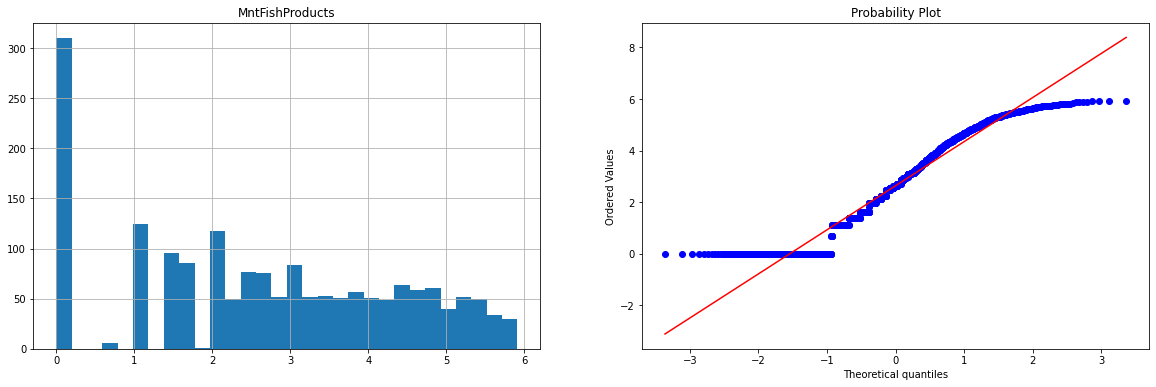

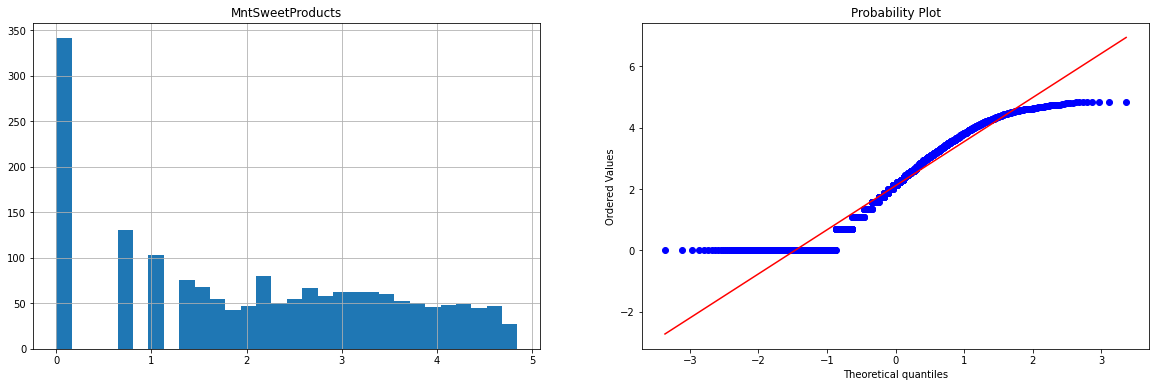

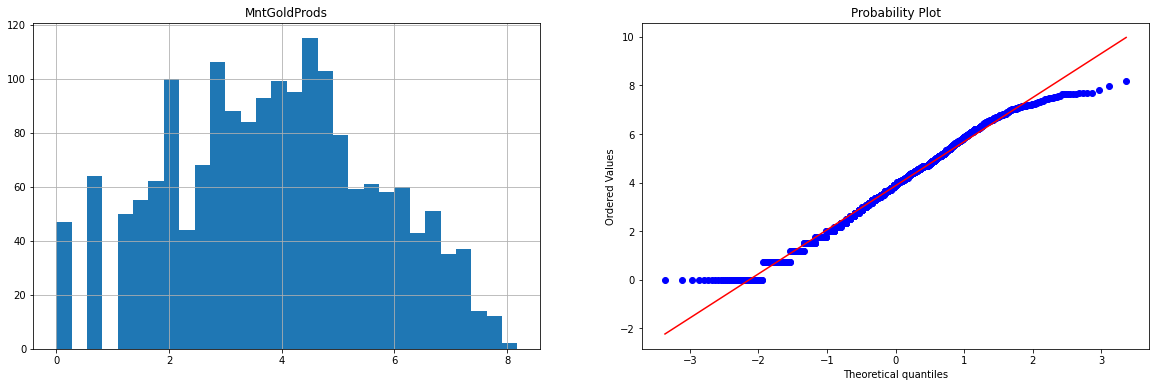

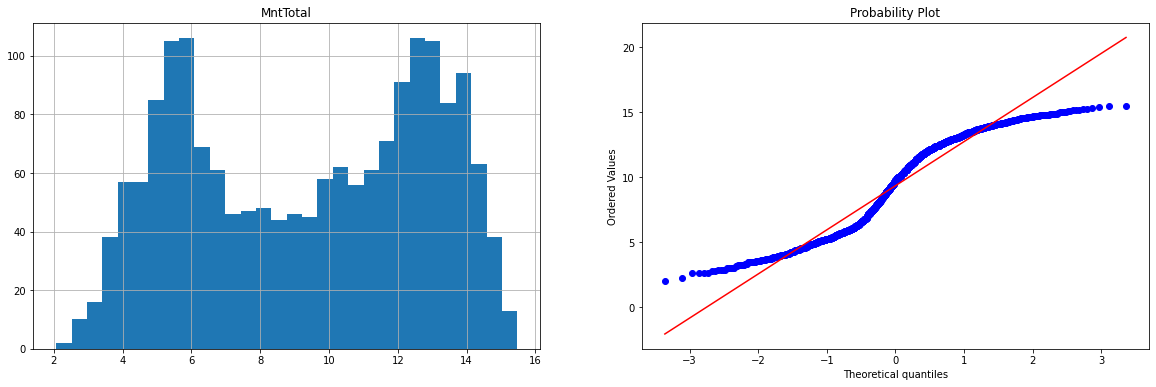

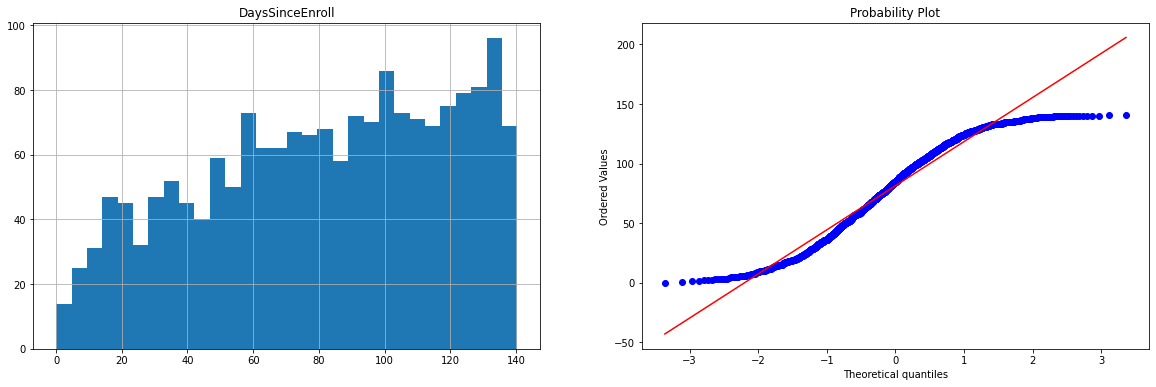

In [98]:
# studying viability of robustscaler
aux=df3.copy()
transformer = PowerTransformer(method='yeo-johnson', standardize=False)
for var in continuous:
    aux[[var]]=transformer.fit_transform(aux[[var]].values)
#     print(' scale: ', scaler.scale_)
    diagnostic_plots(aux, var)

#### Discrete

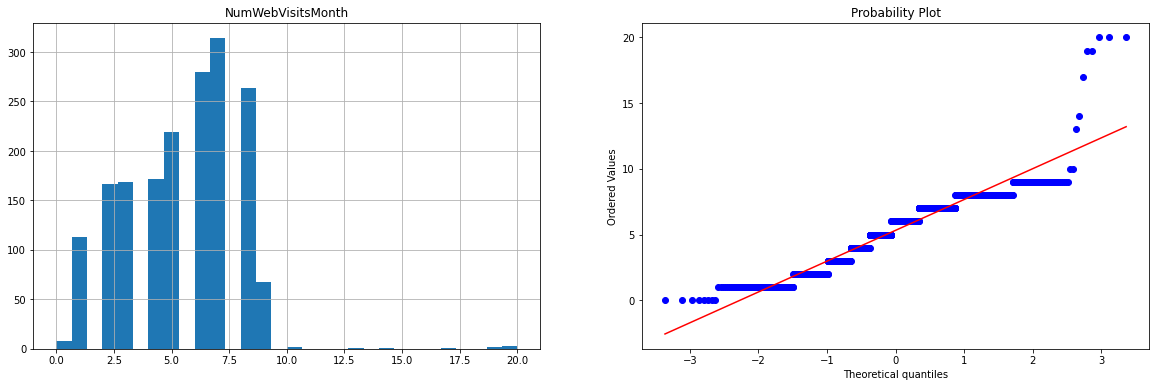

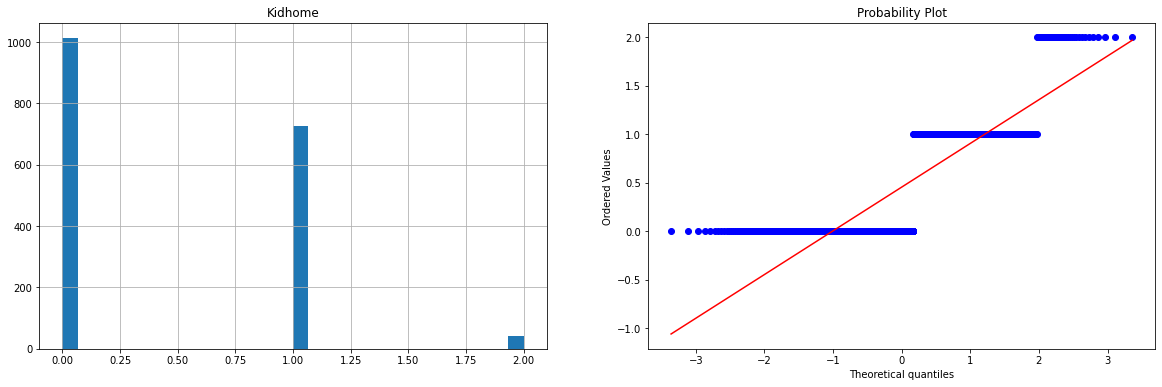

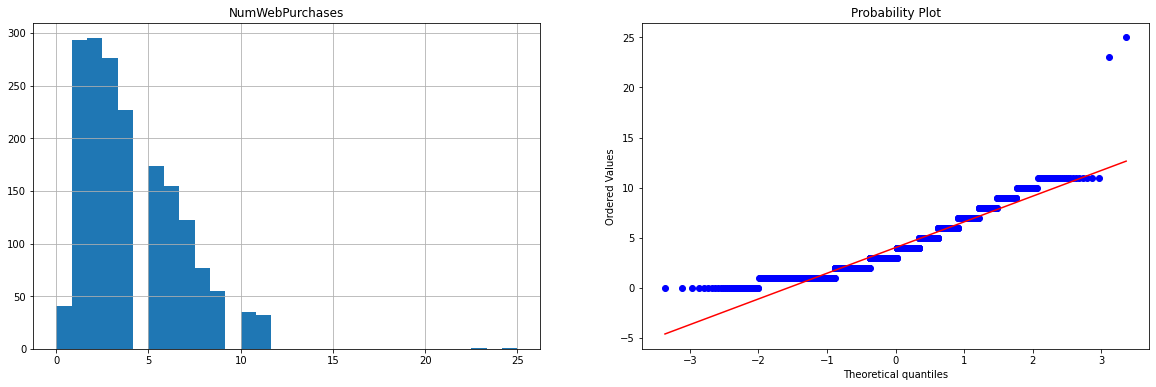

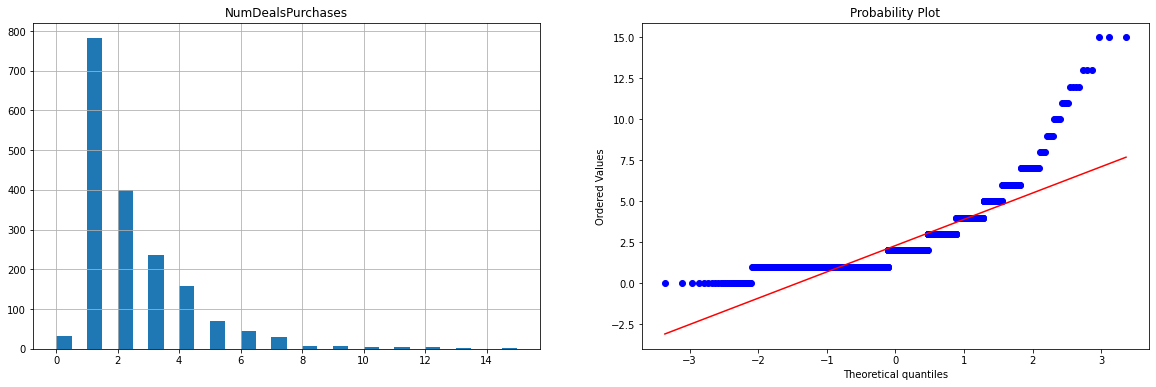

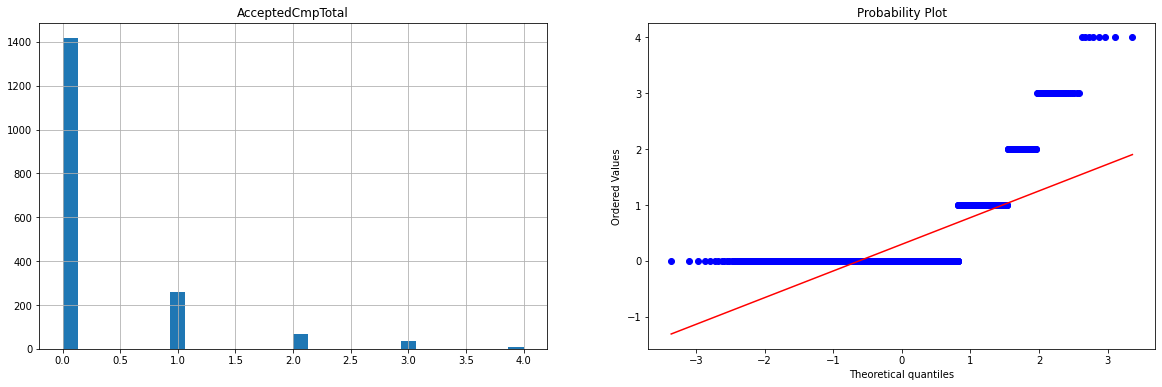

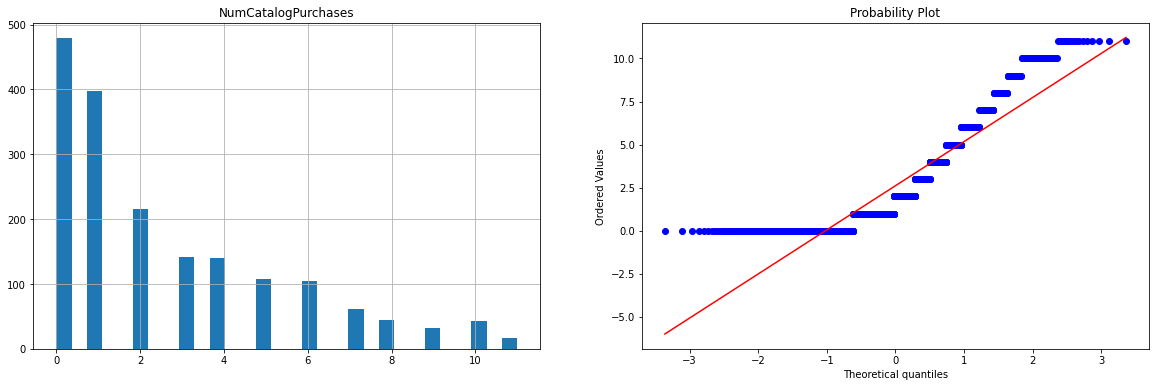

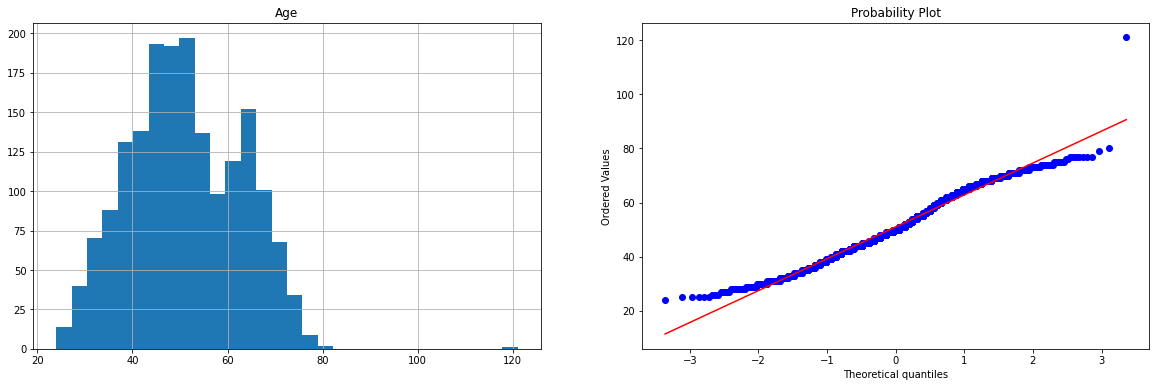

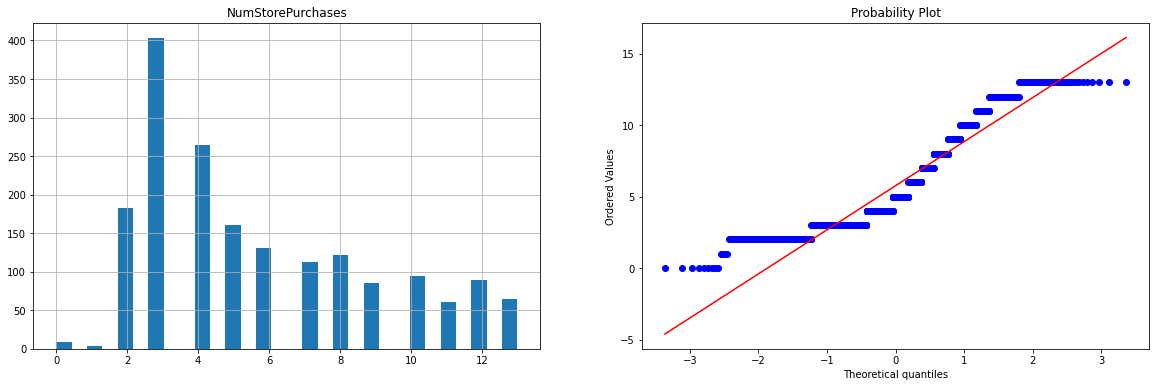

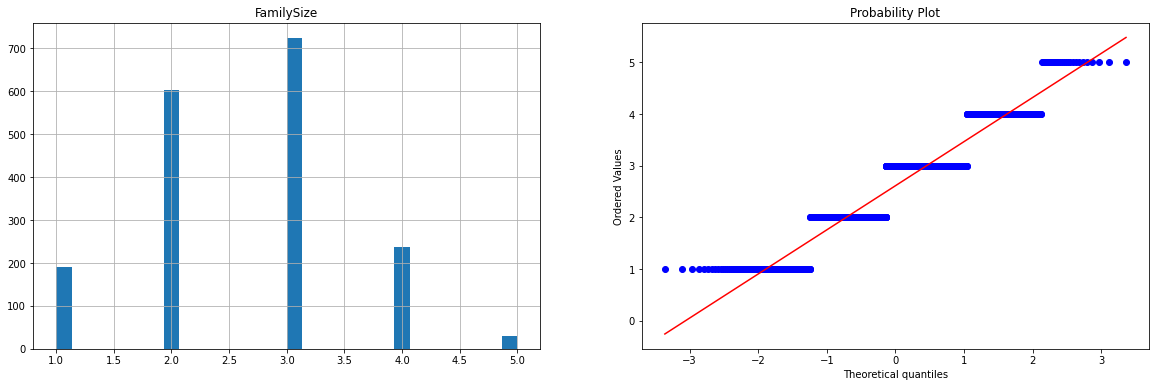

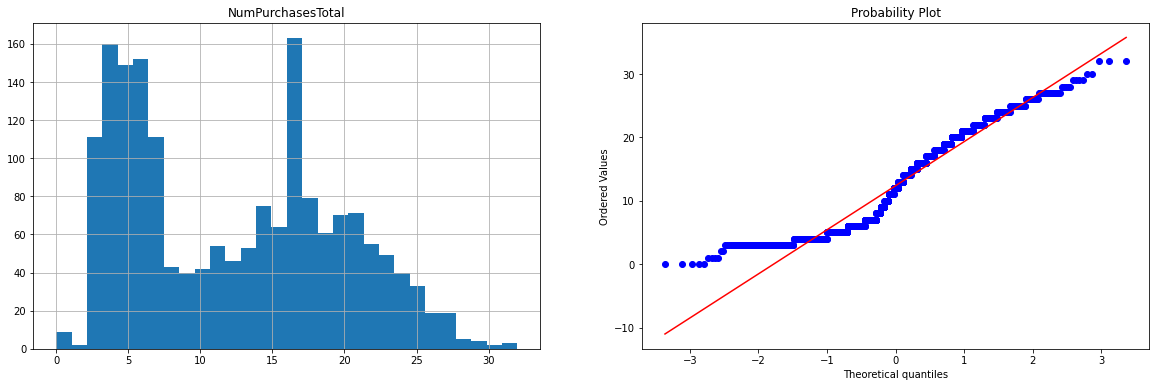

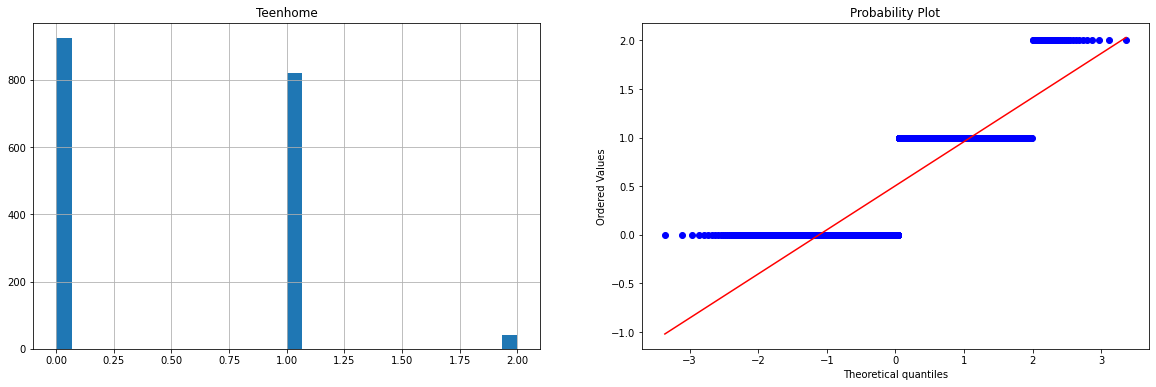

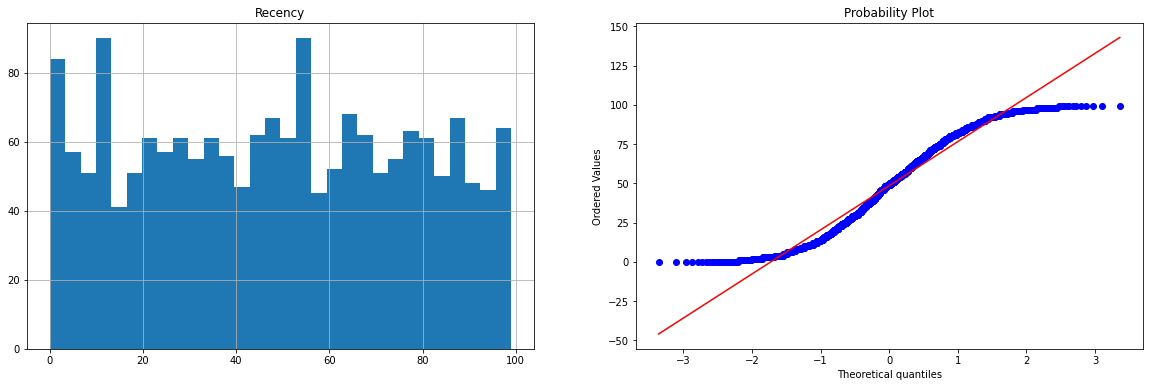

In [99]:
# acessing normality of nonscaled
for var in discrete:
    diagnostic_plots(df3, var)

 scale:  [4.]


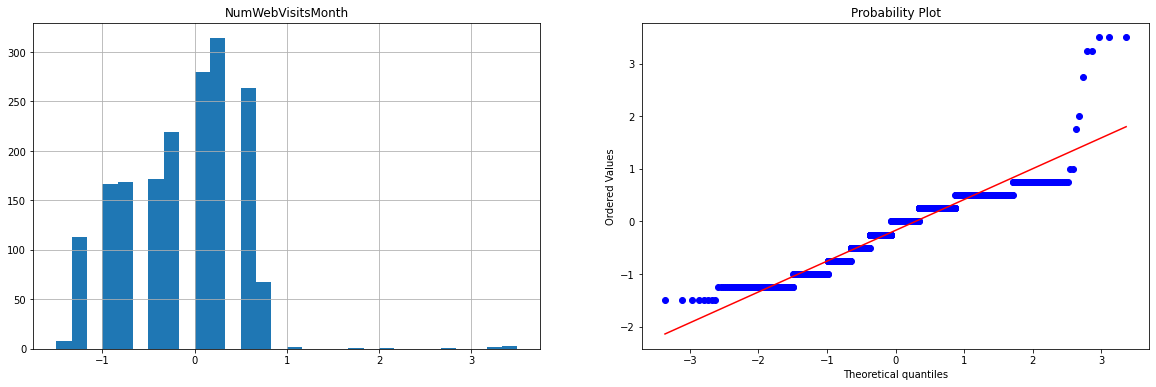

 scale:  [1.]


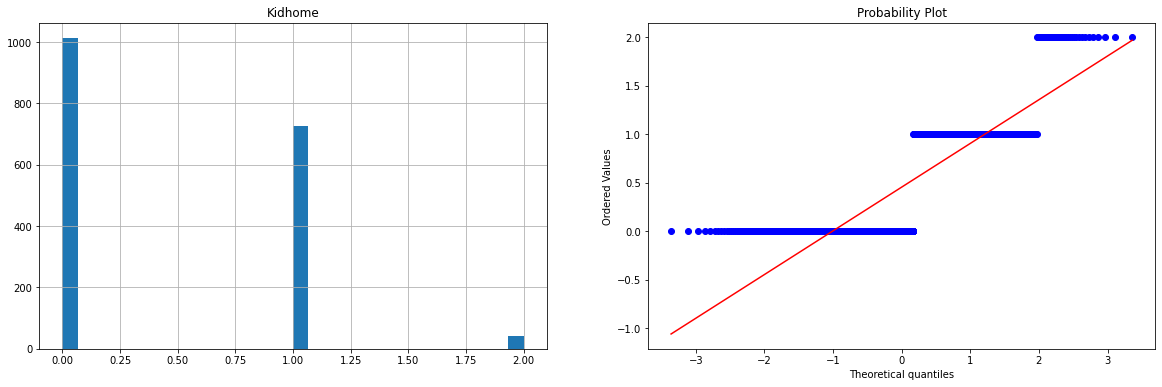

 scale:  [4.]


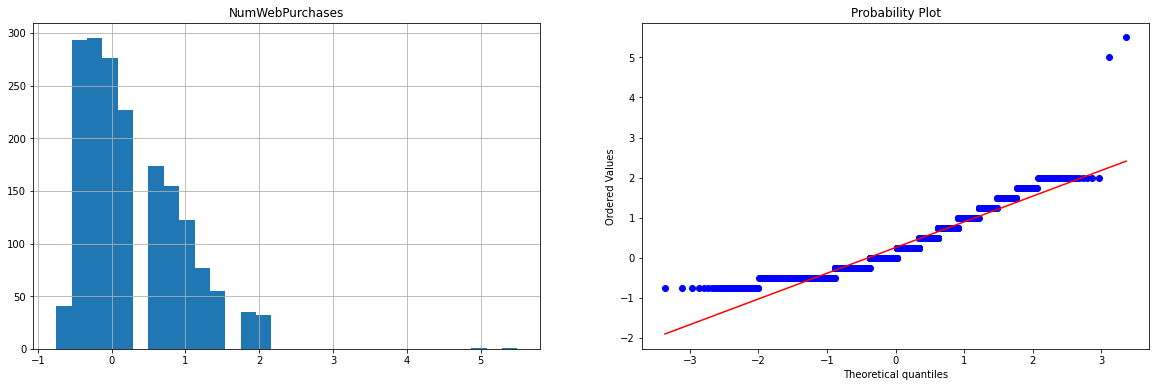

 scale:  [2.]


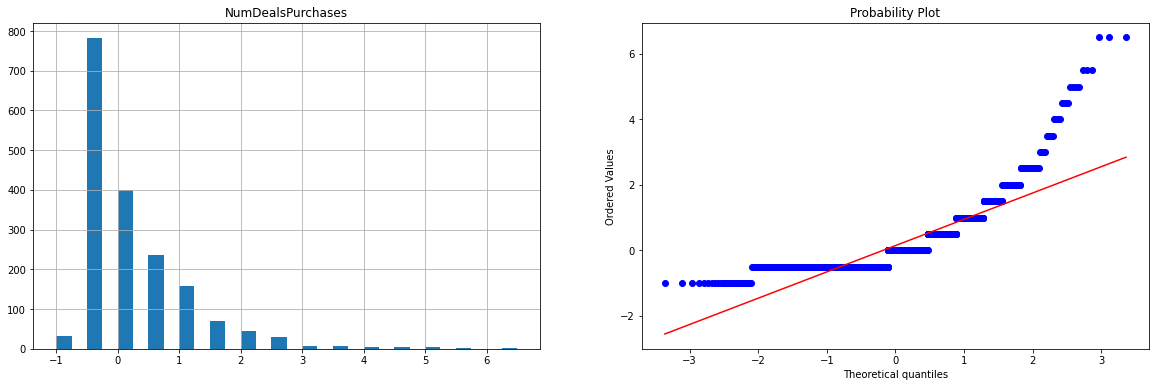

 scale:  [1.]


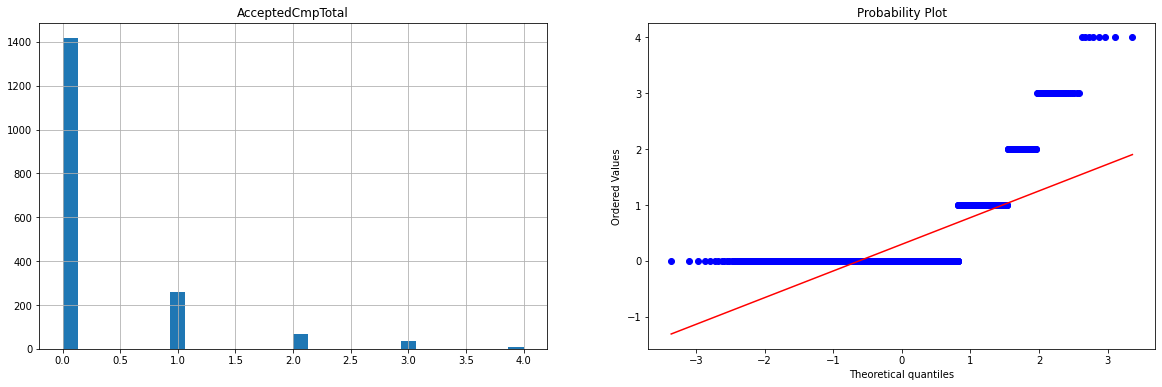

 scale:  [4.]


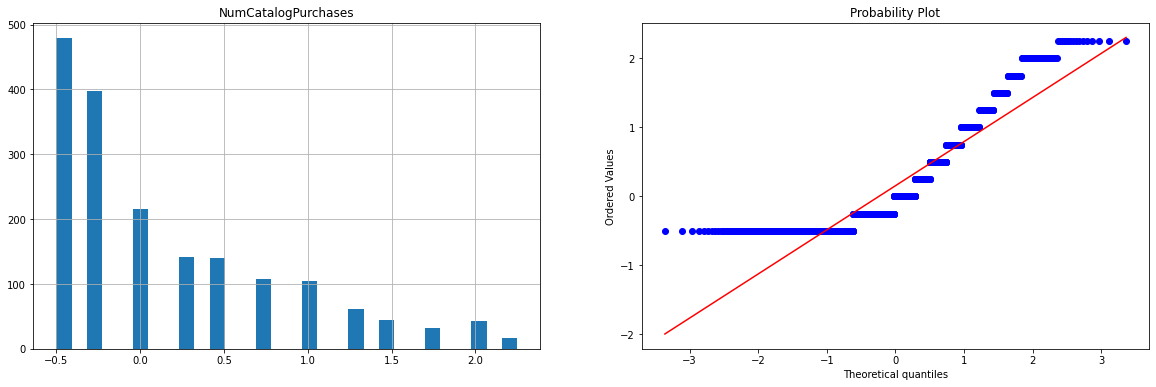

 scale:  [19.]


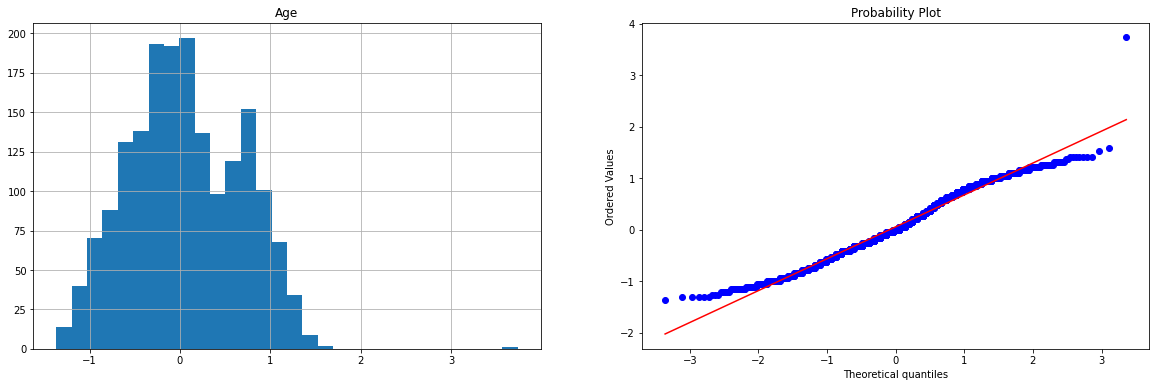

 scale:  [5.]


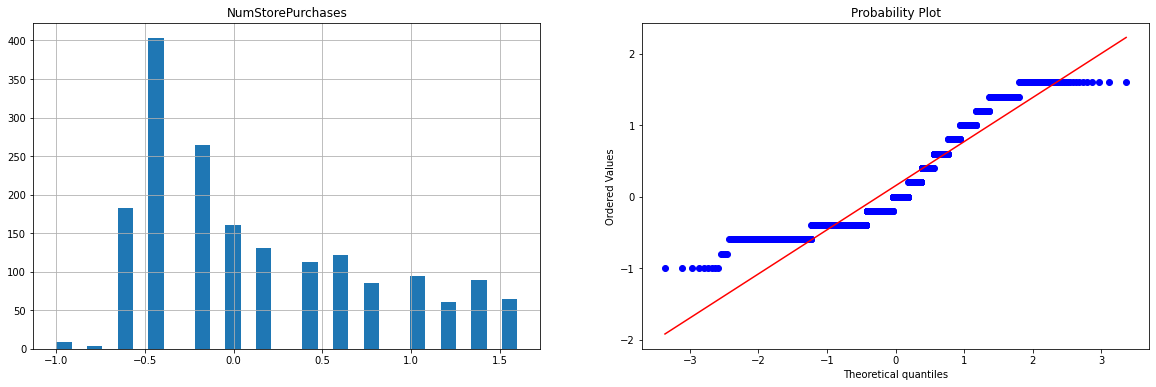

 scale:  [1.]


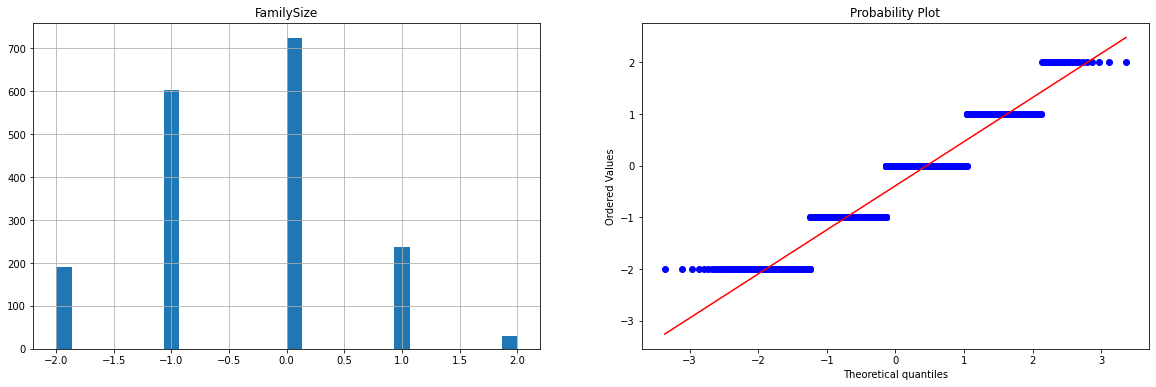

 scale:  [12.]


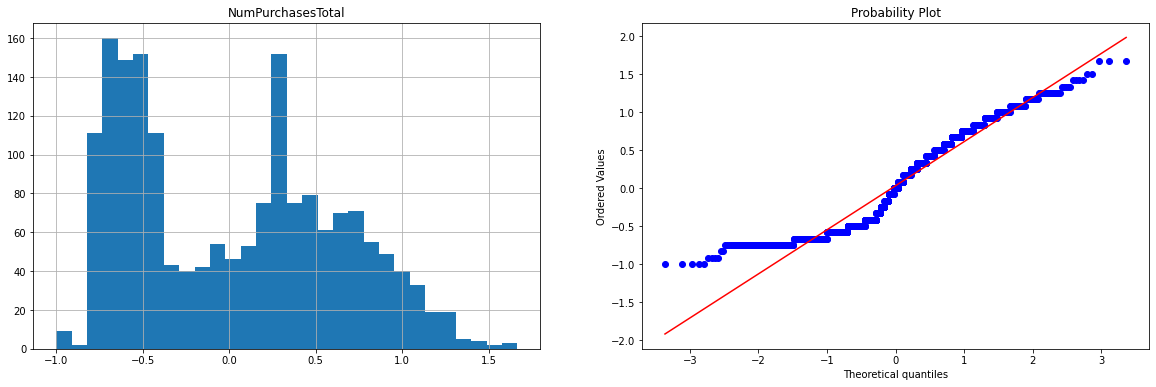

 scale:  [1.]


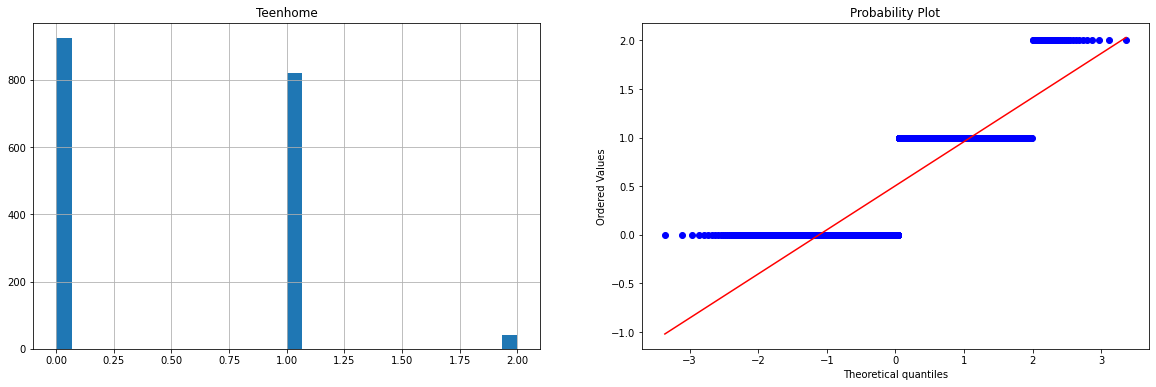

 scale:  [49.]


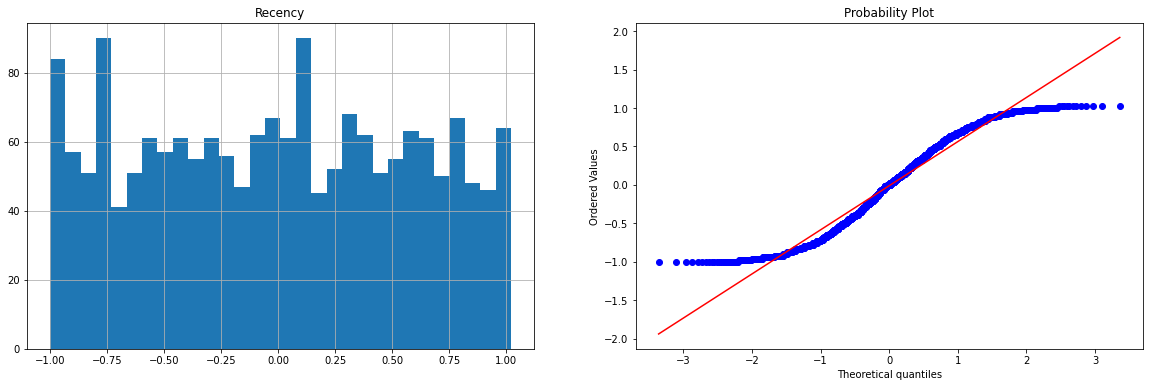

In [100]:
# studying viability of robustscaler
aux=df3.copy()
scaler = RobustScaler()
for var in discrete:
    aux[[var]]=scaler.fit_transform(aux[[var]].values)
    print(' scale: ', scaler.scale_)
    diagnostic_plots(aux, var)

### Robust scaling continuous and discrete variables

In [101]:
aux=df3.copy()
cols=continuous+discrete

In [102]:
scaler = RobustScaler()
cols=continuous+discrete
df3[cols]=scaler.fit_transform(df3[cols].values)

0.14041760450314728


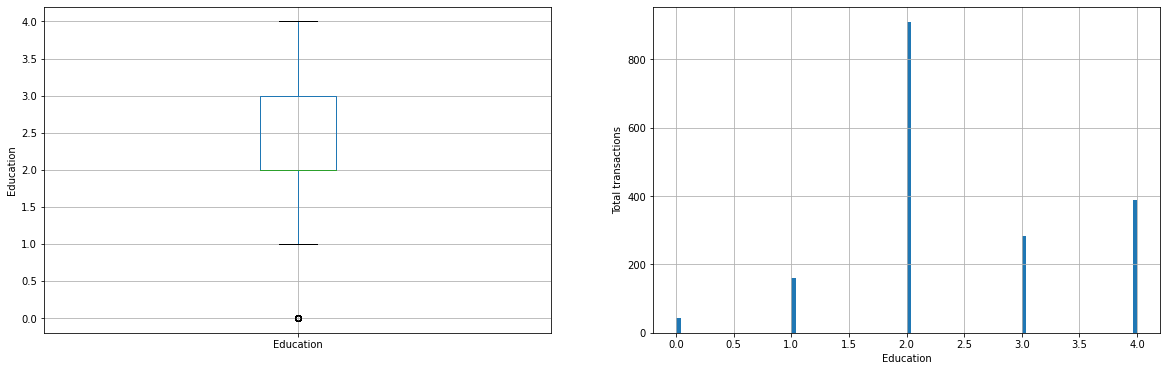

0.12425956378037756


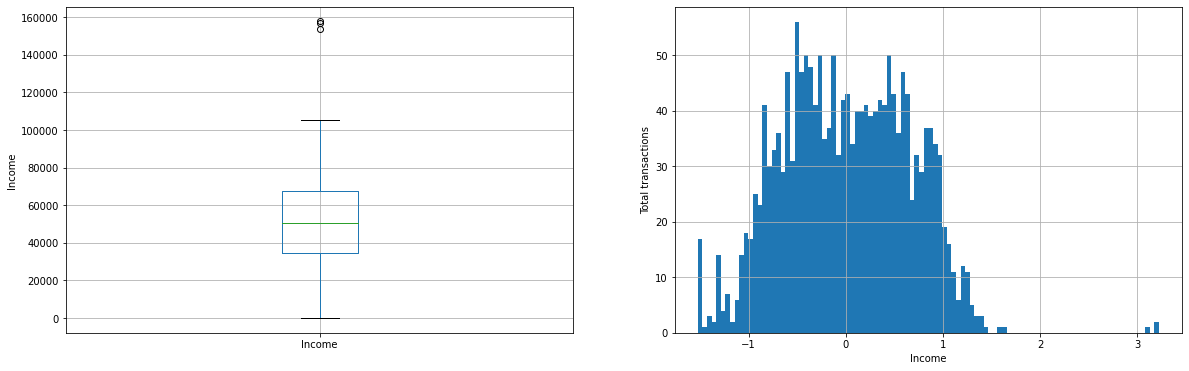

0.6225787475651087


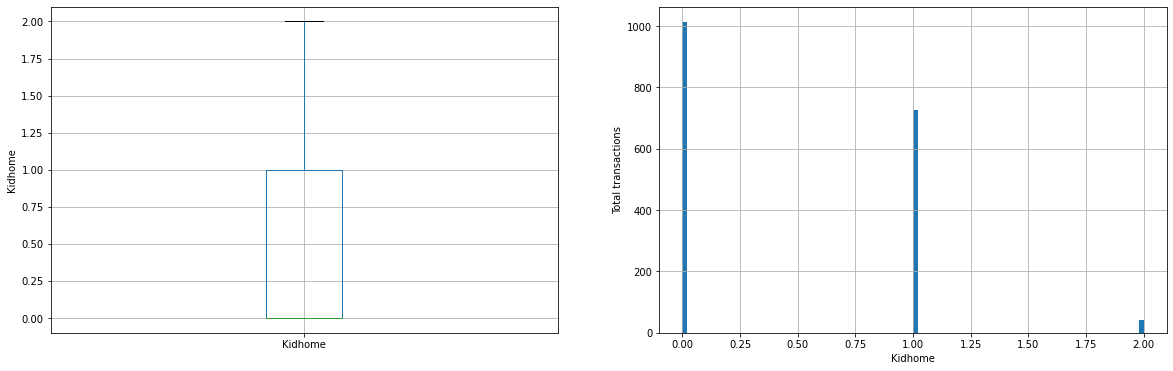

0.40861633641252293


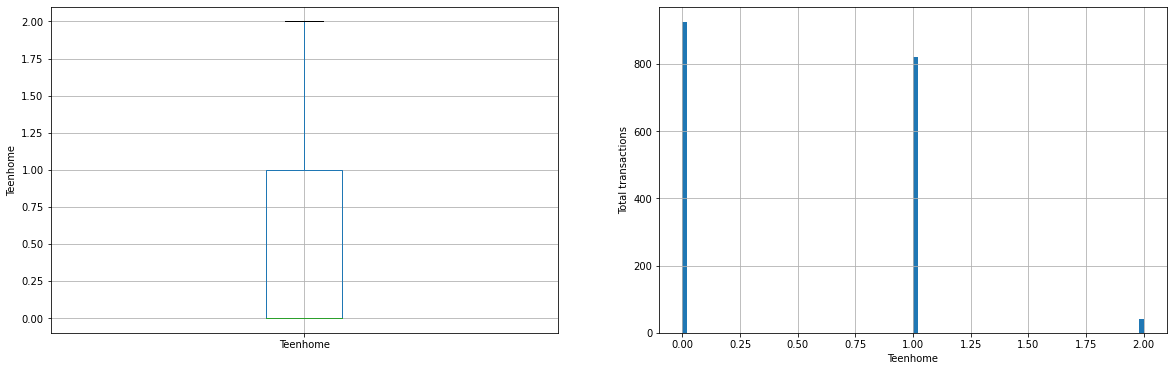

0.005503756608404881


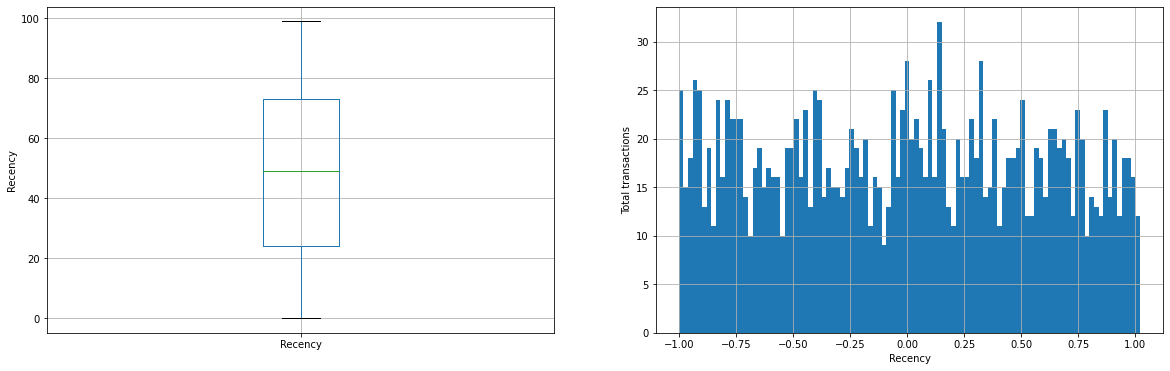

1.2278959408908903


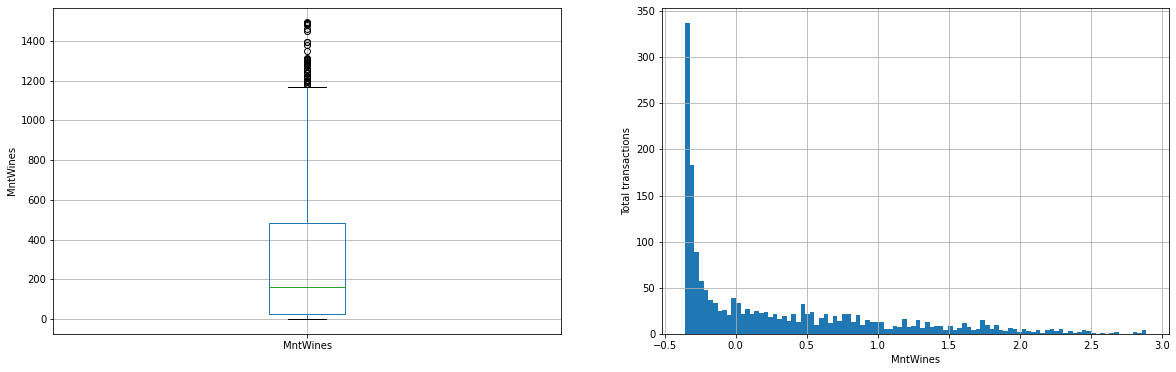

2.076886312066529


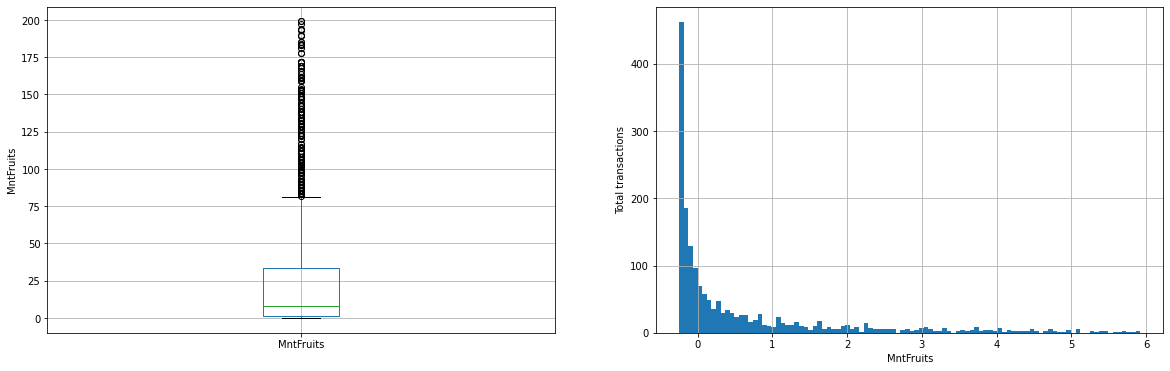

1.7326410052291308


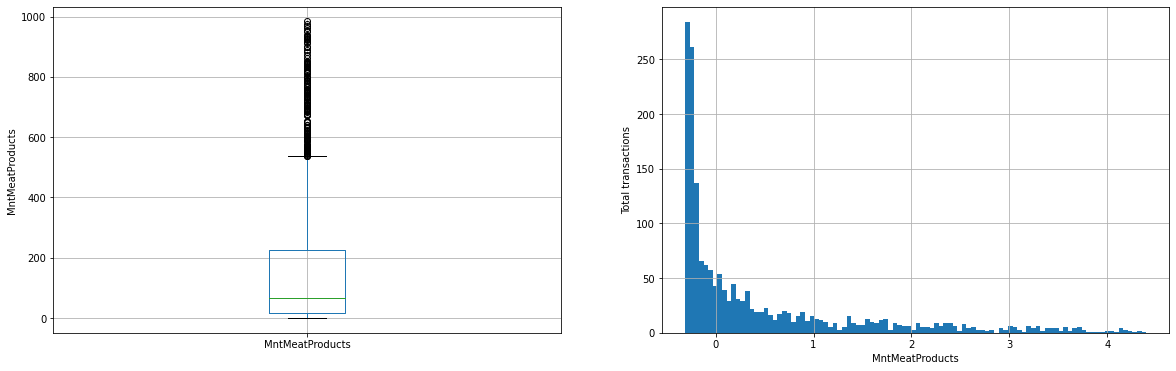

1.9123377404903312


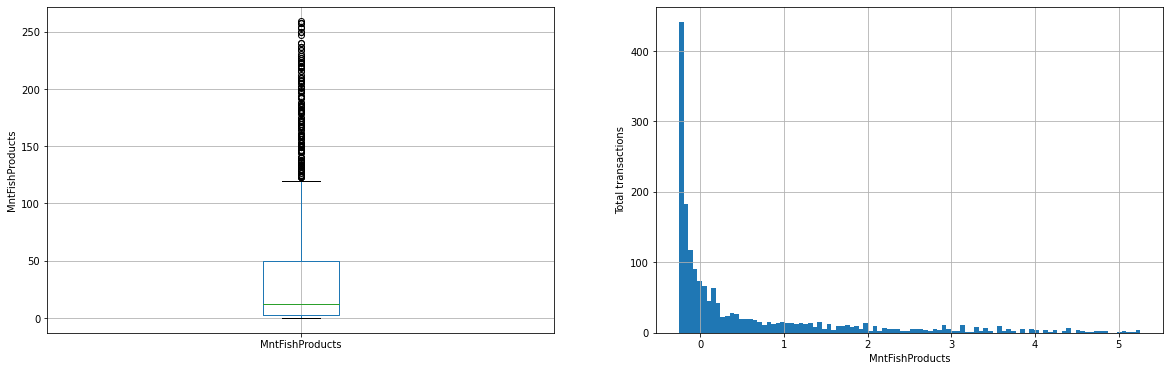

2.0504366563043503


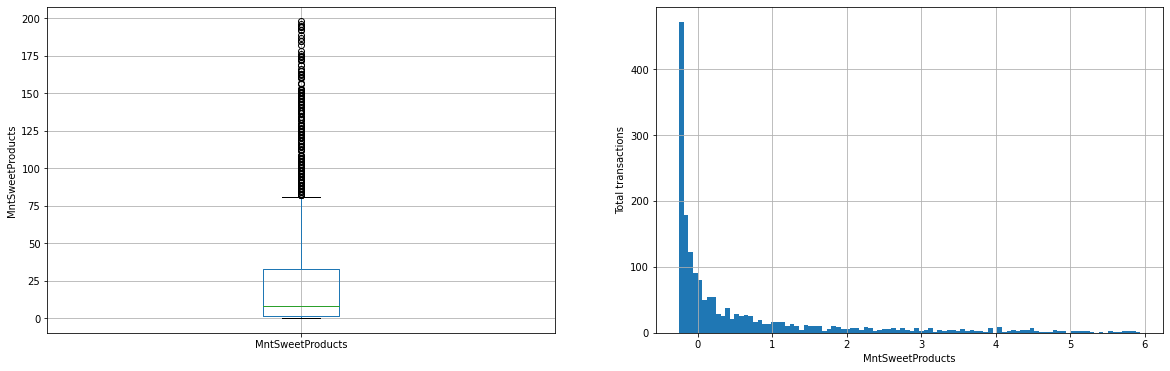

1.8578289670327564


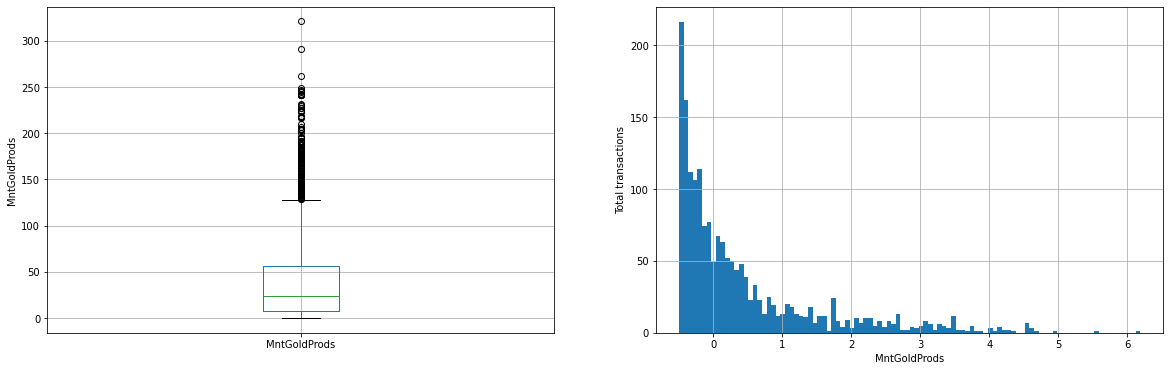

2.360558763460596


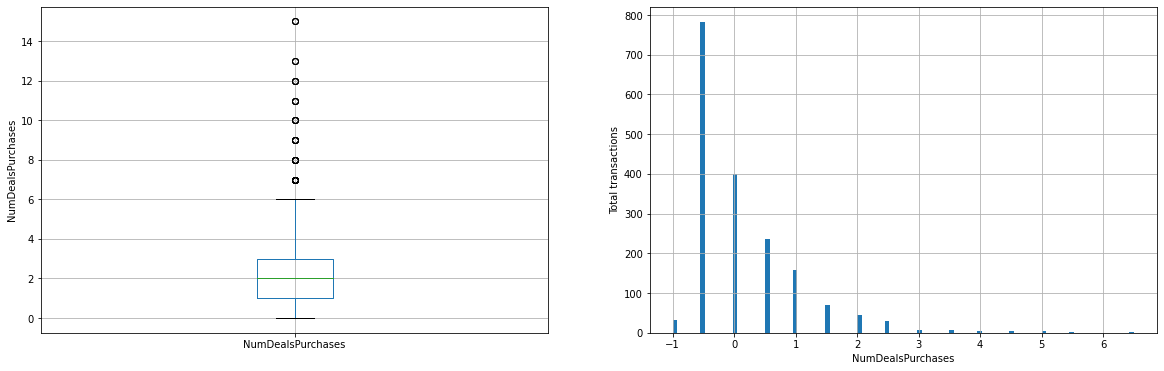

1.1003299993621525


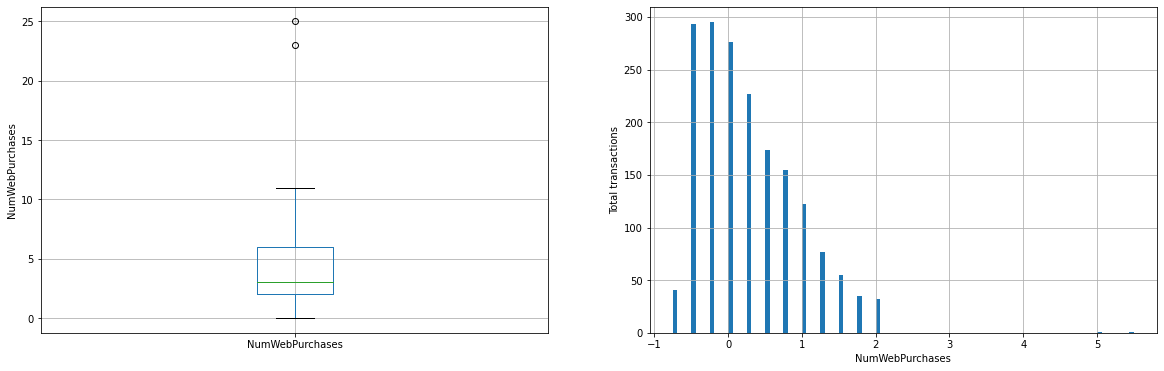

1.1239370277734249


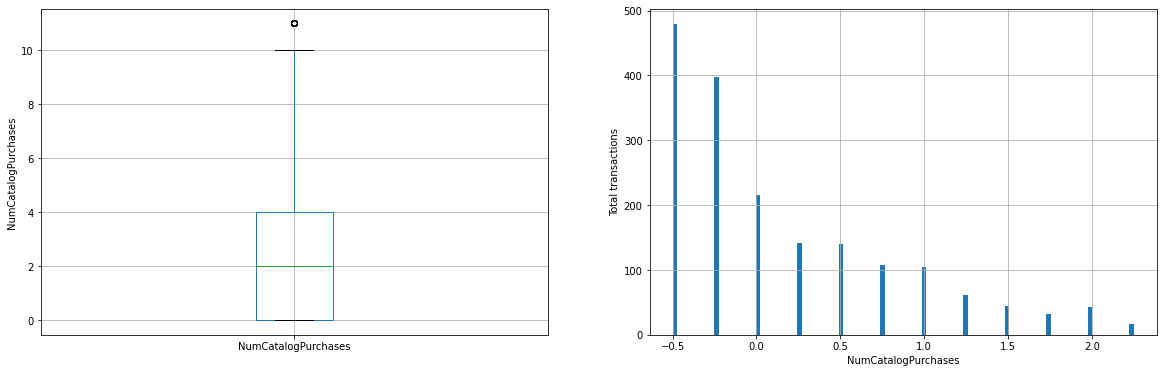

0.7252340894645232


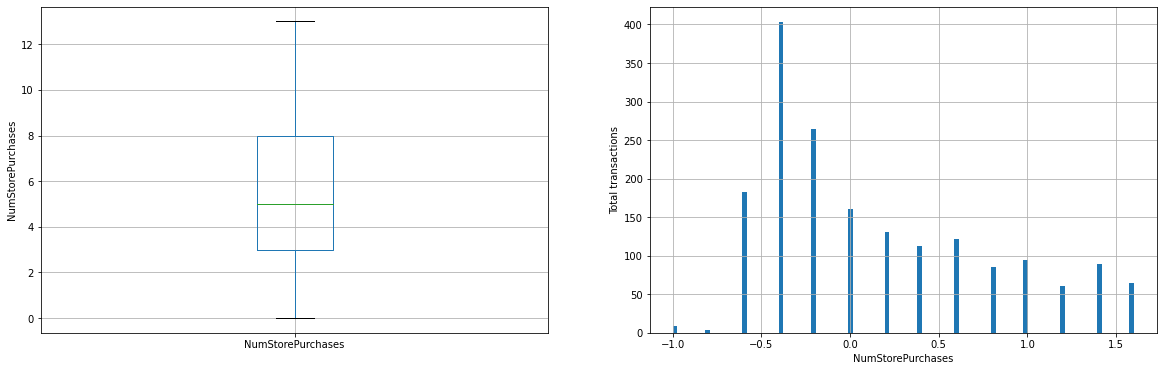

0.3282278575561393


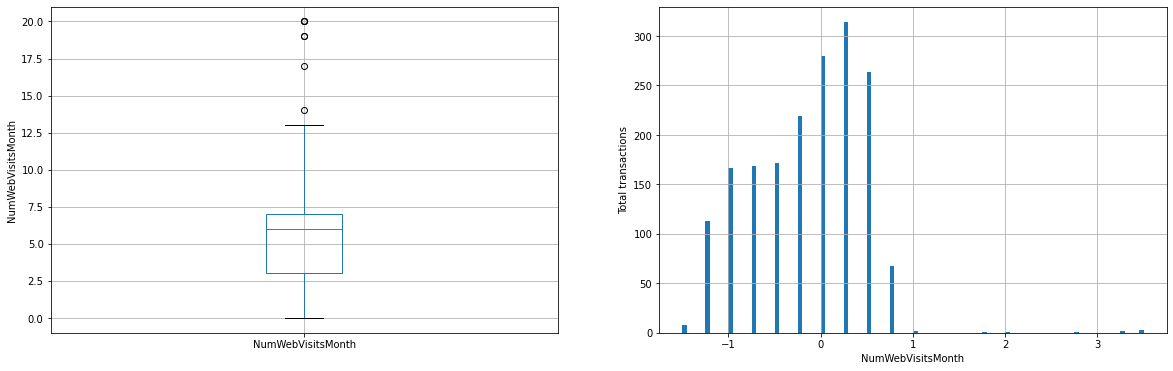

3.211545357148789


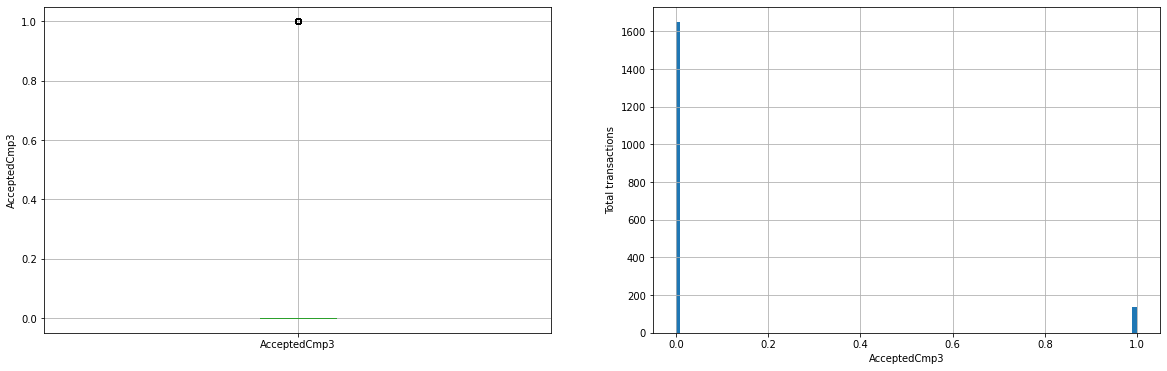

3.388377006820311


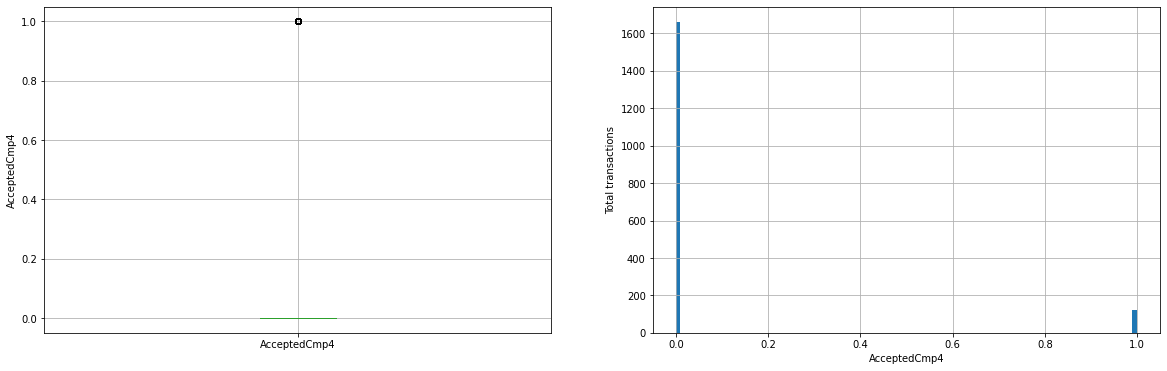

3.2267864673766313


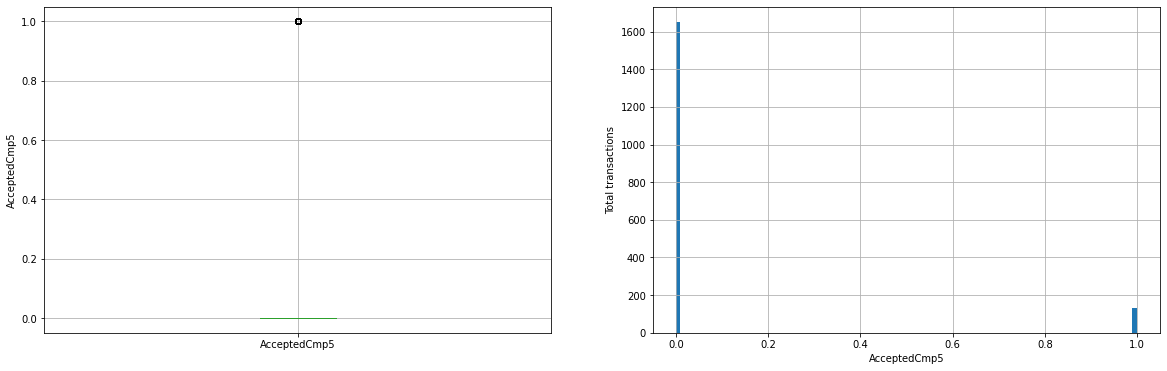

3.550089670222223


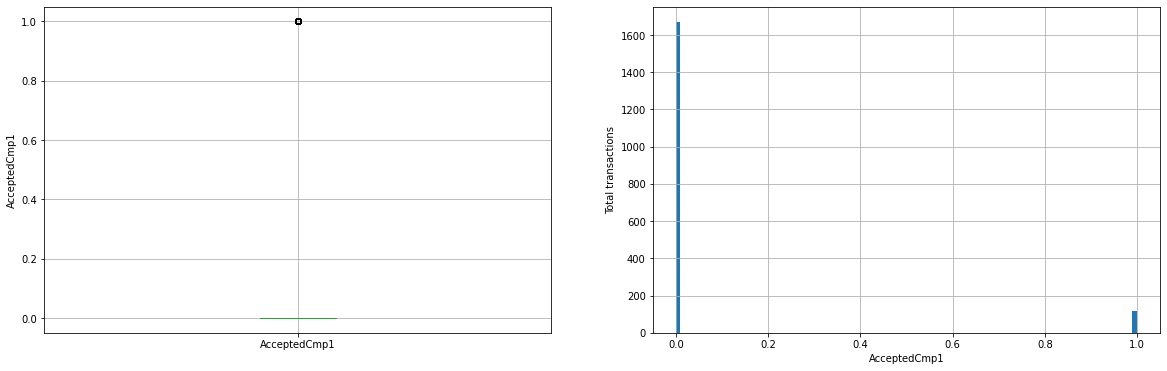

9.061033666957126


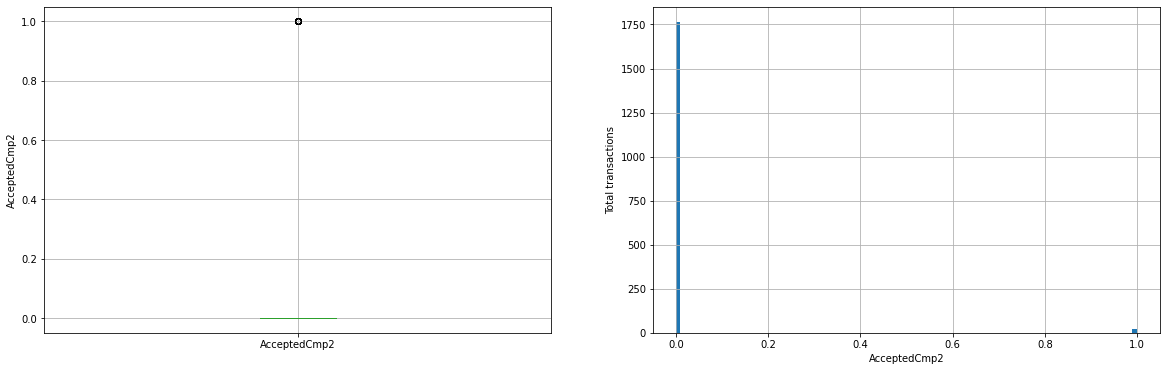

9.292821374497228


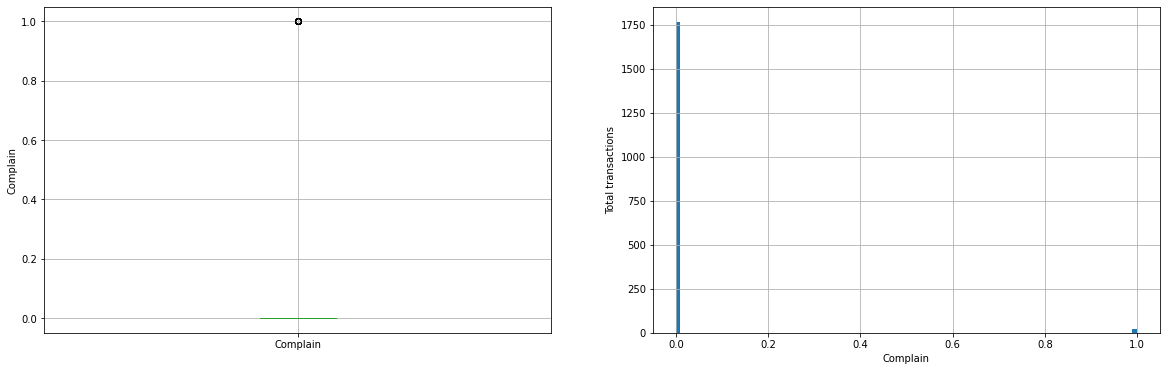

1.9781586047169655


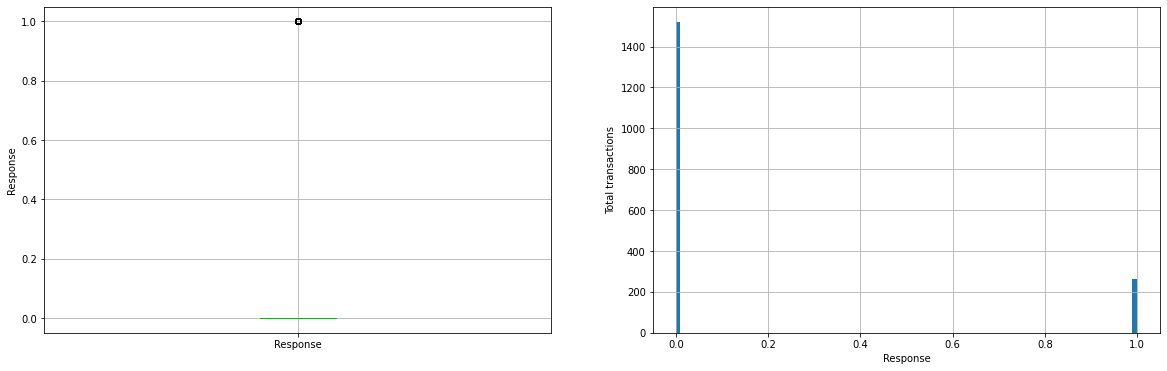

0.8956109656641315


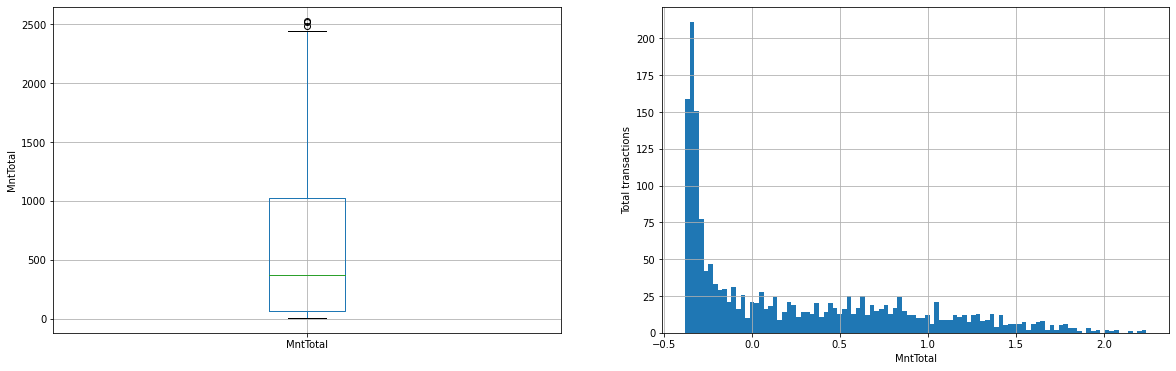

0.31749563175951073


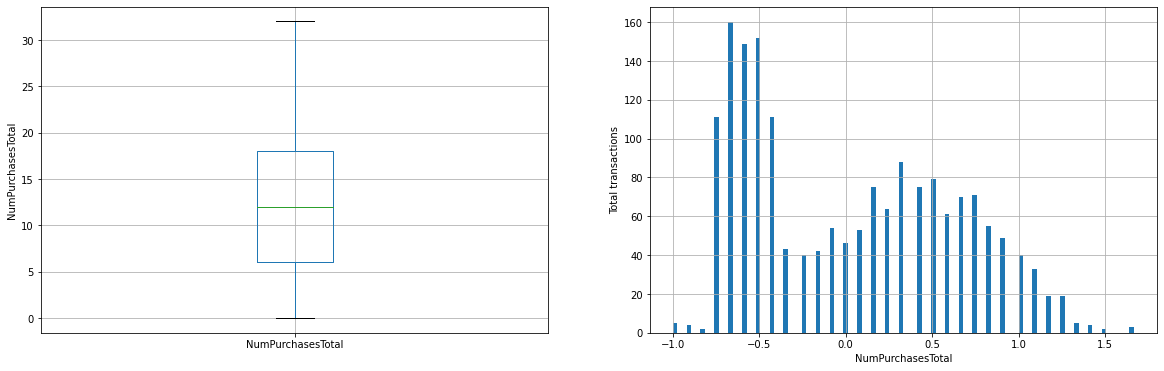

0.01752279278184423


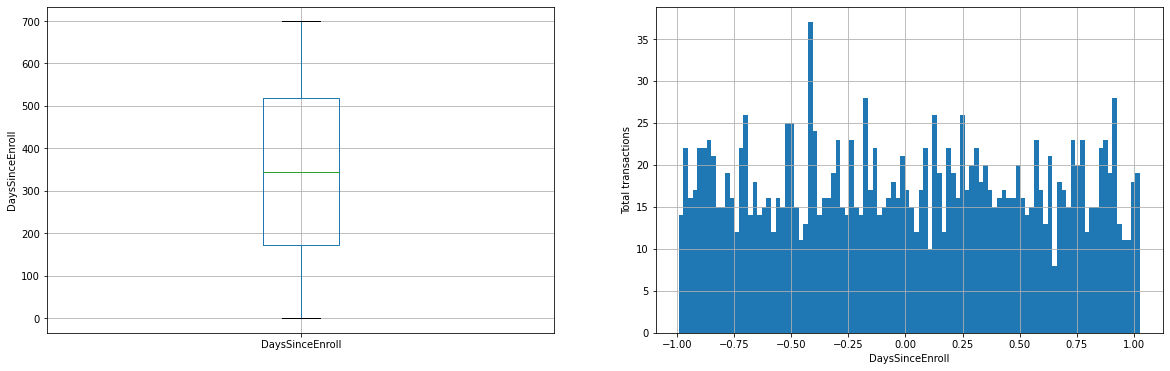

0.1935057226503562


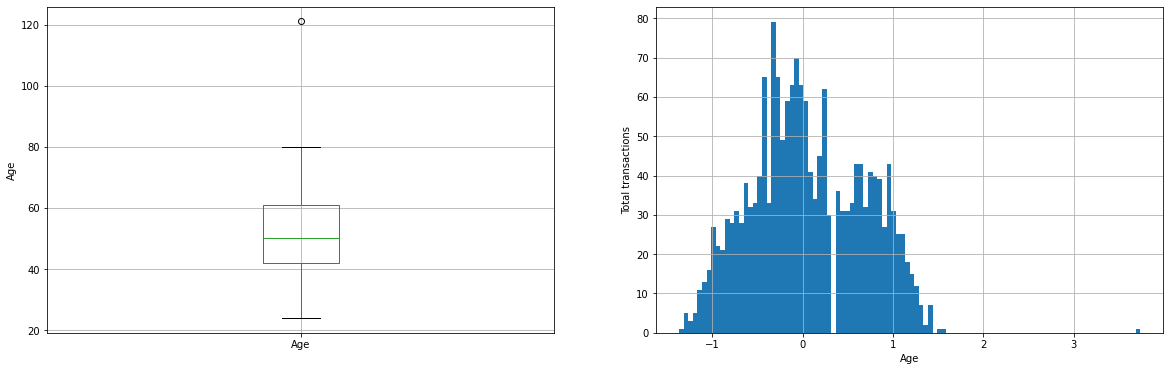

2.7132224852298723


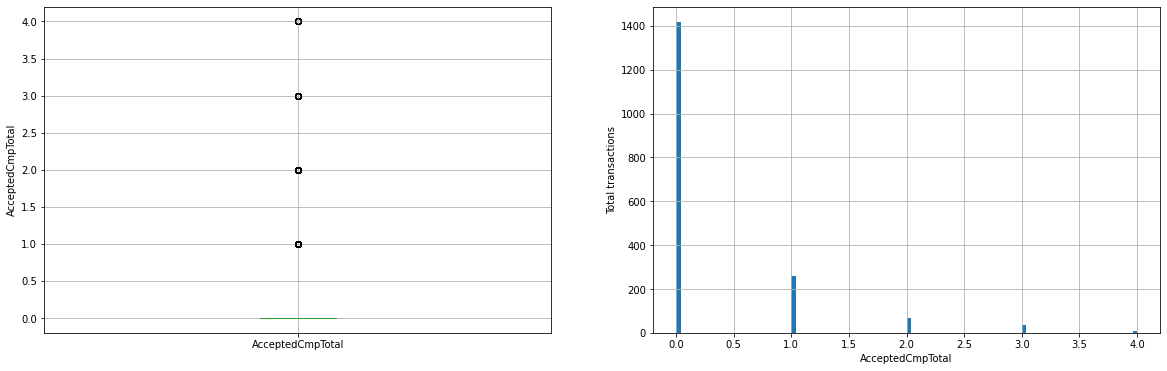

0.09854309668675354


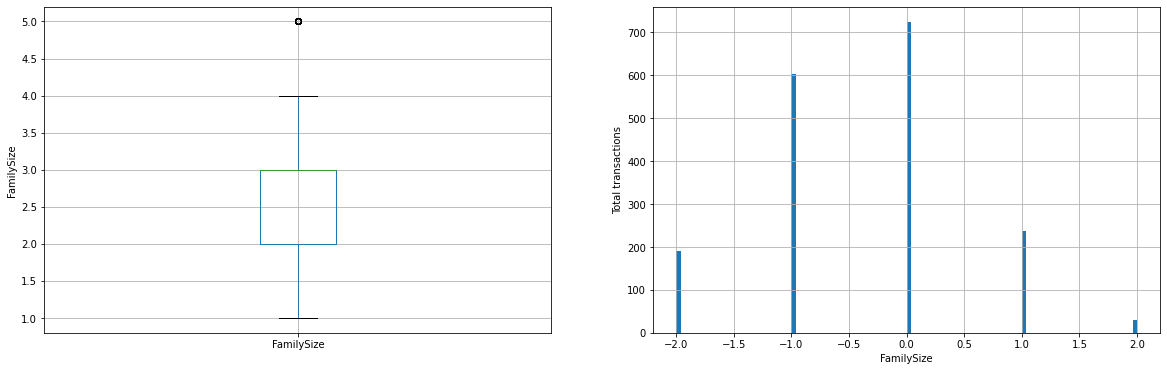

0.6409024941527195


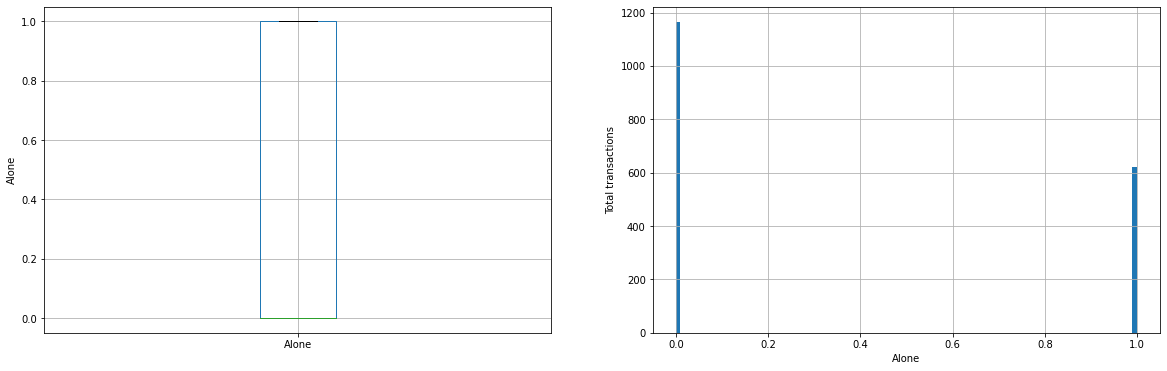

In [103]:
# boxplots to visualise outliersx and histograms to get an idea of the distribution
for var in df3.columns:
    print(df3[var].skew())
    plt.figure(figsize=(20,6))
    plt.subplot(1, 2, 1)
    fig = aux.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = df3[var].hist(bins=100)
    fig.set_ylabel('Total transactions')
    fig.set_xlabel(var)

    plt.show()

In [104]:
# Variables range is consistent
(df3.max() - df3.min())

Education              4.000000
Income                 4.748169
Kidhome                2.000000
Teenhome               2.000000
Recency                2.020408
MntWines               3.245652
MntFruits              6.170543
MntMeatProducts        4.708134
MntFishProducts        5.510638
MntSweetProducts       6.187500
MntGoldProds           6.687500
NumDealsPurchases      7.500000
NumWebPurchases        6.250000
NumCatalogPurchases    2.750000
NumStorePurchases      2.600000
NumWebVisitsMonth      5.000000
AcceptedCmp3           1.000000
AcceptedCmp4           1.000000
AcceptedCmp5           1.000000
AcceptedCmp1           1.000000
AcceptedCmp2           1.000000
Complain               1.000000
Response               1.000000
MntTotal               2.618862
NumPurchasesTotal      2.666667
DaysSinceEnroll        2.020231
Age                    5.105263
AcceptedCmpTotal       4.000000
FamilySize             4.000000
Alone                  1.000000
dtype: float64

# FEATURE SELECTION

In [105]:
df4=df3.copy()

In [106]:
# X and y for feature importance testing
X = df4.drop(['Response'],axis=1).values
y = df4['Response'].values.ravel()

## Desision tree feature importance

In [107]:
# define the model
model = RandomForestClassifier(n_estimators=500, n_jobs=-1 )
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_

<AxesSubplot:>

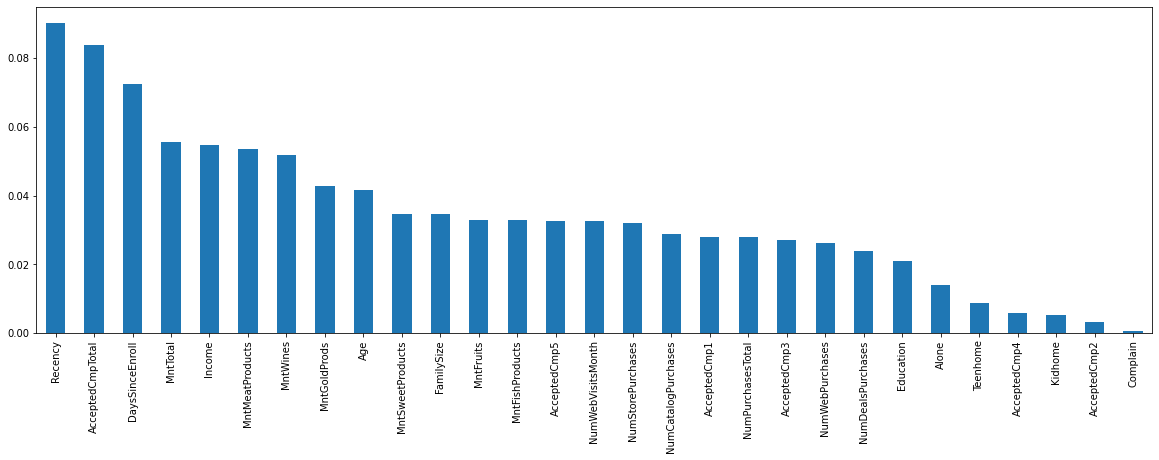

In [108]:
# summarize feature importance
importance=pd.Series(importance)
importance.index = df4.drop(['Response'],axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(20,6))

## Boruta method

In [109]:
# # define RandomForestRegressor
# rf = RandomForestClassifier( n_jobs=-1 )

# # define Boruta
# boruta = BorutaPy( rf, n_estimators=1000, verbose=0, random_state=SEED ).fit( X, y )

In [110]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_fs = df4.drop(['Response'],axis=1)
# cols_selected_boruta = X_fs.iloc[:, cols_selected].columns.to_list()
# print('cols selected: ',cols_selected_boruta)
# print('')
# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_fs.columns, cols_selected_boruta ) )
# print('cols not selected: ',cols_not_selected_boruta)

Columns selected by boruta:

cols selected:  ['Income', 'Recency', 'MntWines', 'MntMeatProducts', 'MntGoldProds', 'AcceptedCmp5', 'MntTotal', 'DaysSinceEnroll', 'AcceptedCmpTotal']

cols not selected:  ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'Age', 'Alone', 'Complain', 'Education', 'FamilySize', 'Kidhome', 'MntFishProducts', 'MntFruits', 'MntSweetProducts', 'NumCatalogPurchases', 'NumDealsPurchases', 'NumPurchasesTotal', 'NumStorePurchases', 'NumWebPurchases', 'NumWebVisitsMonth', 'Teenhome']

In [111]:
list(enumerate(importance.index))

[(0, 'Recency'),
 (1, 'AcceptedCmpTotal'),
 (2, 'DaysSinceEnroll'),
 (3, 'MntTotal'),
 (4, 'Income'),
 (5, 'MntMeatProducts'),
 (6, 'MntWines'),
 (7, 'MntGoldProds'),
 (8, 'Age'),
 (9, 'MntSweetProducts'),
 (10, 'FamilySize'),
 (11, 'MntFruits'),
 (12, 'MntFishProducts'),
 (13, 'AcceptedCmp5'),
 (14, 'NumWebVisitsMonth'),
 (15, 'NumStorePurchases'),
 (16, 'NumCatalogPurchases'),
 (17, 'AcceptedCmp1'),
 (18, 'NumPurchasesTotal'),
 (19, 'AcceptedCmp3'),
 (20, 'NumWebPurchases'),
 (21, 'NumDealsPurchases'),
 (22, 'Education'),
 (23, 'Alone'),
 (24, 'Teenhome'),
 (25, 'AcceptedCmp4'),
 (26, 'Kidhome'),
 (27, 'AcceptedCmp2'),
 (28, 'Complain')]

In [112]:
# Final columns selected for Machine Learning
cols_selected=['Recency', 'AcceptedCmpTotal', 'DaysSinceEnroll', 'MntTotal',
'MntMeatProducts', 'Income', 'MntWines', 'MntGoldProds', 'Age',
'MntSweetProducts', 'FamilySize', 'MntFruits', 'MntFishProducts',
'AcceptedCmp5', 'NumStorePurchases', 'NumWebVisitsMonth',
'NumCatalogPurchases', 'NumPurchasesTotal']

# CUSTOMER SEGMENTATION

**Analysis**

**Cluster 0: Medium value clients**

Population: 475

Characteristics:
* 15% gave positive response to last campaign
* Medium income (~59k)
* Amount spent on products (~711)
* Spends considerably more on wines than any other product (~495)
* Enjoys using discounts (~3.5 products)
* Enjoys buying from the web (~6 products)
* Doesn't live alone
* High education (higher chance of having at least a master degree)

**Cluster 1: Low value clients**

Population: 859

Characteristics:
* Only 8% gave positive response to last campaign
* Low income (~35k)
* Amount spent on products (~82)
* On average the most veteran of customers are within this cluster (~380 days)
* Does't like participating on campaigns
* Doesn't live alone
* On average graduated

**Cluster 2: High value clients**

Population: 450

Characteristics: 
* 27% gave positive response to last campaign
* Higher income (~74k)
* Amount spent on products (~1276)
* Likes partipating on campaigns
* Does't visit website often
* Likes buying from catalogs (~5.7 products)
* Doesn't usually buy using discounts (~1.5 products)
* Lives alone (single)
* On average graduated

In [369]:
df4.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'MntTotal', 'NumPurchasesTotal',
       'DaysSinceEnroll', 'Age', 'AcceptedCmpTotal', 'FamilySize', 'Alone'],
      dtype='object')

In [370]:
# Manual feature selection for customer segmentation
df=df4.drop(['MntTotal', 'NumPurchasesTotal','Kidhome', 'Teenhome','Alone','Complain'],axis=1)
df=df.reset_index(drop=True)

In [371]:
from sklearn.cluster import KMeans

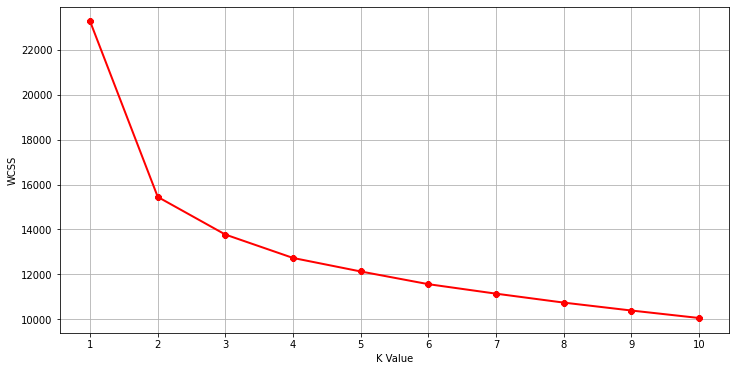

In [372]:
# The elbow method
# Calculate the Within Cluster Sum of Squared Errors (WSS) for different values of k, and choose the k for which WSS first starts to decrease linearly.
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=SEED)
    kmeans.fit(df.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

# K=3

In [373]:
kmeans = KMeans(init="k-means++", n_clusters=3, random_state=SEED)

kmeans.fit(df)

KMeans(n_clusters=3, random_state=42)

In [374]:
customer_clusters = kmeans.predict(df)

In [375]:
customer_clusters = pd.Series(customer_clusters,name='cluster')

In [376]:
# cluster population
customer_clusters.value_counts().sort_index()

0    475
1    859
2    450
Name: cluster, dtype: int64

In [377]:
# Inverse Robust Scale df4
df4_inv=scaler.inverse_transform(df4[continuous+discrete])
df4_inv=pd.DataFrame(df4_inv,columns=continuous+discrete)
cat_cols=list(set(df4.columns)-set(df4_inv.columns))
df4_inv=pd.concat([df4_inv,df4[cat_cols].reset_index(drop=True)],axis=1)
df4_inv.head(3)

Income  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  16813.0       4.0        8.0             11.0     1.200000e+01   
1  64191.0     420.0       15.0            186.0     1.510000e+02   
2  71969.0    1000.0        0.0             76.0     1.776357e-15   

   MntSweetProducts  MntGoldProds  MntTotal  DaysSinceEnroll  \
0               2.0          13.0      50.0            354.0   
1              38.0          15.0     825.0            176.0   
2               0.0          10.0    1086.0             78.0   

   NumWebVisitsMonth  ...  Recency  AcceptedCmp1  AcceptedCmp3  Response  \
0                7.0  ...     49.0             0             1         0   
1                3.0  ...     30.0             0             0         0   
2                8.0  ...     59.0             0             0         0   

   AcceptedCmp4  Alone  AcceptedCmp2  Complain  AcceptedCmp5  Education  
0             0      1             0         0             0          2  
1             0      1             0         0             0          3  
2             1      0             0         0             0          4  

[3 rows x 30 columns]

In [378]:
# add customer clusters to df4
df_=pd.concat([df4_inv,customer_clusters],axis=1)

In [379]:
# drop columns that were not used during clustering
df_=df_.drop(['MntTotal', 'NumPurchasesTotal','Kidhome', 'Teenhome','Alone','Complain'],axis=1)

In [380]:
df_

Income  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0     16813.0       4.0        8.0             11.0     1.200000e+01   
1     64191.0     420.0       15.0            186.0     1.510000e+02   
2     71969.0    1000.0        0.0             76.0     1.776357e-15   
3     29187.0      26.0        0.0              6.0     1.776357e-15   
4      4428.0      16.0        4.0             12.0     2.000000e+00   
...       ...       ...        ...              ...              ...   
1779  44078.0      24.0        1.0             10.0     2.000000e+00   
1780  61825.0     162.0       50.0            100.0     5.500000e+01   
1781  67381.0     815.0        8.0             53.0     1.100000e+01   
1782  48918.0      52.0        0.0              9.0     1.776357e-15   
1783  23228.0      13.0        2.0             18.0     6.000000e+00   

      MntSweetProducts  MntGoldProds  DaysSinceEnroll  NumWebVisitsMonth  \
0                  2.0          13.0            354.0                7.0   
1                 38.0          15.0            176.0                3.0   
2                  0.0          10.0             78.0                8.0   
3                  0.0           2.0            283.0                8.0   
4                  4.0         321.0            432.0                1.0   
...                ...           ...              ...                ...   
1779               0.0           4.0            689.0                5.0   
1780              30.0          27.0            373.0                4.0   
1781               0.0          70.0            169.0                7.0   
1782               0.0           1.0            621.0                4.0   
1783               1.0           0.0            545.0                8.0   

      NumWebPurchases  ...  FamilySize  Recency  AcceptedCmp1  AcceptedCmp3  \
0                 2.0  ...         1.0     49.0             0             1   
1                 5.0  ...         2.0     30.0             0             0   
2                 3.0  ...         3.0     59.0             0             0   
3                 1.0  ...         3.0     43.0             0             0   
4                25.0  ...         3.0      0.0             0             0   
...               ...  ...         ...      ...           ...           ...   
1779              2.0  ...         4.0     17.0             0             0   
1780              4.0  ...         2.0     56.0             0             0   
1781              2.0  ...         3.0     67.0             0             0   
1782              1.0  ...         3.0     21.0             0             0   
1783              2.0  ...         3.0     71.0             0             0   

      Response  AcceptedCmp4  AcceptedCmp2  AcceptedCmp5  Education  cluster  
0            0             0             0             0          2        1  
1            0             0             0             0          3        0  
2            0             1             0             0          4        0  
3            0             0             0             0          4        1  
4            0             0             0             0          2        0  
...        ...           ...           ...           ...        ...      ...  
1779         0             0             0             0          2        1  
1780         0             0             0             0          2        0  
1781         0             1             0             0          3        0  
1782         0             0             0             0          4        1  
1783         0             0             0             0          2        1  

[1784 rows x 25 columns]

In [381]:
# group by clusters
aux=df_.groupby('cluster').mean()
aux=aux.transpose()
aux

cluster                         0             1             2
Income               58897.734737  34599.083818  73725.391111
MntWines               494.492632     43.415600    569.940000
MntFruits               20.311579      4.712456     75.306667
MntMeatProducts        149.197895     22.380675    447.157778
MntFishProducts         28.690526      6.505239    106.371111
MntSweetProducts        18.953684      4.756694     77.253333
MntGoldProds            59.972632     13.982538     83.166667
DaysSinceEnroll        306.743158    379.018626    325.844444
NumWebVisitsMonth        5.416842      6.416764      3.146667
NumWebPurchases          6.061053      2.096624      5.453333
NumDealsPurchases        3.473684      2.034924      1.526667
AcceptedCmpTotal         0.387368      0.084983      0.604444
NumCatalogPurchases      3.402105      0.533178      5.757778
Age                     54.747368     48.675204     51.760000
NumStorePurchases        7.724211      3.233993      8.520000
FamilySize               2.749474      2.908033      1.908889
Recency                 46.229474     48.838184     50.215556
AcceptedCmp1             0.054737      0.001164      0.195556
AcceptedCmp3             0.088421      0.067520      0.077778
Response                 0.155789      0.080326      0.271111
AcceptedCmp4             0.153684      0.015134      0.084444
AcceptedCmp2             0.023158      0.001164      0.020000
AcceptedCmp5             0.067368      0.000000      0.226667
Education                2.783158      2.334109      2.351111

In [398]:
# comparison between high and low value clients (ratio)
aux[2]/aux[1]

Income                   2.130848
MntWines                13.127540
MntFruits               15.980343
MntMeatProducts         19.979638
MntFishProducts         16.351608
MntSweetProducts        16.240972
MntGoldProds             5.947895
DaysSinceEnroll          0.859706
NumWebVisitsMonth        0.490382
NumWebPurchases          2.601007
NumDealsPurchases        0.750233
AcceptedCmpTotal         7.112572
NumCatalogPurchases     10.798976
Age                      1.063375
NumStorePurchases        2.634514
FamilySize               0.656419
Recency                  1.028203
AcceptedCmp1           167.982222
AcceptedCmp3             1.151916
Response                 3.375137
AcceptedCmp4             5.579829
AcceptedCmp2            17.180000
AcceptedCmp5                  inf
Education                1.007284
dtype: float64

In [395]:
# total amount spent on products
aux.loc[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts','MntSweetProducts']].sum(axis=0)

cluster
0     711.646316
1      81.770664
2    1276.028889
dtype: float64

In [382]:
# normalize every column with max value to plot
norm=aux.copy()
for var in aux.columns:
    norm.loc[:,var]/=df_.max()

(0.0, 1.0)

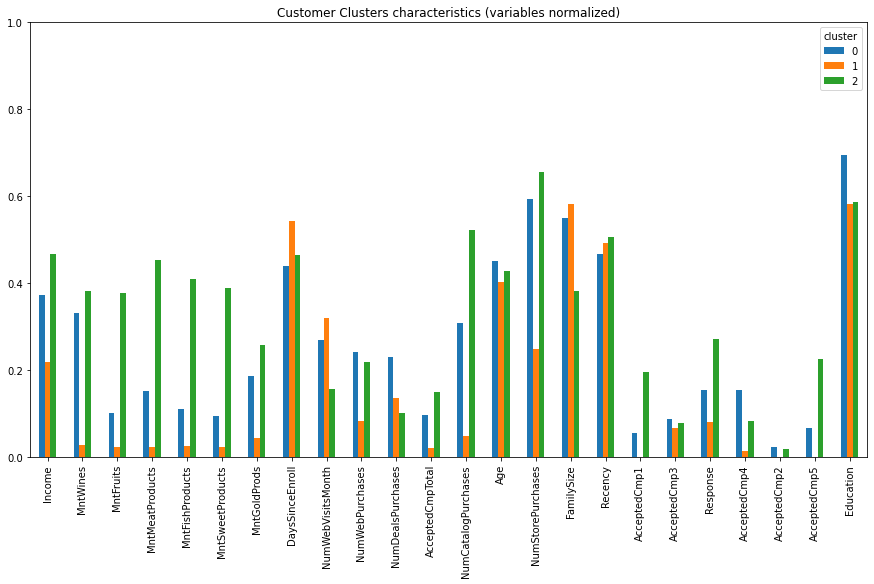

In [383]:
# plt.figure(figsize=(15,8))
fig=norm.plot.bar(figsize=(15,8))
# fig.set_ylabel('Given positive response to ratio of count of given label on positive set over count of given label on negative set')
fig.set_title('Customer Clusters characteristics (variables normalized)')
fig.set_ylim(0,1)
# fig.set_legend('')
# plt.axhline(y=0, color='k', linestyle='--')
# for p in fig.patches:
#     fig.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# MACHINE LEARNING

**Winner**: Neural net

In [113]:
df5=df4[cols_selected+['Response']]

## Baseline

random choice

In [171]:
# Split dataset into training and test
X=df5.drop(['Response'],axis=1)
y=df5['Response']
x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.2, random_state=SEED )

In [172]:
response_weights=df5['Response'].value_counts( normalize=True ).sort_index().tolist()
k_num = y_validation.shape[0]
yhat_random = random.choices( population=[0, 1],  
                              weights=response_weights,
                              k=k_num )

  Model Name  Accuracy  Balanced accuracy  F1 score  Kappa Metrics
0     random  0.708683           0.478405  0.133333      -0.040816 



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

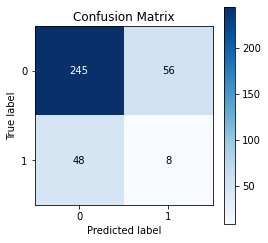

In [173]:
print( ml_error('random',y_validation,yhat_random), '\n' )

# # Classification report
# print( m.classification_report( y_test, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_validation, yhat_random, normalize=False, figsize=(4,4))

## Testing ML models

In [114]:
target=['Response']
KNN = KNeighborsClassifier(n_neighbors=3)
KNN3_cv = cross_validation( target, df5, 5, 'KNN-3', KNN)
KNN = KNeighborsClassifier(n_neighbors=5)
KNN5_cv = cross_validation( target, df5, 5, 'KNN-5', KNN)
KNN = KNeighborsClassifier(n_neighbors=10)
KNN10_cv = cross_validation( target, df5, 5, 'KNN-10', KNN)
lg = LogisticRegression()
lg_cv = cross_validation( target, df5, 5, 'Logistic Regression', lg)
dtc = DecisionTreeClassifier()
dtc_cv = cross_validation( target, df5, 5, 'Decision Tree', dtc)
rfc = RandomForestClassifier()
rfc_cv = cross_validation( target, df5, 5, 'Random Forest', rfc)
xgbc = xgb.XGBClassifier(max_depth=10)
xgbc_cv = cross_validation( target, df5, 5, 'XGBoost', xgbc)
svm = SVC(kernel='linear')
svm_cv_l = cross_validation( target, df5, 5, 'SVM_linear', svm)
svm = SVC()
svm_cv_rbf = cross_validation( target, df5, 5, 'SVM_rbf', svm)

In [115]:
model = ml.Sequential()
NN_cv = cross_validation( target, df5, 5, 'Neural Net', model)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1427 samples, validate on 357 samples
Epoch 1/20
1427/1427 [==============================] - 0s 177us/sample - loss: 0.4380 - acc: 0.8374 - val_loss: 0.3167 - val_acc: 0.8768
Epoch 2/20
1427/1427 [==============================] - 0s 61us/sample - loss: 0.2814 - acc: 0.8844 - val_loss: 0.2811 - val_acc: 0.8936
Epoch 3/20
1427/1427 [==============================] - 0s 59us/sample - loss: 0.2469 - acc: 0.8977 - val_loss: 0.2846 - val_acc: 0.8936
Epoch 4/20
1427/1427 [==============================] - 0s 59us/sample - loss: 0.2425 - acc: 0.8963 - val_loss: 0.2619 - val_acc: 0.8936
Epoch 5/20
1427/1427 [==============================] - 0s 60us/sample - loss: 0.2237 - acc: 0.9040 - val_loss: 0.2671 - val_acc: 0.8824
Epoch 6/20
1427/1427 [==============================] -

In [116]:
#winner: Neural net
modelling_result_cv = pd.concat( [
    KNN3_cv,
    KNN5_cv,
    KNN10_cv,
    lg_cv,
    dtc_cv,
    rfc_cv,
    xgbc_cv,
    svm_cv_l,
    svm_cv_rbf,
    NN_cv] )
modelling_result_cv

Model Name             ACC CV    Balanced ACC CV  \
0                KNN-3  0.8643 +/- 0.0106  0.6478 +/- 0.0246   
0                KNN-5  0.8683 +/- 0.0039  0.6283 +/- 0.0164   
0               KNN-10    0.866 +/- 0.007  0.5724 +/- 0.0242   
0  Logistic Regression  0.8963 +/- 0.0084  0.7164 +/- 0.0221   
0        Decision Tree  0.8431 +/- 0.0138   0.6976 +/- 0.037   
0        Random Forest  0.8812 +/- 0.0053  0.6607 +/- 0.0145   
0              XGBoost  0.8969 +/- 0.0054  0.7416 +/- 0.0302   
0           SVM_linear  0.8896 +/- 0.0072   0.6906 +/- 0.011   
0              SVM_rbf   0.8879 +/- 0.005  0.6538 +/- 0.0202   
0           Neural Net  0.9238 +/- 0.0207  0.8151 +/- 0.0656   

               F1 CV           Kappa CV  
0  0.4254 +/- 0.0506  0.3545 +/- 0.0537  
0  0.3915 +/- 0.0352  0.3291 +/- 0.0333  
0  0.2522 +/- 0.0684   0.2126 +/- 0.063  
0   0.568 +/- 0.0404  0.5129 +/- 0.0438  
0    0.48 +/- 0.0568  0.3877 +/- 0.0641  
0  0.4641 +/- 0.0292    0.4059 +/- 0.03  
0  0.5977 +/- 0.0397  0.5406 +/- 0.0407  
0  0.5231 +/- 0.0238  0.4664 +/- 0.0274  
0   0.4577 +/- 0.044   0.4084 +/- 0.042  
0  0.7142 +/- 0.0939  0.6711 +/- 0.1044

# HYPERPARAMETER FINE TUNING

Best parameters for neural net: {'layer 3': 32, 'layer 2': 128, 'layer 1': 2056, 'dropout_rate': 0.2}

In [400]:
df6=df5.copy()

In [401]:
X=df6.drop('Response',axis=1)
y=df6['Response']

In [402]:
# Function to create model, required for KerasClassifier
def create_model(neurons1=1,neurons2=1,neurons3=1,dropout_rate=0):
    # create model
    model = ml.Sequential()
    model.add( l.Dense( units=neurons1, input_dim=X.shape[1], activation='relu' ) )
    model.add( l.Dense( units=neurons2, activation='relu') )
    model.add( l.Dense( units=neurons3, activation='relu') )
    model.add( l.Dropout(dropout_rate) )
    model.add( l.Dense( units=1, activation='sigmoid') )
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [403]:
param_dist = {
        'neurons1': [2056, 1028, 512],
        'neurons2': [512, 256, 128],
        'neurons3': [128, 64, 32, 16],
        'dropout_rate': [0.0,0.2,0.5]
       }

In [404]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0, epochs=8)

In [405]:
# create and fit randomized search
rand = RandomizedSearchCV(model, param_dist, cv=5, scoring=m.make_scorer(m.f1_score), n_iter=15, random_state=SEED, return_train_score=True, n_jobs=-1)
rand.fit(X,y)

RandomizedSearchCV(cv=5,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000000E75B5B6B08>,
                   n_iter=15, n_jobs=-1,
                   param_distributions={'dropout_rate': [0.0, 0.2, 0.5],
                                        'neurons1': [2056, 1028, 512],
                                        'neurons2': [512, 256, 128],
                                        'neurons3': [128, 64, 32, 16]},
                   random_state=42, return_train_score=True,
                   scoring=make_scorer(f1_score))

In [406]:
# summarize results
print("Best: %f using %s" % (rand.best_score_, rand.best_params_))
means = rand.cv_results_['mean_test_score']
stds = rand.cv_results_['std_test_score']
params = rand.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.607411 using {'neurons3': 128, 'neurons2': 512, 'neurons1': 2056, 'dropout_rate': 0.0}
0.591673 (0.037660) with: {'neurons3': 64, 'neurons2': 256, 'neurons1': 2056, 'dropout_rate': 0.5}
0.594918 (0.054695) with: {'neurons3': 32, 'neurons2': 128, 'neurons1': 2056, 'dropout_rate': 0.0}
0.570504 (0.024858) with: {'neurons3': 128, 'neurons2': 256, 'neurons1': 2056, 'dropout_rate': 0.0}
0.590925 (0.092542) with: {'neurons3': 16, 'neurons2': 128, 'neurons1': 2056, 'dropout_rate': 0.5}
0.593300 (0.043994) with: {'neurons3': 32, 'neurons2': 512, 'neurons1': 512, 'dropout_rate': 0.2}
0.562418 (0.035040) with: {'neurons3': 16, 'neurons2': 256, 'neurons1': 512, 'dropout_rate': 0.2}
0.594022 (0.034012) with: {'neurons3': 32, 'neurons2': 256, 'neurons1': 512, 'dropout_rate': 0.0}
0.590956 (0.033729) with: {'neurons3': 64, 'neurons2': 128, 'neurons1': 2056, 'dropout_rate': 0.2}
0.580902 (0.047213) with: {'neurons3': 16, 'neurons2': 128, 'neurons1': 1028, 'dropout_rate': 0.5}
0.606115 (0.0533

# TEST DATA PREPARATION

In [407]:
test_set.head(5)

Recency  AcceptedCmpTotal  DaysSinceEnroll  MntTotal  MntMeatProducts  \
324   0.490566               0.0        -0.513037  0.185944         0.205980   
96    0.377358               1.0        -0.653982  0.162518        -0.201550   
2104 -0.226415               0.0        -0.377731 -0.355783        -0.267996   
1259  0.735849               2.0         0.098661  1.795510         3.873754   
1061 -0.339623               1.0         0.036646  0.698389         0.485050   

        Income  MntWines  MntGoldProds       Age  MntSweetProducts  \
324  -0.403273  0.364984      0.324324  0.944444             0.448   
96   -0.177200  0.515053      1.059459  0.555556            -0.288   
2104 -1.200416 -0.416860      0.021622 -0.111111             0.096   
1259  0.694602  0.943029      2.162162  0.055556             5.760   
1061  0.347028  0.955998      3.762162  0.666667            -0.288   

      FamilySize  MntFruits  MntFishProducts  AcceptedCmp5  NumStorePurchases  \
324         -1.0   0.307692        -0.108696             0                0.6   
96          -1.0  -0.273504        -0.260870             0                0.2   
2104        -1.0  -0.034188         0.086957             0               -0.2   
1259        -1.0   1.880342         4.500000             1                1.2   
1061         1.0   0.376068         0.000000             0                1.2   

      NumWebVisitsMonth  NumCatalogPurchases  NumPurchasesTotal  Response  
324            0.666667             0.000000           0.384615         0  
96             0.000000             0.666667           0.307692         0  
2104           0.000000            -0.666667          -0.538462         0  
1259          -1.333333             1.666667           0.692308         0  
1061          -0.333333             1.333333           0.846154         0

In [414]:
#data description section
test_set['Income'].fillna(0,inplace=True)
test_set['Dt_Customer']=pd.to_datetime(test_set['Dt_Customer'])

In [415]:
#feature engineering section

# Create column of total amount spent on any products
test_set['MntTotal']=test_set[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)
# Create column of total number of products purchased
test_set['NumPurchasesTotal']=test_set[['NumWebPurchases','NumStorePurchases','NumCatalogPurchases']].sum(axis=1)
# Create days since customer's enrollment with the company in relation to first customer's enrollment
test_set['DaysSinceEnroll']=(test_set['Dt_Customer']-test_set['Dt_Customer'].min()).dt.days
# Customer's age in relation to the year 2020
# Note: To the model the choice of year 2020 doesn't matter here since it's just a linear transformation
test_set['Age']=2020-test_set['Year_Birth']
# Number of campaigns customer accepted
test_set['AcceptedCmpTotal']=test_set[['AcceptedCmp3','AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2']].sum(axis=1)
# Number of family members
# number of adults: 2 if client is married or together and 1 otherwise
adult=test_set['Marital_Status'].apply(lambda x: 2 if x in ['Married','Together'] else 1)
# family is number of adults + teenagers + number of children
test_set['FamilySize']=adult+test_set['Kidhome']+test_set['Teenhome']
# drop
test_set.drop(labels=['Z_CostContact','Z_Revenue','Dt_Customer','ID','Year_Birth'],axis=1,inplace=True)

In [416]:
# Data preparation

discrete,continuous,categorical,dates=variable_types(test_set)
# categorical
# education
dic={'Basic':0,'2n Cycle':1,'Graduation':2,'Master':3,'PhD':4}
test_set['Education']=test_set['Education'].map(dic)
# To reduce model complexity we will replace the feature maritural status with a simpler feature called alone
dic={'Married':0,'Together':0,'Single':1,'Divorced':1,'Widow':1,'Alone':1,'YOLO':1,'Absurd':1}
test_set['Alone']=test_set['Marital_Status'].map(dic)
# drop
test_set.drop(['Marital_Status'],axis=1,inplace=True)
# drop outliers (use only for training data not testing)
# for var in continuous:
#     RM_upper_limit, RM_lower_limit = find_skewed_boundaries(test_set, var, 6)
#     test_set=test_set.loc[test_set[var]<=RM_upper_limit]
cols=continuous+discrete
# scaler = RobustScaler()
test_set[cols]=scaler.fit_transform(test_set[cols].values) #use scaler from training

There are 12 discrete variables
There are 9 continuous variables
There are 9 categorical variables
There are 0 date_time variables


In [417]:
# Feature selection
cols_selected=['Recency', 'AcceptedCmpTotal', 'DaysSinceEnroll', 'MntTotal',
'MntMeatProducts', 'Income', 'MntWines', 'MntGoldProds', 'Age',
'MntSweetProducts', 'FamilySize', 'MntFruits', 'MntFishProducts',
'AcceptedCmp5', 'NumStorePurchases', 'NumWebVisitsMonth',
'NumCatalogPurchases', 'NumPurchasesTotal']
test_set=test_set[cols_selected+['Response']]

In [418]:
test_set.head(5)

Recency  AcceptedCmpTotal  DaysSinceEnroll  MntTotal  MntMeatProducts  \
324   0.490566               0.0        -0.513037  0.185944         0.205980   
96    0.377358               1.0        -0.653982  0.162518        -0.201550   
2104 -0.226415               0.0        -0.377731 -0.355783        -0.267996   
1259  0.735849               2.0         0.098661  1.795510         3.873754   
1061 -0.339623               1.0         0.036646  0.698389         0.485050   

        Income  MntWines  MntGoldProds       Age  MntSweetProducts  \
324  -0.403273  0.364984      0.324324  0.944444             0.448   
96   -0.177200  0.515053      1.059459  0.555556            -0.288   
2104 -1.200416 -0.416860      0.021622 -0.111111             0.096   
1259  0.694602  0.943029      2.162162  0.055556             5.760   
1061  0.347028  0.955998      3.762162  0.666667            -0.288   

      FamilySize  MntFruits  MntFishProducts  AcceptedCmp5  NumStorePurchases  \
324         -1.0   0.307692        -0.108696             0                0.6   
96          -1.0  -0.273504        -0.260870             0                0.2   
2104        -1.0  -0.034188         0.086957             0               -0.2   
1259        -1.0   1.880342         4.500000             1                1.2   
1061         1.0   0.376068         0.000000             0                1.2   

      NumWebVisitsMonth  NumCatalogPurchases  NumPurchasesTotal  Response  
324            0.666667             0.000000           0.384615         0  
96             0.000000             0.666667           0.307692         0  
2104           0.000000            -0.666667          -0.538462         0  
1259          -1.333333             1.666667           0.692308         0  
1061          -0.333333             1.333333           0.846154         0

In [419]:
# All columns names are the same
test_set.columns==df6.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [420]:
# Variables ranges are consistent
(df6.max() - df6.min())/(test_set.max() - test_set.min())

Recency                1.081633
AcceptedCmpTotal       1.000000
DaysSinceEnroll        1.032676
MntTotal               1.065115
MntMeatProducts        1.084552
Income                 0.963766
MntWines               1.185278
MntGoldProds           1.247165
Age                    0.892182
MntSweetProducts       0.981520
FamilySize             1.000000
MntFruits              0.930352
MntFishProducts        1.013957
AcceptedCmp5           1.000000
NumStorePurchases      1.000000
NumWebVisitsMonth      1.153846
NumCatalogPurchases    0.750000
NumPurchasesTotal      1.118280
Response               1.000000
dtype: float64

# MODEL FINAL ACCURACY

In [421]:
df8=df6.copy()

In [422]:
X_train=df8.drop(['Response'],axis=1)
y_train=df8['Response']

In [423]:
X_test=test_set.drop(['Response'],axis=1)
y_test=test_set['Response']

In [424]:
# best parameters
# {'neurons3': 32, 'neurons2': 128, 'neurons1': 2056, 'dropout_rate': 0.2}

In [425]:
model = ml.Sequential()
model.add( l.Dense( units=2056, input_dim=X_train.shape[1], activation='relu') )
model.add( l.Dense( units=128, activation='relu') )
model.add( l.Dense( units=32, activation='relu') )
model.add( l.Dropout(0.2) )
model.add( l.Dense( units=1, activation='sigmoid') )

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [437]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.fit(x=X_train,y=y_train,epochs=100,validation_data=(X_test, y_test),verbose=1,callbacks=[early_stop])

Train on 1784 samples, validate on 448 samples
Epoch 1/100
1784/1784 [==============================] - 0s 211us/sample - loss: 0.0290 - acc: 0.9888 - val_loss: 0.7207 - val_acc: 0.8772
Epoch 2/100
1784/1784 [==============================] - 0s 190us/sample - loss: 0.0258 - acc: 0.9888 - val_loss: 0.7497 - val_acc: 0.8728
Epoch 3/100
1784/1784 [==============================] - 0s 194us/sample - loss: 0.0329 - acc: 0.9865 - val_loss: 0.6909 - val_acc: 0.8772
Epoch 4/100
1784/1784 [==============================] - 0s 194us/sample - loss: 0.0243 - acc: 0.9888 - val_loss: 0.7878 - val_acc: 0.8795
Epoch 5/100
1784/1784 [==============================] - 0s 189us/sample - loss: 0.0358 - acc: 0.9871 - val_loss: 0.9336 - val_acc: 0.8817
Epoch 6/100
1784/1784 [==============================] - 0s 194us/sample - loss: 0.0308 - acc: 0.9893 - val_loss: 0.7088 - val_acc: 0.8795
Epoch 7/100
1784/1784 [==============================] - 0s 194us/sample - loss: 0.0209 - acc: 0.9922 - val_loss: 0.778

In [438]:
model_loss = pd.DataFrame(model.history.history)

<AxesSubplot:>

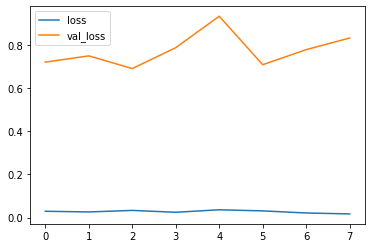

In [439]:
model_loss[['loss','val_loss']].plot()

In [441]:
yhat = model.predict_classes(X_test)

In [444]:
rf_result_tuned = ml_error( 'Neural network tuned', y_test, yhat )
rf_result_tuned

Model Name  Accuracy  Balanced accuracy  F1 score  Kappa Metrics
0  Neural network tuned  0.879464           0.709457  0.542373       0.475251

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

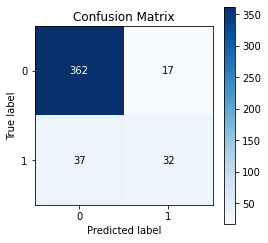

In [445]:
# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat, normalize=False, figsize=(4,4))

# FINAL PIPELINE AND TRAINING FOR PRODUCTION

In [506]:
df9=data.copy()

## Final Pipeline

In [507]:
#data description section
df9['Income'].fillna(0,inplace=True)
df9['Dt_Customer']=pd.to_datetime(df9['Dt_Customer'])

In [508]:
#feature engineering section

# Create column of total amount spent on any products
df9['MntTotal']=df9[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)
# Create column of total number of products purchased
df9['NumPurchasesTotal']=df9[['NumWebPurchases','NumStorePurchases','NumCatalogPurchases']].sum(axis=1)
# Create days since customer's enrollment with the company in relation to first customer's enrollment
df9['DaysSinceEnroll']=(df9['Dt_Customer']-df9['Dt_Customer'].min()).dt.days
# Customer's age in relation to the year 2020
# Note: To the model the choice of year 2020 doesn't matter here since it's just a linear transformation
df9['Age']=2020-df9['Year_Birth']
# Number of campaigns customer accepted
df9['AcceptedCmpTotal']=df9[['AcceptedCmp3','AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2']].sum(axis=1)
# Number of family members
# number of adults: 2 if client is married or together and 1 otherwise
adult=df9['Marital_Status'].apply(lambda x: 2 if x in ['Married','Together'] else 1)
# family is number of adults + teenagers + number of children
df9['FamilySize']=adult+df9['Kidhome']+df9['Teenhome']
# drop
df9.drop(labels=['Z_CostContact','Z_Revenue','Dt_Customer','ID','Year_Birth'],axis=1,inplace=True)

In [509]:
# Data preparation

discrete,continuous,categorical,dates=variable_types(df9)
# categorical
# education
dic={'Basic':0,'2n Cycle':1,'Graduation':2,'Master':3,'PhD':4}
df9['Education']=df9['Education'].map(dic)
# To reduce model complexity we will replace the feature maritural status with a simpler feature called alone
dic={'Married':0,'Together':0,'Single':1,'Divorced':1,'Widow':1,'Alone':1,'YOLO':1,'Absurd':1}
df9['Alone']=df9['Marital_Status'].map(dic)
# drop
df9.drop(['Marital_Status'],axis=1,inplace=True)
# drop outliers (use only for training data not testing)
for var in continuous:
    RM_upper_limit, RM_lower_limit = find_skewed_boundaries(df9, var, 6)
    df9=df9.loc[df9[var]<=RM_upper_limit]
# scaling (use only for training)
scaler = RobustScaler()
cols=continuous+discrete
df9[cols]=scaler.fit_transform(df9[cols].values)

There are 12 discrete variables
There are 9 continuous variables
There are 9 categorical variables
There are 0 date_time variables


In [510]:
# Feature selection
cols_selected=['Recency', 'AcceptedCmpTotal', 'DaysSinceEnroll', 'MntTotal',
'MntMeatProducts', 'Income', 'MntWines', 'MntGoldProds', 'Age',
'MntSweetProducts', 'FamilySize', 'MntFruits', 'MntFishProducts',
'AcceptedCmp5', 'NumStorePurchases', 'NumWebVisitsMonth',
'NumCatalogPurchases', 'NumPurchasesTotal']
df9=df9[cols_selected+['Response']]

In [511]:
df9.head(5)

Recency  AcceptedCmpTotal  DaysSinceEnroll  MntTotal  MntMeatProducts  \
0     0.17               0.0        -0.886331  1.253785         2.238318   
1    -0.23               0.0         0.696403 -0.378240        -0.285047   
2    -0.47               0.0         0.123741  0.390557         0.280374   
3    -0.47               0.0         0.621583 -0.351552        -0.219626   
4     0.89               0.0         0.558273  0.027200         0.238318   

     Income  MntWines  MntGoldProds       Age  MntSweetProducts  FamilySize  \
0  0.212898  0.954262      1.361702  0.722222           2.50000        -2.0   
1 -0.140131 -0.343035     -0.382979  0.888889          -0.21875         0.0   
2  0.616245  0.519751      0.382979  0.277778           0.40625        -1.0   
3 -0.729750 -0.343035     -0.404255 -0.777778          -0.15625         0.0   
4  0.217538 -0.006237     -0.191489 -0.611111           0.59375         0.0   

   MntFruits  MntFishProducts  AcceptedCmp5  NumStorePurchases  \
0    2.50000         3.404255             0               -0.2   
1   -0.21875        -0.212766             0               -0.6   
2    1.28125         2.106383             0                1.0   
3   -0.12500        -0.042553             0               -0.2   
4    1.09375         0.723404             0                0.2   

   NumWebVisitsMonth  NumCatalogPurchases  NumPurchasesTotal  Response  
0               0.25                 2.00           0.833333         1  
1              -0.25                -0.25          -0.666667         0  
2              -0.50                 0.00           0.666667         0  
3               0.00                -0.50          -0.500000         0  
4              -0.25                 0.25           0.166667         0

In [512]:
# All columns names are the same
df9.columns==df6.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [513]:
# Variables ranges are consistent
(df6.max() - df6.min())/(df9.max() - df9.min())

Recency                1.020408
AcceptedCmpTotal       1.000000
DaysSinceEnroll        1.004335
MntTotal               1.012471
MntMeatProducts        1.023923
Income                 0.976784
MntWines               1.045652
MntGoldProds           0.979167
Age                    0.892182
MntSweetProducts       1.000000
FamilySize             1.000000
MntFruits              0.992248
MntFishProducts        1.000000
AcceptedCmp5           1.000000
NumStorePurchases      1.000000
NumWebVisitsMonth      1.000000
NumCatalogPurchases    1.000000
NumPurchasesTotal      1.000000
Response               1.000000
dtype: float64

## Training model for production

In [514]:
X_train=df9.drop(['Response'],axis=1)
y_train=df9['Response']

In [515]:
model = ml.Sequential()
model.add( l.Dense( units=2056, input_dim=X_train.shape[1], activation='relu') )
model.add( l.Dense( units=128, activation='relu') )
model.add( l.Dense( units=32, activation='relu') )
model.add( l.Dropout(0.2) )
model.add( l.Dense( units=1, activation='sigmoid') )

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [516]:
model.fit(x=X_train,y=y_train,epochs=8,verbose=1)

Epoch 1/8
2232/2232 [==============================] - 1s 471us/sample - loss: 0.3535 - acc: 0.8602
Epoch 2/8
2232/2232 [==============================] - 0s 193us/sample - loss: 0.2811 - acc: 0.8835
Epoch 3/8
2232/2232 [==============================] - 0s 192us/sample - loss: 0.2527 - acc: 0.9001
Epoch 4/8
2232/2232 [==============================] - 0s 202us/sample - loss: 0.2496 - acc: 0.8992
Epoch 5/8
2232/2232 [==============================] - 0s 191us/sample - loss: 0.2415 - acc: 0.9037
Epoch 6/8
2232/2232 [==============================] - 0s 203us/sample - loss: 0.2267 - acc: 0.9046
Epoch 7/8
2232/2232 [==============================] - 0s 203us/sample - loss: 0.2194 - acc: 0.9131
Epoch 8/8
2232/2232 [==============================] - 0s 195us/sample - loss: 0.2112 - acc: 0.9064


## Saving model and scaler

In [517]:
model.save("Response_predictor_nn.h5")

In [518]:
import joblib
joblib.dump(scaler,'robust_scaler.pkl')

['robust_scaler.pkl']